In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : True,
    'balance_bins'  : 40,
    'balance_ratio' : 0.5,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_40_1_05_0_0_0_1_t1t2_normalized_e_n_e_0_1_coords_1_0_diffusion_fa_data_norm_b25_t1_mask_t1t2_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2056031, 923)
(2056031, 1)
validation
(242003, 923)
(242003, 1)
test
(221567, 923)
(221567, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 923)]             0         


 dense (Dense)               (None, 1024)              946176    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1635329 (6.24 MB)


Trainable params: 1635329 (6.24 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/206 [..............................] - ETA: 5:06 - loss: 0.1304 - STD: 1.3461e-04 - MAE: 0.3066

  4/206 [..............................] - ETA: 4s - loss: 0.0925 - STD: 3.5741e-04 - MAE: 0.2498  

  7/206 [>.............................] - ETA: 4s - loss: 0.0864 - STD: 4.0359e-04 - MAE: 0.2413

 10/206 [>.............................] - ETA: 4s - loss: 0.0816 - STD: 5.4320e-04 - MAE: 0.2388

 13/206 [>.............................] - ETA: 4s - loss: 0.0794 - STD: 6.6342e-04 - MAE: 0.2380

 16/206 [=>............................] - ETA: 4s - loss: 0.0770 - STD: 7.6404e-04 - MAE: 0.2355

 19/206 [=>............................] - ETA: 4s - loss: 0.0758 - STD: 8.5701e-04 - MAE: 0.2335

 22/206 [==>...........................] - ETA: 4s - loss: 0.0746 - STD: 9.7755e-04 - MAE: 0.2320

 25/206 [==>...........................] - ETA: 4s - loss: 0.0737 - STD: 0.0011 - MAE: 0.2313    

 28/206 [===>..........................] - ETA: 4s - loss: 0.0729 - STD: 0.0013 - MAE: 0.2309

 31/206 [===>..........................] - ETA: 4s - loss: 0.0722 - STD: 0.0016 - MAE: 0.2303

 34/206 [===>..........................] - ETA: 4s - loss: 0.0716 - STD: 0.0019 - MAE: 0.2295

 37/206 [====>.........................] - ETA: 4s - loss: 0.0710 - STD: 0.0022 - MAE: 0.2287

 40/206 [====>.........................] - ETA: 4s - loss: 0.0705 - STD: 0.0028 - MAE: 0.2281

 43/206 [=====>........................] - ETA: 3s - loss: 0.0698 - STD: 0.0036 - MAE: 0.2274

 46/206 [=====>........................] - ETA: 3s - loss: 0.0691 - STD: 0.0046 - MAE: 0.2264

 49/206 [======>.......................] - ETA: 3s - loss: 0.0682 - STD: 0.0062 - MAE: 0.2251

 52/206 [======>.......................] - ETA: 3s - loss: 0.0671 - STD: 0.0087 - MAE: 0.2233

 55/206 [=======>......................] - ETA: 3s - loss: 0.0657 - STD: 0.0124 - MAE: 0.2209

 58/206 [=======>......................] - ETA: 3s - loss: 0.0640 - STD: 0.0180 - MAE: 0.2175

 61/206 [=======>......................] - ETA: 3s - loss: 0.0621 - STD: 0.0253 - MAE: 0.2135

 64/206 [========>.....................] - ETA: 3s - loss: 0.0604 - STD: 0.0340 - MAE: 0.2093

 67/206 [========>.....................] - ETA: 3s - loss: 0.0588 - STD: 0.0428 - MAE: 0.2054

 70/206 [=========>....................] - ETA: 3s - loss: 0.0573 - STD: 0.0510 - MAE: 0.2017

 73/206 [=========>....................] - ETA: 3s - loss: 0.0559 - STD: 0.0580 - MAE: 0.1983

 76/206 [==========>...................] - ETA: 3s - loss: 0.0546 - STD: 0.0637 - MAE: 0.1953

 79/206 [==========>...................] - ETA: 3s - loss: 0.0534 - STD: 0.0685 - MAE: 0.1925

 80/206 [==========>...................] - ETA: 4s - loss: 0.0531 - STD: 0.0700 - MAE: 0.1916

 83/206 [===========>..................] - ETA: 4s - loss: 0.0520 - STD: 0.0748 - MAE: 0.1889

 86/206 [===========>..................] - ETA: 3s - loss: 0.0509 - STD: 0.0796 - MAE: 0.1862

 89/206 [===========>..................] - ETA: 3s - loss: 0.0498 - STD: 0.0842 - MAE: 0.1837

 92/206 [============>.................] - ETA: 3s - loss: 0.0489 - STD: 0.0883 - MAE: 0.1813

 95/206 [============>.................] - ETA: 3s - loss: 0.0479 - STD: 0.0920 - MAE: 0.1790

 98/206 [=============>................] - ETA: 3s - loss: 0.0470 - STD: 0.0955 - MAE: 0.1769

101/206 [=============>................] - ETA: 3s - loss: 0.0462 - STD: 0.0990 - MAE: 0.1748

104/206 [==============>...............] - ETA: 3s - loss: 0.0454 - STD: 0.1024 - MAE: 0.1727

107/206 [==============>...............] - ETA: 3s - loss: 0.0446 - STD: 0.1057 - MAE: 0.1708

110/206 [===============>..............] - ETA: 2s - loss: 0.0439 - STD: 0.1086 - MAE: 0.1689

113/206 [===============>..............] - ETA: 2s - loss: 0.0432 - STD: 0.1114 - MAE: 0.1672

116/206 [===============>..............] - ETA: 2s - loss: 0.0425 - STD: 0.1141 - MAE: 0.1655

119/206 [================>.............] - ETA: 2s - loss: 0.0419 - STD: 0.1168 - MAE: 0.1638

122/206 [================>.............] - ETA: 2s - loss: 0.0413 - STD: 0.1193 - MAE: 0.1622

125/206 [=================>............] - ETA: 2s - loss: 0.0407 - STD: 0.1217 - MAE: 0.1607

128/206 [=================>............] - ETA: 2s - loss: 0.0401 - STD: 0.1240 - MAE: 0.1592

131/206 [==================>...........] - ETA: 2s - loss: 0.0396 - STD: 0.1263 - MAE: 0.1578

134/206 [==================>...........] - ETA: 2s - loss: 0.0391 - STD: 0.1284 - MAE: 0.1565

137/206 [==================>...........] - ETA: 2s - loss: 0.0385 - STD: 0.1304 - MAE: 0.1552

140/206 [===================>..........] - ETA: 1s - loss: 0.0381 - STD: 0.1324 - MAE: 0.1539

143/206 [===================>..........] - ETA: 1s - loss: 0.0376 - STD: 0.1343 - MAE: 0.1527

146/206 [====================>.........] - ETA: 1s - loss: 0.0371 - STD: 0.1361 - MAE: 0.1515

149/206 [====================>.........] - ETA: 1s - loss: 0.0367 - STD: 0.1378 - MAE: 0.1503

152/206 [=====================>........] - ETA: 1s - loss: 0.0363 - STD: 0.1395 - MAE: 0.1492

155/206 [=====================>........] - ETA: 1s - loss: 0.0359 - STD: 0.1412 - MAE: 0.1481

158/206 [======================>.......] - ETA: 1s - loss: 0.0355 - STD: 0.1427 - MAE: 0.1471

161/206 [======================>.......] - ETA: 1s - loss: 0.0351 - STD: 0.1443 - MAE: 0.1461

164/206 [======================>.......] - ETA: 1s - loss: 0.0347 - STD: 0.1458 - MAE: 0.1451

167/206 [=======================>......] - ETA: 1s - loss: 0.0344 - STD: 0.1472 - MAE: 0.1442

170/206 [=======================>......] - ETA: 1s - loss: 0.0340 - STD: 0.1486 - MAE: 0.1432

173/206 [========================>.....] - ETA: 0s - loss: 0.0337 - STD: 0.1500 - MAE: 0.1423

176/206 [========================>.....] - ETA: 0s - loss: 0.0334 - STD: 0.1513 - MAE: 0.1415

179/206 [=========================>....] - ETA: 0s - loss: 0.0330 - STD: 0.1525 - MAE: 0.1406

182/206 [=========================>....] - ETA: 0s - loss: 0.0327 - STD: 0.1537 - MAE: 0.1398

185/206 [=========================>....] - ETA: 0s - loss: 0.0324 - STD: 0.1549 - MAE: 0.1391

188/206 [==========================>...] - ETA: 0s - loss: 0.0322 - STD: 0.1560 - MAE: 0.1383

191/206 [==========================>...] - ETA: 0s - loss: 0.0319 - STD: 0.1571 - MAE: 0.1376

194/206 [===========================>..] - ETA: 0s - loss: 0.0316 - STD: 0.1582 - MAE: 0.1369

197/206 [===========================>..] - ETA: 0s - loss: 0.0314 - STD: 0.1592 - MAE: 0.1362

200/206 [============================>.] - ETA: 0s - loss: 0.0311 - STD: 0.1602 - MAE: 0.1355

203/206 [============================>.] - ETA: 0s - loss: 0.0309 - STD: 0.1612 - MAE: 0.1348

206/206 [==============================] - ETA: 0s - loss: 0.0306 - STD: 0.1622 - MAE: 0.1342

206/206 [==============================] - 8s 33ms/step - loss: 0.0306 - STD: 0.1622 - MAE: 0.1342 - val_loss: 0.0148 - val_STD: 0.0890 - val_MAE: 0.0961


Epoch 2/10000


  1/206 [..............................] - ETA: 12s - loss: 0.0141 - STD: 0.2266 - MAE: 0.0894

  4/206 [..............................] - ETA: 4s - loss: 0.0144 - STD: 0.2267 - MAE: 0.0906 

  7/206 [>.............................] - ETA: 4s - loss: 0.0144 - STD: 0.2264 - MAE: 0.0905

 10/206 [>.............................] - ETA: 4s - loss: 0.0144 - STD: 0.2262 - MAE: 0.0904

 13/206 [>.............................] - ETA: 4s - loss: 0.0144 - STD: 0.2264 - MAE: 0.0904

 16/206 [=>............................] - ETA: 4s - loss: 0.0144 - STD: 0.2267 - MAE: 0.0904

 19/206 [=>............................] - ETA: 4s - loss: 0.0144 - STD: 0.2268 - MAE: 0.0905

 22/206 [==>...........................] - ETA: 4s - loss: 0.0144 - STD: 0.2269 - MAE: 0.0904

 25/206 [==>...........................] - ETA: 4s - loss: 0.0143 - STD: 0.2268 - MAE: 0.0902

 28/206 [===>..........................] - ETA: 4s - loss: 0.0143 - STD: 0.2270 - MAE: 0.0901

 31/206 [===>..........................] - ETA: 4s - loss: 0.0142 - STD: 0.2271 - MAE: 0.0900

 34/206 [===>..........................] - ETA: 4s - loss: 0.0142 - STD: 0.2273 - MAE: 0.0899

 37/206 [====>.........................] - ETA: 4s - loss: 0.0142 - STD: 0.2272 - MAE: 0.0898

 40/206 [====>.........................] - ETA: 3s - loss: 0.0142 - STD: 0.2272 - MAE: 0.0897

 43/206 [=====>........................] - ETA: 3s - loss: 0.0141 - STD: 0.2274 - MAE: 0.0895

 46/206 [=====>........................] - ETA: 3s - loss: 0.0141 - STD: 0.2274 - MAE: 0.0894

 49/206 [======>.......................] - ETA: 3s - loss: 0.0140 - STD: 0.2275 - MAE: 0.0893

 52/206 [======>.......................] - ETA: 3s - loss: 0.0140 - STD: 0.2277 - MAE: 0.0892

 55/206 [=======>......................] - ETA: 3s - loss: 0.0140 - STD: 0.2277 - MAE: 0.0891

 58/206 [=======>......................] - ETA: 3s - loss: 0.0140 - STD: 0.2277 - MAE: 0.0890

 61/206 [=======>......................] - ETA: 3s - loss: 0.0140 - STD: 0.2278 - MAE: 0.0890

 64/206 [========>.....................] - ETA: 3s - loss: 0.0140 - STD: 0.2278 - MAE: 0.0890

 67/206 [========>.....................] - ETA: 3s - loss: 0.0140 - STD: 0.2279 - MAE: 0.0890

 70/206 [=========>....................] - ETA: 3s - loss: 0.0140 - STD: 0.2279 - MAE: 0.0890

 73/206 [=========>....................] - ETA: 3s - loss: 0.0140 - STD: 0.2280 - MAE: 0.0890

 76/206 [==========>...................] - ETA: 3s - loss: 0.0140 - STD: 0.2280 - MAE: 0.0890

 79/206 [==========>...................] - ETA: 3s - loss: 0.0139 - STD: 0.2280 - MAE: 0.0889

 82/206 [==========>...................] - ETA: 2s - loss: 0.0139 - STD: 0.2280 - MAE: 0.0888

 85/206 [===========>..................] - ETA: 2s - loss: 0.0139 - STD: 0.2280 - MAE: 0.0888

 88/206 [===========>..................] - ETA: 2s - loss: 0.0139 - STD: 0.2281 - MAE: 0.0888

 91/206 [============>.................] - ETA: 2s - loss: 0.0139 - STD: 0.2282 - MAE: 0.0887

 94/206 [============>.................] - ETA: 2s - loss: 0.0139 - STD: 0.2282 - MAE: 0.0887

 97/206 [=============>................] - ETA: 2s - loss: 0.0139 - STD: 0.2282 - MAE: 0.0887

100/206 [=============>................] - ETA: 2s - loss: 0.0138 - STD: 0.2282 - MAE: 0.0886

103/206 [==============>...............] - ETA: 2s - loss: 0.0138 - STD: 0.2283 - MAE: 0.0885

106/206 [==============>...............] - ETA: 2s - loss: 0.0138 - STD: 0.2283 - MAE: 0.0885

109/206 [==============>...............] - ETA: 2s - loss: 0.0138 - STD: 0.2283 - MAE: 0.0885

112/206 [===============>..............] - ETA: 2s - loss: 0.0138 - STD: 0.2284 - MAE: 0.0885

115/206 [===============>..............] - ETA: 2s - loss: 0.0138 - STD: 0.2284 - MAE: 0.0884

118/206 [================>.............] - ETA: 2s - loss: 0.0138 - STD: 0.2285 - MAE: 0.0884

121/206 [================>.............] - ETA: 2s - loss: 0.0138 - STD: 0.2285 - MAE: 0.0884

124/206 [=================>............] - ETA: 1s - loss: 0.0138 - STD: 0.2285 - MAE: 0.0883

127/206 [=================>............] - ETA: 1s - loss: 0.0138 - STD: 0.2285 - MAE: 0.0883

130/206 [=================>............] - ETA: 1s - loss: 0.0138 - STD: 0.2286 - MAE: 0.0883

133/206 [==================>...........] - ETA: 1s - loss: 0.0137 - STD: 0.2286 - MAE: 0.0882

136/206 [==================>...........] - ETA: 1s - loss: 0.0137 - STD: 0.2286 - MAE: 0.0882

138/206 [===================>..........] - ETA: 1s - loss: 0.0137 - STD: 0.2286 - MAE: 0.0882

141/206 [===================>..........] - ETA: 1s - loss: 0.0137 - STD: 0.2287 - MAE: 0.0881

143/206 [===================>..........] - ETA: 1s - loss: 0.0137 - STD: 0.2287 - MAE: 0.0881

146/206 [====================>.........] - ETA: 1s - loss: 0.0137 - STD: 0.2288 - MAE: 0.0880

149/206 [====================>.........] - ETA: 1s - loss: 0.0137 - STD: 0.2288 - MAE: 0.0880

152/206 [=====================>........] - ETA: 1s - loss: 0.0137 - STD: 0.2288 - MAE: 0.0879

155/206 [=====================>........] - ETA: 1s - loss: 0.0137 - STD: 0.2288 - MAE: 0.0879

158/206 [======================>.......] - ETA: 1s - loss: 0.0137 - STD: 0.2289 - MAE: 0.0879

161/206 [======================>.......] - ETA: 1s - loss: 0.0136 - STD: 0.2289 - MAE: 0.0879

164/206 [======================>.......] - ETA: 1s - loss: 0.0136 - STD: 0.2289 - MAE: 0.0878

167/206 [=======================>......] - ETA: 0s - loss: 0.0136 - STD: 0.2289 - MAE: 0.0878

170/206 [=======================>......] - ETA: 0s - loss: 0.0136 - STD: 0.2289 - MAE: 0.0878

173/206 [========================>.....] - ETA: 0s - loss: 0.0136 - STD: 0.2290 - MAE: 0.0877

176/206 [========================>.....] - ETA: 0s - loss: 0.0136 - STD: 0.2290 - MAE: 0.0876

179/206 [=========================>....] - ETA: 0s - loss: 0.0136 - STD: 0.2291 - MAE: 0.0876

182/206 [=========================>....] - ETA: 0s - loss: 0.0136 - STD: 0.2290 - MAE: 0.0876

185/206 [=========================>....] - ETA: 0s - loss: 0.0136 - STD: 0.2290 - MAE: 0.0876

188/206 [==========================>...] - ETA: 0s - loss: 0.0136 - STD: 0.2291 - MAE: 0.0875

191/206 [==========================>...] - ETA: 0s - loss: 0.0135 - STD: 0.2291 - MAE: 0.0875

194/206 [===========================>..] - ETA: 0s - loss: 0.0135 - STD: 0.2291 - MAE: 0.0875

197/206 [===========================>..] - ETA: 0s - loss: 0.0135 - STD: 0.2291 - MAE: 0.0874

200/206 [============================>.] - ETA: 0s - loss: 0.0135 - STD: 0.2292 - MAE: 0.0874

203/206 [============================>.] - ETA: 0s - loss: 0.0135 - STD: 0.2292 - MAE: 0.0873

206/206 [==============================] - ETA: 0s - loss: 0.0135 - STD: 0.2292 - MAE: 0.0873

206/206 [==============================] - 5s 26ms/step - loss: 0.0135 - STD: 0.2292 - MAE: 0.0873 - val_loss: 0.0147 - val_STD: 0.0850 - val_MAE: 0.0951


Epoch 3/10000


  1/206 [..............................] - ETA: 13s - loss: 0.0124 - STD: 0.2306 - MAE: 0.0842

  4/206 [..............................] - ETA: 4s - loss: 0.0124 - STD: 0.2318 - MAE: 0.0837 

  7/206 [>.............................] - ETA: 4s - loss: 0.0123 - STD: 0.2318 - MAE: 0.0837

 10/206 [>.............................] - ETA: 4s - loss: 0.0129 - STD: 0.2316 - MAE: 0.0854

 13/206 [>.............................] - ETA: 4s - loss: 0.0139 - STD: 0.2300 - MAE: 0.0888

 16/206 [=>............................] - ETA: 4s - loss: 0.0140 - STD: 0.2306 - MAE: 0.0891

 19/206 [=>............................] - ETA: 4s - loss: 0.0140 - STD: 0.2306 - MAE: 0.0889

 22/206 [==>...........................] - ETA: 4s - loss: 0.0139 - STD: 0.2300 - MAE: 0.0887

 25/206 [==>...........................] - ETA: 4s - loss: 0.0138 - STD: 0.2296 - MAE: 0.0885

 28/206 [===>..........................] - ETA: 4s - loss: 0.0137 - STD: 0.2294 - MAE: 0.0883

 31/206 [===>..........................] - ETA: 4s - loss: 0.0137 - STD: 0.2296 - MAE: 0.0881

 34/206 [===>..........................] - ETA: 4s - loss: 0.0136 - STD: 0.2297 - MAE: 0.0878

 37/206 [====>.........................] - ETA: 4s - loss: 0.0136 - STD: 0.2295 - MAE: 0.0877

 40/206 [====>.........................] - ETA: 3s - loss: 0.0135 - STD: 0.2292 - MAE: 0.0875

 43/206 [=====>........................] - ETA: 3s - loss: 0.0135 - STD: 0.2292 - MAE: 0.0874

 46/206 [=====>........................] - ETA: 3s - loss: 0.0134 - STD: 0.2292 - MAE: 0.0872

 49/206 [======>.......................] - ETA: 3s - loss: 0.0134 - STD: 0.2293 - MAE: 0.0870

 52/206 [======>.......................] - ETA: 3s - loss: 0.0134 - STD: 0.2293 - MAE: 0.0869

 55/206 [=======>......................] - ETA: 3s - loss: 0.0133 - STD: 0.2294 - MAE: 0.0867

 58/206 [=======>......................] - ETA: 3s - loss: 0.0133 - STD: 0.2296 - MAE: 0.0866

 61/206 [=======>......................] - ETA: 3s - loss: 0.0132 - STD: 0.2296 - MAE: 0.0864

 64/206 [========>.....................] - ETA: 3s - loss: 0.0132 - STD: 0.2297 - MAE: 0.0863

 67/206 [========>.....................] - ETA: 3s - loss: 0.0131 - STD: 0.2297 - MAE: 0.0862

 70/206 [=========>....................] - ETA: 3s - loss: 0.0131 - STD: 0.2298 - MAE: 0.0860

 73/206 [=========>....................] - ETA: 3s - loss: 0.0131 - STD: 0.2300 - MAE: 0.0859

 76/206 [==========>...................] - ETA: 3s - loss: 0.0130 - STD: 0.2300 - MAE: 0.0858

 79/206 [==========>...................] - ETA: 3s - loss: 0.0130 - STD: 0.2301 - MAE: 0.0858

 82/206 [==========>...................] - ETA: 2s - loss: 0.0130 - STD: 0.2301 - MAE: 0.0857

 85/206 [===========>..................] - ETA: 2s - loss: 0.0130 - STD: 0.2301 - MAE: 0.0857

 88/206 [===========>..................] - ETA: 2s - loss: 0.0130 - STD: 0.2302 - MAE: 0.0856

 91/206 [============>.................] - ETA: 2s - loss: 0.0130 - STD: 0.2303 - MAE: 0.0855

 94/206 [============>.................] - ETA: 2s - loss: 0.0130 - STD: 0.2302 - MAE: 0.0855

 97/206 [=============>................] - ETA: 2s - loss: 0.0129 - STD: 0.2302 - MAE: 0.0855

100/206 [=============>................] - ETA: 2s - loss: 0.0129 - STD: 0.2303 - MAE: 0.0854

103/206 [==============>...............] - ETA: 2s - loss: 0.0129 - STD: 0.2303 - MAE: 0.0853

106/206 [==============>...............] - ETA: 2s - loss: 0.0129 - STD: 0.2304 - MAE: 0.0853

109/206 [==============>...............] - ETA: 2s - loss: 0.0128 - STD: 0.2304 - MAE: 0.0852

112/206 [===============>..............] - ETA: 2s - loss: 0.0128 - STD: 0.2305 - MAE: 0.0851

115/206 [===============>..............] - ETA: 2s - loss: 0.0128 - STD: 0.2306 - MAE: 0.0851

118/206 [================>.............] - ETA: 2s - loss: 0.0128 - STD: 0.2307 - MAE: 0.0850

121/206 [================>.............] - ETA: 2s - loss: 0.0128 - STD: 0.2307 - MAE: 0.0849

124/206 [=================>............] - ETA: 1s - loss: 0.0128 - STD: 0.2308 - MAE: 0.0849

127/206 [=================>............] - ETA: 1s - loss: 0.0127 - STD: 0.2308 - MAE: 0.0848

130/206 [=================>............] - ETA: 1s - loss: 0.0127 - STD: 0.2308 - MAE: 0.0848

133/206 [==================>...........] - ETA: 1s - loss: 0.0127 - STD: 0.2309 - MAE: 0.0848

136/206 [==================>...........] - ETA: 1s - loss: 0.0127 - STD: 0.2309 - MAE: 0.0847

139/206 [===================>..........] - ETA: 1s - loss: 0.0127 - STD: 0.2309 - MAE: 0.0847

142/206 [===================>..........] - ETA: 1s - loss: 0.0127 - STD: 0.2309 - MAE: 0.0847

145/206 [====================>.........] - ETA: 1s - loss: 0.0127 - STD: 0.2309 - MAE: 0.0847

148/206 [====================>.........] - ETA: 1s - loss: 0.0127 - STD: 0.2309 - MAE: 0.0846

151/206 [====================>.........] - ETA: 1s - loss: 0.0127 - STD: 0.2309 - MAE: 0.0846

154/206 [=====================>........] - ETA: 1s - loss: 0.0127 - STD: 0.2309 - MAE: 0.0845

157/206 [=====================>........] - ETA: 1s - loss: 0.0126 - STD: 0.2309 - MAE: 0.0845

160/206 [======================>.......] - ETA: 1s - loss: 0.0126 - STD: 0.2309 - MAE: 0.0844

163/206 [======================>.......] - ETA: 1s - loss: 0.0126 - STD: 0.2309 - MAE: 0.0844

166/206 [=======================>......] - ETA: 0s - loss: 0.0126 - STD: 0.2310 - MAE: 0.0843

169/206 [=======================>......] - ETA: 0s - loss: 0.0126 - STD: 0.2310 - MAE: 0.0843

172/206 [========================>.....] - ETA: 0s - loss: 0.0126 - STD: 0.2310 - MAE: 0.0842

175/206 [========================>.....] - ETA: 0s - loss: 0.0126 - STD: 0.2310 - MAE: 0.0843

178/206 [========================>.....] - ETA: 0s - loss: 0.0126 - STD: 0.2311 - MAE: 0.0843

181/206 [=========================>....] - ETA: 0s - loss: 0.0126 - STD: 0.2311 - MAE: 0.0843

184/206 [=========================>....] - ETA: 0s - loss: 0.0126 - STD: 0.2311 - MAE: 0.0843

187/206 [==========================>...] - ETA: 0s - loss: 0.0126 - STD: 0.2311 - MAE: 0.0843

190/206 [==========================>...] - ETA: 0s - loss: 0.0126 - STD: 0.2311 - MAE: 0.0842

193/206 [===========================>..] - ETA: 0s - loss: 0.0126 - STD: 0.2311 - MAE: 0.0842

196/206 [===========================>..] - ETA: 0s - loss: 0.0126 - STD: 0.2311 - MAE: 0.0842

199/206 [===========================>..] - ETA: 0s - loss: 0.0125 - STD: 0.2312 - MAE: 0.0841

202/206 [============================>.] - ETA: 0s - loss: 0.0125 - STD: 0.2312 - MAE: 0.0841

205/206 [============================>.] - ETA: 0s - loss: 0.0125 - STD: 0.2312 - MAE: 0.0840

206/206 [==============================] - 5s 26ms/step - loss: 0.0125 - STD: 0.2312 - MAE: 0.0840 - val_loss: 0.0141 - val_STD: 0.0824 - val_MAE: 0.0932


Epoch 4/10000


  1/206 [..............................] - ETA: 10s - loss: 0.0115 - STD: 0.2332 - MAE: 0.0812

  4/206 [..............................] - ETA: 4s - loss: 0.0116 - STD: 0.2328 - MAE: 0.0808 

  7/206 [>.............................] - ETA: 4s - loss: 0.0116 - STD: 0.2333 - MAE: 0.0810

 10/206 [>.............................] - ETA: 4s - loss: 0.0117 - STD: 0.2327 - MAE: 0.0814

 13/206 [>.............................] - ETA: 4s - loss: 0.0117 - STD: 0.2327 - MAE: 0.0812

 16/206 [=>............................] - ETA: 4s - loss: 0.0117 - STD: 0.2328 - MAE: 0.0811

 19/206 [=>............................] - ETA: 4s - loss: 0.0118 - STD: 0.2324 - MAE: 0.0815

 22/206 [==>...........................] - ETA: 4s - loss: 0.0122 - STD: 0.2327 - MAE: 0.0829

 25/206 [==>...........................] - ETA: 4s - loss: 0.0123 - STD: 0.2332 - MAE: 0.0830

 28/206 [===>..........................] - ETA: 4s - loss: 0.0123 - STD: 0.2329 - MAE: 0.0832

 31/206 [===>..........................] - ETA: 4s - loss: 0.0124 - STD: 0.2324 - MAE: 0.0835

 34/206 [===>..........................] - ETA: 4s - loss: 0.0123 - STD: 0.2322 - MAE: 0.0833

 37/206 [====>.........................] - ETA: 4s - loss: 0.0123 - STD: 0.2322 - MAE: 0.0832

 40/206 [====>.........................] - ETA: 4s - loss: 0.0123 - STD: 0.2322 - MAE: 0.0832

 43/206 [=====>........................] - ETA: 3s - loss: 0.0122 - STD: 0.2322 - MAE: 0.0830

 46/206 [=====>........................] - ETA: 3s - loss: 0.0122 - STD: 0.2321 - MAE: 0.0829

 49/206 [======>.......................] - ETA: 3s - loss: 0.0122 - STD: 0.2320 - MAE: 0.0829

 52/206 [======>.......................] - ETA: 3s - loss: 0.0122 - STD: 0.2319 - MAE: 0.0828

 55/206 [=======>......................] - ETA: 3s - loss: 0.0121 - STD: 0.2319 - MAE: 0.0826

 58/206 [=======>......................] - ETA: 3s - loss: 0.0121 - STD: 0.2320 - MAE: 0.0825

 61/206 [=======>......................] - ETA: 3s - loss: 0.0121 - STD: 0.2320 - MAE: 0.0824

 64/206 [========>.....................] - ETA: 3s - loss: 0.0120 - STD: 0.2320 - MAE: 0.0823

 67/206 [========>.....................] - ETA: 3s - loss: 0.0120 - STD: 0.2320 - MAE: 0.0823

 70/206 [=========>....................] - ETA: 3s - loss: 0.0120 - STD: 0.2321 - MAE: 0.0823

 73/206 [=========>....................] - ETA: 3s - loss: 0.0120 - STD: 0.2322 - MAE: 0.0822

 76/206 [==========>...................] - ETA: 3s - loss: 0.0120 - STD: 0.2322 - MAE: 0.0822

 79/206 [==========>...................] - ETA: 3s - loss: 0.0120 - STD: 0.2322 - MAE: 0.0821

 82/206 [==========>...................] - ETA: 2s - loss: 0.0119 - STD: 0.2322 - MAE: 0.0820

 85/206 [===========>..................] - ETA: 2s - loss: 0.0119 - STD: 0.2322 - MAE: 0.0820

 88/206 [===========>..................] - ETA: 2s - loss: 0.0119 - STD: 0.2323 - MAE: 0.0819

 91/206 [============>.................] - ETA: 2s - loss: 0.0119 - STD: 0.2324 - MAE: 0.0818

 94/206 [============>.................] - ETA: 2s - loss: 0.0119 - STD: 0.2324 - MAE: 0.0817

 97/206 [=============>................] - ETA: 2s - loss: 0.0119 - STD: 0.2324 - MAE: 0.0817

100/206 [=============>................] - ETA: 2s - loss: 0.0118 - STD: 0.2324 - MAE: 0.0817

103/206 [==============>...............] - ETA: 2s - loss: 0.0119 - STD: 0.2325 - MAE: 0.0818

106/206 [==============>...............] - ETA: 2s - loss: 0.0119 - STD: 0.2326 - MAE: 0.0817

109/206 [==============>...............] - ETA: 2s - loss: 0.0119 - STD: 0.2326 - MAE: 0.0817

112/206 [===============>..............] - ETA: 2s - loss: 0.0118 - STD: 0.2326 - MAE: 0.0817

115/206 [===============>..............] - ETA: 2s - loss: 0.0118 - STD: 0.2326 - MAE: 0.0816

118/206 [================>.............] - ETA: 2s - loss: 0.0118 - STD: 0.2326 - MAE: 0.0815

121/206 [================>.............] - ETA: 2s - loss: 0.0118 - STD: 0.2326 - MAE: 0.0815

124/206 [=================>............] - ETA: 1s - loss: 0.0118 - STD: 0.2327 - MAE: 0.0814

127/206 [=================>............] - ETA: 1s - loss: 0.0117 - STD: 0.2327 - MAE: 0.0814

130/206 [=================>............] - ETA: 1s - loss: 0.0117 - STD: 0.2327 - MAE: 0.0813

133/206 [==================>...........] - ETA: 1s - loss: 0.0117 - STD: 0.2327 - MAE: 0.0813

136/206 [==================>...........] - ETA: 1s - loss: 0.0117 - STD: 0.2327 - MAE: 0.0814

139/206 [===================>..........] - ETA: 1s - loss: 0.0117 - STD: 0.2327 - MAE: 0.0813

142/206 [===================>..........] - ETA: 1s - loss: 0.0117 - STD: 0.2327 - MAE: 0.0813

145/206 [====================>.........] - ETA: 1s - loss: 0.0117 - STD: 0.2328 - MAE: 0.0813

148/206 [====================>.........] - ETA: 1s - loss: 0.0117 - STD: 0.2328 - MAE: 0.0812

151/206 [====================>.........] - ETA: 1s - loss: 0.0117 - STD: 0.2328 - MAE: 0.0812

154/206 [=====================>........] - ETA: 1s - loss: 0.0117 - STD: 0.2328 - MAE: 0.0811

157/206 [=====================>........] - ETA: 1s - loss: 0.0117 - STD: 0.2328 - MAE: 0.0811

160/206 [======================>.......] - ETA: 1s - loss: 0.0117 - STD: 0.2328 - MAE: 0.0811

163/206 [======================>.......] - ETA: 1s - loss: 0.0117 - STD: 0.2328 - MAE: 0.0811

166/206 [=======================>......] - ETA: 0s - loss: 0.0117 - STD: 0.2329 - MAE: 0.0811

169/206 [=======================>......] - ETA: 0s - loss: 0.0116 - STD: 0.2329 - MAE: 0.0810

172/206 [========================>.....] - ETA: 0s - loss: 0.0117 - STD: 0.2329 - MAE: 0.0811

175/206 [========================>.....] - ETA: 0s - loss: 0.0116 - STD: 0.2329 - MAE: 0.0810

178/206 [========================>.....] - ETA: 0s - loss: 0.0116 - STD: 0.2330 - MAE: 0.0810

181/206 [=========================>....] - ETA: 0s - loss: 0.0116 - STD: 0.2329 - MAE: 0.0810

184/206 [=========================>....] - ETA: 0s - loss: 0.0116 - STD: 0.2329 - MAE: 0.0809

187/206 [==========================>...] - ETA: 0s - loss: 0.0116 - STD: 0.2329 - MAE: 0.0809

190/206 [==========================>...] - ETA: 0s - loss: 0.0116 - STD: 0.2329 - MAE: 0.0808

193/206 [===========================>..] - ETA: 0s - loss: 0.0116 - STD: 0.2330 - MAE: 0.0808

196/206 [===========================>..] - ETA: 0s - loss: 0.0116 - STD: 0.2330 - MAE: 0.0808

199/206 [===========================>..] - ETA: 0s - loss: 0.0116 - STD: 0.2330 - MAE: 0.0807

202/206 [============================>.] - ETA: 0s - loss: 0.0116 - STD: 0.2330 - MAE: 0.0807

205/206 [============================>.] - ETA: 0s - loss: 0.0115 - STD: 0.2331 - MAE: 0.0807

206/206 [==============================] - 5s 26ms/step - loss: 0.0115 - STD: 0.2331 - MAE: 0.0807 - val_loss: 0.0148 - val_STD: 0.0784 - val_MAE: 0.0945


Epoch 5/10000


  1/206 [..............................] - ETA: 11s - loss: 0.0112 - STD: 0.2321 - MAE: 0.0793

  4/206 [..............................] - ETA: 4s - loss: 0.0106 - STD: 0.2332 - MAE: 0.0776 

  7/206 [>.............................] - ETA: 4s - loss: 0.0112 - STD: 0.2343 - MAE: 0.0794

 10/206 [>.............................] - ETA: 4s - loss: 0.0114 - STD: 0.2349 - MAE: 0.0801

 13/206 [>.............................] - ETA: 4s - loss: 0.0112 - STD: 0.2342 - MAE: 0.0796

 16/206 [=>............................] - ETA: 4s - loss: 0.0113 - STD: 0.2337 - MAE: 0.0799

 19/206 [=>............................] - ETA: 4s - loss: 0.0113 - STD: 0.2345 - MAE: 0.0797

 22/206 [==>...........................] - ETA: 4s - loss: 0.0112 - STD: 0.2343 - MAE: 0.0795

 25/206 [==>...........................] - ETA: 4s - loss: 0.0113 - STD: 0.2334 - MAE: 0.0798

 28/206 [===>..........................] - ETA: 4s - loss: 0.0112 - STD: 0.2340 - MAE: 0.0795

 31/206 [===>..........................] - ETA: 4s - loss: 0.0112 - STD: 0.2341 - MAE: 0.0795

 34/206 [===>..........................] - ETA: 4s - loss: 0.0112 - STD: 0.2340 - MAE: 0.0793

 37/206 [====>.........................] - ETA: 4s - loss: 0.0111 - STD: 0.2338 - MAE: 0.0792

 40/206 [====>.........................] - ETA: 3s - loss: 0.0111 - STD: 0.2338 - MAE: 0.0790

 43/206 [=====>........................] - ETA: 3s - loss: 0.0111 - STD: 0.2339 - MAE: 0.0790

 46/206 [=====>........................] - ETA: 3s - loss: 0.0111 - STD: 0.2338 - MAE: 0.0793

 49/206 [======>.......................] - ETA: 3s - loss: 0.0111 - STD: 0.2341 - MAE: 0.0791

 52/206 [======>.......................] - ETA: 3s - loss: 0.0111 - STD: 0.2340 - MAE: 0.0792

 55/206 [=======>......................] - ETA: 3s - loss: 0.0111 - STD: 0.2340 - MAE: 0.0791

 58/206 [=======>......................] - ETA: 3s - loss: 0.0111 - STD: 0.2340 - MAE: 0.0791

 61/206 [=======>......................] - ETA: 3s - loss: 0.0111 - STD: 0.2339 - MAE: 0.0791

 64/206 [========>.....................] - ETA: 3s - loss: 0.0111 - STD: 0.2340 - MAE: 0.0790

 67/206 [========>.....................] - ETA: 3s - loss: 0.0110 - STD: 0.2341 - MAE: 0.0789

 70/206 [=========>....................] - ETA: 3s - loss: 0.0110 - STD: 0.2341 - MAE: 0.0788

 73/206 [=========>....................] - ETA: 3s - loss: 0.0110 - STD: 0.2339 - MAE: 0.0788

 76/206 [==========>...................] - ETA: 3s - loss: 0.0110 - STD: 0.2341 - MAE: 0.0787

 79/206 [==========>...................] - ETA: 3s - loss: 0.0110 - STD: 0.2341 - MAE: 0.0787

 82/206 [==========>...................] - ETA: 2s - loss: 0.0110 - STD: 0.2340 - MAE: 0.0788

 85/206 [===========>..................] - ETA: 2s - loss: 0.0110 - STD: 0.2341 - MAE: 0.0787

 88/206 [===========>..................] - ETA: 2s - loss: 0.0110 - STD: 0.2342 - MAE: 0.0786

 91/206 [============>.................] - ETA: 2s - loss: 0.0109 - STD: 0.2342 - MAE: 0.0786

 94/206 [============>.................] - ETA: 2s - loss: 0.0109 - STD: 0.2342 - MAE: 0.0785

 97/206 [=============>................] - ETA: 2s - loss: 0.0109 - STD: 0.2342 - MAE: 0.0785

100/206 [=============>................] - ETA: 2s - loss: 0.0109 - STD: 0.2343 - MAE: 0.0785

103/206 [==============>...............] - ETA: 2s - loss: 0.0109 - STD: 0.2344 - MAE: 0.0784

106/206 [==============>...............] - ETA: 2s - loss: 0.0109 - STD: 0.2344 - MAE: 0.0784

109/206 [==============>...............] - ETA: 2s - loss: 0.0109 - STD: 0.2345 - MAE: 0.0783

112/206 [===============>..............] - ETA: 2s - loss: 0.0109 - STD: 0.2344 - MAE: 0.0783

115/206 [===============>..............] - ETA: 2s - loss: 0.0109 - STD: 0.2345 - MAE: 0.0783

118/206 [================>.............] - ETA: 2s - loss: 0.0108 - STD: 0.2346 - MAE: 0.0782

121/206 [================>.............] - ETA: 2s - loss: 0.0109 - STD: 0.2345 - MAE: 0.0783

124/206 [=================>............] - ETA: 1s - loss: 0.0109 - STD: 0.2346 - MAE: 0.0785

127/206 [=================>............] - ETA: 1s - loss: 0.0109 - STD: 0.2346 - MAE: 0.0785

130/206 [=================>............] - ETA: 1s - loss: 0.0109 - STD: 0.2346 - MAE: 0.0785

133/206 [==================>...........] - ETA: 1s - loss: 0.0109 - STD: 0.2346 - MAE: 0.0784

136/206 [==================>...........] - ETA: 1s - loss: 0.0109 - STD: 0.2346 - MAE: 0.0783

139/206 [===================>..........] - ETA: 1s - loss: 0.0109 - STD: 0.2345 - MAE: 0.0783

142/206 [===================>..........] - ETA: 1s - loss: 0.0108 - STD: 0.2345 - MAE: 0.0783

145/206 [====================>.........] - ETA: 1s - loss: 0.0108 - STD: 0.2346 - MAE: 0.0782

148/206 [====================>.........] - ETA: 1s - loss: 0.0108 - STD: 0.2346 - MAE: 0.0782

151/206 [====================>.........] - ETA: 1s - loss: 0.0108 - STD: 0.2346 - MAE: 0.0782

154/206 [=====================>........] - ETA: 1s - loss: 0.0108 - STD: 0.2346 - MAE: 0.0781

157/206 [=====================>........] - ETA: 1s - loss: 0.0108 - STD: 0.2346 - MAE: 0.0782

160/206 [======================>.......] - ETA: 1s - loss: 0.0108 - STD: 0.2347 - MAE: 0.0781

163/206 [======================>.......] - ETA: 1s - loss: 0.0108 - STD: 0.2347 - MAE: 0.0781

166/206 [=======================>......] - ETA: 0s - loss: 0.0108 - STD: 0.2347 - MAE: 0.0780

169/206 [=======================>......] - ETA: 0s - loss: 0.0108 - STD: 0.2347 - MAE: 0.0780

172/206 [========================>.....] - ETA: 0s - loss: 0.0107 - STD: 0.2347 - MAE: 0.0779

175/206 [========================>.....] - ETA: 0s - loss: 0.0107 - STD: 0.2347 - MAE: 0.0779

178/206 [========================>.....] - ETA: 0s - loss: 0.0107 - STD: 0.2347 - MAE: 0.0778

181/206 [=========================>....] - ETA: 0s - loss: 0.0107 - STD: 0.2348 - MAE: 0.0779

184/206 [=========================>....] - ETA: 0s - loss: 0.0107 - STD: 0.2348 - MAE: 0.0779

187/206 [==========================>...] - ETA: 0s - loss: 0.0107 - STD: 0.2348 - MAE: 0.0778

190/206 [==========================>...] - ETA: 0s - loss: 0.0107 - STD: 0.2348 - MAE: 0.0778

193/206 [===========================>..] - ETA: 0s - loss: 0.0107 - STD: 0.2348 - MAE: 0.0778

196/206 [===========================>..] - ETA: 0s - loss: 0.0107 - STD: 0.2348 - MAE: 0.0777

199/206 [===========================>..] - ETA: 0s - loss: 0.0107 - STD: 0.2348 - MAE: 0.0777

202/206 [============================>.] - ETA: 0s - loss: 0.0107 - STD: 0.2349 - MAE: 0.0777

205/206 [============================>.] - ETA: 0s - loss: 0.0107 - STD: 0.2349 - MAE: 0.0777

206/206 [==============================] - 5s 26ms/step - loss: 0.0107 - STD: 0.2349 - MAE: 0.0777 - val_loss: 0.0133 - val_STD: 0.0875 - val_MAE: 0.0913


Epoch 6/10000


  1/206 [..............................] - ETA: 11s - loss: 0.0109 - STD: 0.2453 - MAE: 0.0766

  4/206 [..............................] - ETA: 4s - loss: 0.0102 - STD: 0.2395 - MAE: 0.0754 

  7/206 [>.............................] - ETA: 4s - loss: 0.0101 - STD: 0.2367 - MAE: 0.0756

 10/206 [>.............................] - ETA: 4s - loss: 0.0100 - STD: 0.2364 - MAE: 0.0751

 13/206 [>.............................] - ETA: 4s - loss: 0.0099 - STD: 0.2370 - MAE: 0.0749

 16/206 [=>............................] - ETA: 4s - loss: 0.0100 - STD: 0.2365 - MAE: 0.0752

 19/206 [=>............................] - ETA: 4s - loss: 0.0100 - STD: 0.2365 - MAE: 0.0751

 22/206 [==>...........................] - ETA: 4s - loss: 0.0100 - STD: 0.2364 - MAE: 0.0751

 25/206 [==>...........................] - ETA: 4s - loss: 0.0099 - STD: 0.2365 - MAE: 0.0748

 28/206 [===>..........................] - ETA: 4s - loss: 0.0098 - STD: 0.2367 - MAE: 0.0746

 31/206 [===>..........................] - ETA: 4s - loss: 0.0100 - STD: 0.2363 - MAE: 0.0754

 34/206 [===>..........................] - ETA: 4s - loss: 0.0103 - STD: 0.2367 - MAE: 0.0763

 37/206 [====>.........................] - ETA: 4s - loss: 0.0105 - STD: 0.2367 - MAE: 0.0768

 40/206 [====>.........................] - ETA: 4s - loss: 0.0105 - STD: 0.2367 - MAE: 0.0771

 43/206 [=====>........................] - ETA: 3s - loss: 0.0105 - STD: 0.2368 - MAE: 0.0771

 46/206 [=====>........................] - ETA: 3s - loss: 0.0106 - STD: 0.2366 - MAE: 0.0772

 49/206 [======>.......................] - ETA: 3s - loss: 0.0105 - STD: 0.2365 - MAE: 0.0771

 52/206 [======>.......................] - ETA: 3s - loss: 0.0105 - STD: 0.2365 - MAE: 0.0770

 55/206 [=======>......................] - ETA: 3s - loss: 0.0105 - STD: 0.2364 - MAE: 0.0768

 58/206 [=======>......................] - ETA: 3s - loss: 0.0104 - STD: 0.2364 - MAE: 0.0767

 61/206 [=======>......................] - ETA: 3s - loss: 0.0104 - STD: 0.2363 - MAE: 0.0765

 64/206 [========>.....................] - ETA: 3s - loss: 0.0103 - STD: 0.2363 - MAE: 0.0764

 67/206 [========>.....................] - ETA: 3s - loss: 0.0103 - STD: 0.2362 - MAE: 0.0763

 70/206 [=========>....................] - ETA: 3s - loss: 0.0103 - STD: 0.2361 - MAE: 0.0761

 73/206 [=========>....................] - ETA: 3s - loss: 0.0102 - STD: 0.2363 - MAE: 0.0760

 76/206 [==========>...................] - ETA: 3s - loss: 0.0102 - STD: 0.2363 - MAE: 0.0759

 79/206 [==========>...................] - ETA: 3s - loss: 0.0102 - STD: 0.2363 - MAE: 0.0759

 82/206 [==========>...................] - ETA: 2s - loss: 0.0102 - STD: 0.2364 - MAE: 0.0758

 85/206 [===========>..................] - ETA: 2s - loss: 0.0102 - STD: 0.2363 - MAE: 0.0758

 88/206 [===========>..................] - ETA: 2s - loss: 0.0102 - STD: 0.2363 - MAE: 0.0757

 91/206 [============>.................] - ETA: 2s - loss: 0.0101 - STD: 0.2364 - MAE: 0.0757

 94/206 [============>.................] - ETA: 2s - loss: 0.0101 - STD: 0.2364 - MAE: 0.0756

 97/206 [=============>................] - ETA: 2s - loss: 0.0101 - STD: 0.2365 - MAE: 0.0755

100/206 [=============>................] - ETA: 2s - loss: 0.0101 - STD: 0.2365 - MAE: 0.0756

103/206 [==============>...............] - ETA: 2s - loss: 0.0101 - STD: 0.2364 - MAE: 0.0757

106/206 [==============>...............] - ETA: 2s - loss: 0.0101 - STD: 0.2365 - MAE: 0.0757

109/206 [==============>...............] - ETA: 2s - loss: 0.0101 - STD: 0.2365 - MAE: 0.0757

112/206 [===============>..............] - ETA: 2s - loss: 0.0101 - STD: 0.2366 - MAE: 0.0756

115/206 [===============>..............] - ETA: 2s - loss: 0.0101 - STD: 0.2365 - MAE: 0.0756

118/206 [================>.............] - ETA: 2s - loss: 0.0101 - STD: 0.2365 - MAE: 0.0755

121/206 [================>.............] - ETA: 2s - loss: 0.0101 - STD: 0.2365 - MAE: 0.0754

124/206 [=================>............] - ETA: 1s - loss: 0.0101 - STD: 0.2365 - MAE: 0.0755

127/206 [=================>............] - ETA: 1s - loss: 0.0101 - STD: 0.2366 - MAE: 0.0756

130/206 [=================>............] - ETA: 1s - loss: 0.0101 - STD: 0.2365 - MAE: 0.0756

133/206 [==================>...........] - ETA: 1s - loss: 0.0101 - STD: 0.2365 - MAE: 0.0756

136/206 [==================>...........] - ETA: 1s - loss: 0.0101 - STD: 0.2365 - MAE: 0.0756

139/206 [===================>..........] - ETA: 1s - loss: 0.0101 - STD: 0.2365 - MAE: 0.0755

142/206 [===================>..........] - ETA: 1s - loss: 0.0101 - STD: 0.2365 - MAE: 0.0755

145/206 [====================>.........] - ETA: 1s - loss: 0.0101 - STD: 0.2365 - MAE: 0.0754

148/206 [====================>.........] - ETA: 1s - loss: 0.0101 - STD: 0.2365 - MAE: 0.0754

151/206 [====================>.........] - ETA: 1s - loss: 0.0101 - STD: 0.2365 - MAE: 0.0754

154/206 [=====================>........] - ETA: 1s - loss: 0.0101 - STD: 0.2366 - MAE: 0.0753

157/206 [=====================>........] - ETA: 1s - loss: 0.0101 - STD: 0.2366 - MAE: 0.0753

160/206 [======================>.......] - ETA: 1s - loss: 0.0100 - STD: 0.2366 - MAE: 0.0753

163/206 [======================>.......] - ETA: 1s - loss: 0.0100 - STD: 0.2366 - MAE: 0.0752

166/206 [=======================>......] - ETA: 0s - loss: 0.0100 - STD: 0.2367 - MAE: 0.0752

169/206 [=======================>......] - ETA: 0s - loss: 0.0100 - STD: 0.2367 - MAE: 0.0751

172/206 [========================>.....] - ETA: 0s - loss: 0.0100 - STD: 0.2367 - MAE: 0.0751

175/206 [========================>.....] - ETA: 0s - loss: 0.0100 - STD: 0.2368 - MAE: 0.0751

178/206 [========================>.....] - ETA: 0s - loss: 0.0100 - STD: 0.2368 - MAE: 0.0750

181/206 [=========================>....] - ETA: 0s - loss: 0.0100 - STD: 0.2368 - MAE: 0.0749

184/206 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 0.2369 - MAE: 0.0749

187/206 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 0.2368 - MAE: 0.0749

190/206 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 0.2369 - MAE: 0.0748

193/206 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 0.2369 - MAE: 0.0748

196/206 [===========================>..] - ETA: 0s - loss: 0.0100 - STD: 0.2369 - MAE: 0.0750

199/206 [===========================>..] - ETA: 0s - loss: 0.0100 - STD: 0.2370 - MAE: 0.0752

202/206 [============================>.] - ETA: 0s - loss: 0.0101 - STD: 0.2369 - MAE: 0.0753

205/206 [============================>.] - ETA: 0s - loss: 0.0101 - STD: 0.2369 - MAE: 0.0755

206/206 [==============================] - 5s 26ms/step - loss: 0.0101 - STD: 0.2368 - MAE: 0.0756 - val_loss: 0.0142 - val_STD: 0.0845 - val_MAE: 0.0927


Epoch 7/10000


  1/206 [..............................] - ETA: 10s - loss: 0.0102 - STD: 0.2521 - MAE: 0.0737

  4/206 [..............................] - ETA: 4s - loss: 0.0114 - STD: 0.2408 - MAE: 0.0794 

  7/206 [>.............................] - ETA: 4s - loss: 0.0113 - STD: 0.2369 - MAE: 0.0795

 10/206 [>.............................] - ETA: 4s - loss: 0.0110 - STD: 0.2371 - MAE: 0.0784

 13/206 [>.............................] - ETA: 4s - loss: 0.0109 - STD: 0.2377 - MAE: 0.0778

 16/206 [=>............................] - ETA: 4s - loss: 0.0107 - STD: 0.2366 - MAE: 0.0774

 19/206 [=>............................] - ETA: 4s - loss: 0.0105 - STD: 0.2362 - MAE: 0.0769

 22/206 [==>...........................] - ETA: 4s - loss: 0.0104 - STD: 0.2362 - MAE: 0.0765

 25/206 [==>...........................] - ETA: 4s - loss: 0.0103 - STD: 0.2361 - MAE: 0.0760

 28/206 [===>..........................] - ETA: 4s - loss: 0.0102 - STD: 0.2359 - MAE: 0.0758

 31/206 [===>..........................] - ETA: 4s - loss: 0.0102 - STD: 0.2360 - MAE: 0.0757

 34/206 [===>..........................] - ETA: 4s - loss: 0.0101 - STD: 0.2361 - MAE: 0.0754

 37/206 [====>.........................] - ETA: 4s - loss: 0.0101 - STD: 0.2361 - MAE: 0.0752

 40/206 [====>.........................] - ETA: 3s - loss: 0.0100 - STD: 0.2361 - MAE: 0.0750

 43/206 [=====>........................] - ETA: 3s - loss: 0.0100 - STD: 0.2362 - MAE: 0.0749

 46/206 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 0.2362 - MAE: 0.0747

 49/206 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 0.2364 - MAE: 0.0745

 52/206 [======>.......................] - ETA: 3s - loss: 0.0098 - STD: 0.2364 - MAE: 0.0744

 55/206 [=======>......................] - ETA: 3s - loss: 0.0098 - STD: 0.2365 - MAE: 0.0742

 58/206 [=======>......................] - ETA: 3s - loss: 0.0097 - STD: 0.2366 - MAE: 0.0741

 61/206 [=======>......................] - ETA: 3s - loss: 0.0097 - STD: 0.2367 - MAE: 0.0739

 64/206 [========>.....................] - ETA: 3s - loss: 0.0097 - STD: 0.2368 - MAE: 0.0738

 67/206 [========>.....................] - ETA: 3s - loss: 0.0096 - STD: 0.2368 - MAE: 0.0737

 70/206 [=========>....................] - ETA: 3s - loss: 0.0096 - STD: 0.2369 - MAE: 0.0736

 73/206 [=========>....................] - ETA: 3s - loss: 0.0096 - STD: 0.2369 - MAE: 0.0735

 76/206 [==========>...................] - ETA: 3s - loss: 0.0096 - STD: 0.2370 - MAE: 0.0734

 79/206 [==========>...................] - ETA: 3s - loss: 0.0095 - STD: 0.2371 - MAE: 0.0733

 82/206 [==========>...................] - ETA: 2s - loss: 0.0095 - STD: 0.2372 - MAE: 0.0732

 85/206 [===========>..................] - ETA: 2s - loss: 0.0095 - STD: 0.2372 - MAE: 0.0732

 88/206 [===========>..................] - ETA: 2s - loss: 0.0095 - STD: 0.2374 - MAE: 0.0730

 91/206 [============>.................] - ETA: 2s - loss: 0.0094 - STD: 0.2375 - MAE: 0.0729

 94/206 [============>.................] - ETA: 2s - loss: 0.0094 - STD: 0.2375 - MAE: 0.0728

 97/206 [=============>................] - ETA: 2s - loss: 0.0094 - STD: 0.2375 - MAE: 0.0728

100/206 [=============>................] - ETA: 2s - loss: 0.0094 - STD: 0.2376 - MAE: 0.0727

103/206 [==============>...............] - ETA: 2s - loss: 0.0094 - STD: 0.2376 - MAE: 0.0727

106/206 [==============>...............] - ETA: 2s - loss: 0.0094 - STD: 0.2376 - MAE: 0.0727

109/206 [==============>...............] - ETA: 2s - loss: 0.0094 - STD: 0.2376 - MAE: 0.0727

112/206 [===============>..............] - ETA: 2s - loss: 0.0094 - STD: 0.2377 - MAE: 0.0727

115/206 [===============>..............] - ETA: 2s - loss: 0.0094 - STD: 0.2377 - MAE: 0.0727

118/206 [================>.............] - ETA: 2s - loss: 0.0094 - STD: 0.2377 - MAE: 0.0727

121/206 [================>.............] - ETA: 2s - loss: 0.0094 - STD: 0.2377 - MAE: 0.0727

124/206 [=================>............] - ETA: 1s - loss: 0.0094 - STD: 0.2377 - MAE: 0.0727

127/206 [=================>............] - ETA: 1s - loss: 0.0094 - STD: 0.2378 - MAE: 0.0726

130/206 [=================>............] - ETA: 1s - loss: 0.0094 - STD: 0.2377 - MAE: 0.0726

133/206 [==================>...........] - ETA: 1s - loss: 0.0093 - STD: 0.2378 - MAE: 0.0725

136/206 [==================>...........] - ETA: 1s - loss: 0.0093 - STD: 0.2378 - MAE: 0.0725

139/206 [===================>..........] - ETA: 1s - loss: 0.0094 - STD: 0.2378 - MAE: 0.0726

142/206 [===================>..........] - ETA: 1s - loss: 0.0094 - STD: 0.2379 - MAE: 0.0728

145/206 [====================>.........] - ETA: 1s - loss: 0.0095 - STD: 0.2379 - MAE: 0.0729

148/206 [====================>.........] - ETA: 1s - loss: 0.0095 - STD: 0.2378 - MAE: 0.0729

151/206 [====================>.........] - ETA: 1s - loss: 0.0095 - STD: 0.2379 - MAE: 0.0729

154/206 [=====================>........] - ETA: 1s - loss: 0.0095 - STD: 0.2378 - MAE: 0.0729

157/206 [=====================>........] - ETA: 1s - loss: 0.0094 - STD: 0.2378 - MAE: 0.0728

160/206 [======================>.......] - ETA: 1s - loss: 0.0094 - STD: 0.2378 - MAE: 0.0728

163/206 [======================>.......] - ETA: 1s - loss: 0.0094 - STD: 0.2378 - MAE: 0.0728

166/206 [=======================>......] - ETA: 0s - loss: 0.0094 - STD: 0.2378 - MAE: 0.0727

169/206 [=======================>......] - ETA: 0s - loss: 0.0094 - STD: 0.2379 - MAE: 0.0727

172/206 [========================>.....] - ETA: 0s - loss: 0.0094 - STD: 0.2378 - MAE: 0.0727

175/206 [========================>.....] - ETA: 0s - loss: 0.0094 - STD: 0.2378 - MAE: 0.0726

178/206 [========================>.....] - ETA: 0s - loss: 0.0094 - STD: 0.2379 - MAE: 0.0726

181/206 [=========================>....] - ETA: 0s - loss: 0.0094 - STD: 0.2378 - MAE: 0.0725

184/206 [=========================>....] - ETA: 0s - loss: 0.0093 - STD: 0.2379 - MAE: 0.0725

187/206 [==========================>...] - ETA: 0s - loss: 0.0093 - STD: 0.2379 - MAE: 0.0724

190/206 [==========================>...] - ETA: 0s - loss: 0.0093 - STD: 0.2379 - MAE: 0.0724

193/206 [===========================>..] - ETA: 0s - loss: 0.0093 - STD: 0.2380 - MAE: 0.0723

196/206 [===========================>..] - ETA: 0s - loss: 0.0093 - STD: 0.2379 - MAE: 0.0723

199/206 [===========================>..] - ETA: 0s - loss: 0.0094 - STD: 0.2380 - MAE: 0.0725

202/206 [============================>.] - ETA: 0s - loss: 0.0094 - STD: 0.2381 - MAE: 0.0725

205/206 [============================>.] - ETA: 0s - loss: 0.0094 - STD: 0.2380 - MAE: 0.0726

206/206 [==============================] - 5s 26ms/step - loss: 0.0094 - STD: 0.2380 - MAE: 0.0726 - val_loss: 0.0134 - val_STD: 0.0881 - val_MAE: 0.0909


Epoch 8/10000


  1/206 [..............................] - ETA: 11s - loss: 0.0100 - STD: 0.2524 - MAE: 0.0725

  4/206 [..............................] - ETA: 4s - loss: 0.0096 - STD: 0.2451 - MAE: 0.0725 

  7/206 [>.............................] - ETA: 4s - loss: 0.0094 - STD: 0.2411 - MAE: 0.0722

 10/206 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 0.2404 - MAE: 0.0715

 13/206 [>.............................] - ETA: 4s - loss: 0.0091 - STD: 0.2400 - MAE: 0.0711

 16/206 [=>............................] - ETA: 4s - loss: 0.0091 - STD: 0.2389 - MAE: 0.0715

 19/206 [=>............................] - ETA: 4s - loss: 0.0090 - STD: 0.2391 - MAE: 0.0711

 22/206 [==>...........................] - ETA: 4s - loss: 0.0090 - STD: 0.2393 - MAE: 0.0710

 25/206 [==>...........................] - ETA: 4s - loss: 0.0089 - STD: 0.2388 - MAE: 0.0707

 28/206 [===>..........................] - ETA: 4s - loss: 0.0089 - STD: 0.2389 - MAE: 0.0705

 31/206 [===>..........................] - ETA: 4s - loss: 0.0088 - STD: 0.2387 - MAE: 0.0704

 34/206 [===>..........................] - ETA: 4s - loss: 0.0088 - STD: 0.2387 - MAE: 0.0704

 37/206 [====>.........................] - ETA: 4s - loss: 0.0088 - STD: 0.2389 - MAE: 0.0702

 40/206 [====>.........................] - ETA: 3s - loss: 0.0088 - STD: 0.2389 - MAE: 0.0702

 43/206 [=====>........................] - ETA: 3s - loss: 0.0088 - STD: 0.2389 - MAE: 0.0702

 46/206 [=====>........................] - ETA: 3s - loss: 0.0088 - STD: 0.2390 - MAE: 0.0701

 49/206 [======>.......................] - ETA: 3s - loss: 0.0088 - STD: 0.2390 - MAE: 0.0700

 52/206 [======>.......................] - ETA: 3s - loss: 0.0087 - STD: 0.2390 - MAE: 0.0700

 55/206 [=======>......................] - ETA: 3s - loss: 0.0087 - STD: 0.2391 - MAE: 0.0699

 58/206 [=======>......................] - ETA: 3s - loss: 0.0087 - STD: 0.2392 - MAE: 0.0698

 61/206 [=======>......................] - ETA: 3s - loss: 0.0089 - STD: 0.2389 - MAE: 0.0705

 64/206 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 0.2394 - MAE: 0.0715

 67/206 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 0.2391 - MAE: 0.0718

 70/206 [=========>....................] - ETA: 3s - loss: 0.0093 - STD: 0.2389 - MAE: 0.0719

 73/206 [=========>....................] - ETA: 3s - loss: 0.0093 - STD: 0.2392 - MAE: 0.0720

 76/206 [==========>...................] - ETA: 3s - loss: 0.0093 - STD: 0.2389 - MAE: 0.0721

 79/206 [==========>...................] - ETA: 3s - loss: 0.0093 - STD: 0.2388 - MAE: 0.0721

 82/206 [==========>...................] - ETA: 2s - loss: 0.0093 - STD: 0.2389 - MAE: 0.0720

 85/206 [===========>..................] - ETA: 2s - loss: 0.0093 - STD: 0.2389 - MAE: 0.0719

 88/206 [===========>..................] - ETA: 2s - loss: 0.0093 - STD: 0.2389 - MAE: 0.0719

 91/206 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 0.2390 - MAE: 0.0718

 94/206 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 0.2389 - MAE: 0.0718

 97/206 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 0.2388 - MAE: 0.0717

100/206 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 0.2389 - MAE: 0.0716

103/206 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 0.2389 - MAE: 0.0715

106/206 [==============>...............] - ETA: 2s - loss: 0.0091 - STD: 0.2389 - MAE: 0.0715

109/206 [==============>...............] - ETA: 2s - loss: 0.0091 - STD: 0.2389 - MAE: 0.0714

112/206 [===============>..............] - ETA: 2s - loss: 0.0091 - STD: 0.2390 - MAE: 0.0713

115/206 [===============>..............] - ETA: 2s - loss: 0.0091 - STD: 0.2390 - MAE: 0.0713

118/206 [================>.............] - ETA: 2s - loss: 0.0091 - STD: 0.2390 - MAE: 0.0712

121/206 [================>.............] - ETA: 2s - loss: 0.0091 - STD: 0.2390 - MAE: 0.0712

124/206 [=================>............] - ETA: 1s - loss: 0.0091 - STD: 0.2391 - MAE: 0.0711

127/206 [=================>............] - ETA: 1s - loss: 0.0090 - STD: 0.2391 - MAE: 0.0711

130/206 [=================>............] - ETA: 1s - loss: 0.0090 - STD: 0.2390 - MAE: 0.0710

133/206 [==================>...........] - ETA: 1s - loss: 0.0090 - STD: 0.2391 - MAE: 0.0710

136/206 [==================>...........] - ETA: 1s - loss: 0.0090 - STD: 0.2391 - MAE: 0.0710

139/206 [===================>..........] - ETA: 1s - loss: 0.0090 - STD: 0.2391 - MAE: 0.0709

142/206 [===================>..........] - ETA: 1s - loss: 0.0090 - STD: 0.2391 - MAE: 0.0710

145/206 [====================>.........] - ETA: 1s - loss: 0.0090 - STD: 0.2391 - MAE: 0.0710

148/206 [====================>.........] - ETA: 1s - loss: 0.0090 - STD: 0.2392 - MAE: 0.0709

151/206 [====================>.........] - ETA: 1s - loss: 0.0090 - STD: 0.2392 - MAE: 0.0708

154/206 [=====================>........] - ETA: 1s - loss: 0.0090 - STD: 0.2392 - MAE: 0.0708

157/206 [=====================>........] - ETA: 1s - loss: 0.0090 - STD: 0.2391 - MAE: 0.0708

160/206 [======================>.......] - ETA: 1s - loss: 0.0090 - STD: 0.2392 - MAE: 0.0708

163/206 [======================>.......] - ETA: 1s - loss: 0.0090 - STD: 0.2392 - MAE: 0.0708

166/206 [=======================>......] - ETA: 0s - loss: 0.0090 - STD: 0.2391 - MAE: 0.0708

169/206 [=======================>......] - ETA: 0s - loss: 0.0090 - STD: 0.2392 - MAE: 0.0708

172/206 [========================>.....] - ETA: 0s - loss: 0.0090 - STD: 0.2392 - MAE: 0.0708

175/206 [========================>.....] - ETA: 0s - loss: 0.0090 - STD: 0.2392 - MAE: 0.0708

178/206 [========================>.....] - ETA: 0s - loss: 0.0090 - STD: 0.2392 - MAE: 0.0708

181/206 [=========================>....] - ETA: 0s - loss: 0.0090 - STD: 0.2391 - MAE: 0.0708

184/206 [=========================>....] - ETA: 0s - loss: 0.0090 - STD: 0.2392 - MAE: 0.0708

187/206 [==========================>...] - ETA: 0s - loss: 0.0090 - STD: 0.2392 - MAE: 0.0708

190/206 [==========================>...] - ETA: 0s - loss: 0.0090 - STD: 0.2392 - MAE: 0.0707

193/206 [===========================>..] - ETA: 0s - loss: 0.0090 - STD: 0.2392 - MAE: 0.0707

196/206 [===========================>..] - ETA: 0s - loss: 0.0090 - STD: 0.2392 - MAE: 0.0707

199/206 [===========================>..] - ETA: 0s - loss: 0.0090 - STD: 0.2392 - MAE: 0.0707

202/206 [============================>.] - ETA: 0s - loss: 0.0090 - STD: 0.2392 - MAE: 0.0707

205/206 [============================>.] - ETA: 0s - loss: 0.0090 - STD: 0.2392 - MAE: 0.0706

206/206 [==============================] - 5s 26ms/step - loss: 0.0090 - STD: 0.2392 - MAE: 0.0706 - val_loss: 0.0130 - val_STD: 0.0856 - val_MAE: 0.0886


Epoch 9/10000


  1/206 [..............................] - ETA: 10s - loss: 0.0083 - STD: 0.2447 - MAE: 0.0668

  4/206 [..............................] - ETA: 4s - loss: 0.0082 - STD: 0.2398 - MAE: 0.0676 

  7/206 [>.............................] - ETA: 4s - loss: 0.0081 - STD: 0.2399 - MAE: 0.0673

 10/206 [>.............................] - ETA: 4s - loss: 0.0081 - STD: 0.2395 - MAE: 0.0674

 13/206 [>.............................] - ETA: 4s - loss: 0.0082 - STD: 0.2397 - MAE: 0.0674

 16/206 [=>............................] - ETA: 4s - loss: 0.0082 - STD: 0.2402 - MAE: 0.0674

 19/206 [=>............................] - ETA: 4s - loss: 0.0082 - STD: 0.2401 - MAE: 0.0675

 22/206 [==>...........................] - ETA: 4s - loss: 0.0082 - STD: 0.2402 - MAE: 0.0677

 25/206 [==>...........................] - ETA: 4s - loss: 0.0082 - STD: 0.2400 - MAE: 0.0678

 28/206 [===>..........................] - ETA: 4s - loss: 0.0084 - STD: 0.2404 - MAE: 0.0684

 31/206 [===>..........................] - ETA: 4s - loss: 0.0085 - STD: 0.2402 - MAE: 0.0686

 34/206 [===>..........................] - ETA: 4s - loss: 0.0085 - STD: 0.2397 - MAE: 0.0689

 37/206 [====>.........................] - ETA: 4s - loss: 0.0086 - STD: 0.2403 - MAE: 0.0690

 40/206 [====>.........................] - ETA: 3s - loss: 0.0086 - STD: 0.2402 - MAE: 0.0692

 43/206 [=====>........................] - ETA: 3s - loss: 0.0086 - STD: 0.2402 - MAE: 0.0692

 46/206 [=====>........................] - ETA: 3s - loss: 0.0086 - STD: 0.2400 - MAE: 0.0691

 49/206 [======>.......................] - ETA: 3s - loss: 0.0086 - STD: 0.2399 - MAE: 0.0690

 52/206 [======>.......................] - ETA: 3s - loss: 0.0086 - STD: 0.2401 - MAE: 0.0689

 55/206 [=======>......................] - ETA: 3s - loss: 0.0086 - STD: 0.2398 - MAE: 0.0689

 58/206 [=======>......................] - ETA: 3s - loss: 0.0085 - STD: 0.2398 - MAE: 0.0688

 61/206 [=======>......................] - ETA: 3s - loss: 0.0085 - STD: 0.2399 - MAE: 0.0687

 64/206 [========>.....................] - ETA: 3s - loss: 0.0085 - STD: 0.2399 - MAE: 0.0686

 67/206 [========>.....................] - ETA: 3s - loss: 0.0085 - STD: 0.2399 - MAE: 0.0685

 70/206 [=========>....................] - ETA: 3s - loss: 0.0085 - STD: 0.2400 - MAE: 0.0685

 73/206 [=========>....................] - ETA: 3s - loss: 0.0085 - STD: 0.2398 - MAE: 0.0686

 76/206 [==========>...................] - ETA: 3s - loss: 0.0085 - STD: 0.2400 - MAE: 0.0687

 79/206 [==========>...................] - ETA: 3s - loss: 0.0085 - STD: 0.2400 - MAE: 0.0686

 82/206 [==========>...................] - ETA: 2s - loss: 0.0085 - STD: 0.2399 - MAE: 0.0688

 85/206 [===========>..................] - ETA: 2s - loss: 0.0085 - STD: 0.2400 - MAE: 0.0687

 88/206 [===========>..................] - ETA: 2s - loss: 0.0085 - STD: 0.2401 - MAE: 0.0687

 91/206 [============>.................] - ETA: 2s - loss: 0.0085 - STD: 0.2401 - MAE: 0.0687

 94/206 [============>.................] - ETA: 2s - loss: 0.0085 - STD: 0.2399 - MAE: 0.0688

 97/206 [=============>................] - ETA: 2s - loss: 0.0085 - STD: 0.2401 - MAE: 0.0688

100/206 [=============>................] - ETA: 2s - loss: 0.0085 - STD: 0.2401 - MAE: 0.0687

103/206 [==============>...............] - ETA: 2s - loss: 0.0085 - STD: 0.2400 - MAE: 0.0687

106/206 [==============>...............] - ETA: 2s - loss: 0.0085 - STD: 0.2400 - MAE: 0.0686

109/206 [==============>...............] - ETA: 2s - loss: 0.0085 - STD: 0.2399 - MAE: 0.0687

112/206 [===============>..............] - ETA: 2s - loss: 0.0086 - STD: 0.2402 - MAE: 0.0689

115/206 [===============>..............] - ETA: 2s - loss: 0.0086 - STD: 0.2401 - MAE: 0.0689

118/206 [================>.............] - ETA: 2s - loss: 0.0086 - STD: 0.2402 - MAE: 0.0690

121/206 [================>.............] - ETA: 2s - loss: 0.0086 - STD: 0.2402 - MAE: 0.0690

124/206 [=================>............] - ETA: 1s - loss: 0.0086 - STD: 0.2400 - MAE: 0.0691

127/206 [=================>............] - ETA: 1s - loss: 0.0086 - STD: 0.2401 - MAE: 0.0691

130/206 [=================>............] - ETA: 1s - loss: 0.0086 - STD: 0.2400 - MAE: 0.0690

133/206 [==================>...........] - ETA: 1s - loss: 0.0086 - STD: 0.2401 - MAE: 0.0690

136/206 [==================>...........] - ETA: 1s - loss: 0.0086 - STD: 0.2401 - MAE: 0.0690

139/206 [===================>..........] - ETA: 1s - loss: 0.0086 - STD: 0.2400 - MAE: 0.0689

142/206 [===================>..........] - ETA: 1s - loss: 0.0086 - STD: 0.2400 - MAE: 0.0689

145/206 [====================>.........] - ETA: 1s - loss: 0.0086 - STD: 0.2400 - MAE: 0.0689

148/206 [====================>.........] - ETA: 1s - loss: 0.0086 - STD: 0.2401 - MAE: 0.0688

151/206 [====================>.........] - ETA: 1s - loss: 0.0085 - STD: 0.2400 - MAE: 0.0688

154/206 [=====================>........] - ETA: 1s - loss: 0.0085 - STD: 0.2400 - MAE: 0.0688

157/206 [=====================>........] - ETA: 1s - loss: 0.0085 - STD: 0.2401 - MAE: 0.0688

160/206 [======================>.......] - ETA: 1s - loss: 0.0085 - STD: 0.2401 - MAE: 0.0687

163/206 [======================>.......] - ETA: 1s - loss: 0.0085 - STD: 0.2400 - MAE: 0.0687

166/206 [=======================>......] - ETA: 0s - loss: 0.0085 - STD: 0.2400 - MAE: 0.0687

169/206 [=======================>......] - ETA: 0s - loss: 0.0085 - STD: 0.2401 - MAE: 0.0688

172/206 [========================>.....] - ETA: 0s - loss: 0.0085 - STD: 0.2402 - MAE: 0.0687

175/206 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 0.2401 - MAE: 0.0688

178/206 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 0.2401 - MAE: 0.0688

181/206 [=========================>....] - ETA: 0s - loss: 0.0086 - STD: 0.2401 - MAE: 0.0688

184/206 [=========================>....] - ETA: 0s - loss: 0.0086 - STD: 0.2401 - MAE: 0.0688

187/206 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 0.2401 - MAE: 0.0688

190/206 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 0.2401 - MAE: 0.0689

193/206 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 0.2401 - MAE: 0.0689

196/206 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 0.2401 - MAE: 0.0689

199/206 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 0.2401 - MAE: 0.0688

202/206 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 0.2401 - MAE: 0.0688

205/206 [============================>.] - ETA: 0s - loss: 0.0085 - STD: 0.2400 - MAE: 0.0688

206/206 [==============================] - 5s 26ms/step - loss: 0.0085 - STD: 0.2400 - MAE: 0.0687 - val_loss: 0.0149 - val_STD: 0.0790 - val_MAE: 0.0931


Epoch 10/10000


  1/206 [..............................] - ETA: 10s - loss: 0.0083 - STD: 0.2350 - MAE: 0.0693

  4/206 [..............................] - ETA: 4s - loss: 0.0079 - STD: 0.2403 - MAE: 0.0662 

  7/206 [>.............................] - ETA: 4s - loss: 0.0079 - STD: 0.2408 - MAE: 0.0661

 10/206 [>.............................] - ETA: 4s - loss: 0.0078 - STD: 0.2409 - MAE: 0.0660

 13/206 [>.............................] - ETA: 4s - loss: 0.0078 - STD: 0.2409 - MAE: 0.0658

 16/206 [=>............................] - ETA: 4s - loss: 0.0078 - STD: 0.2411 - MAE: 0.0657

 19/206 [=>............................] - ETA: 4s - loss: 0.0078 - STD: 0.2409 - MAE: 0.0657

 22/206 [==>...........................] - ETA: 4s - loss: 0.0078 - STD: 0.2406 - MAE: 0.0657

 25/206 [==>...........................] - ETA: 4s - loss: 0.0078 - STD: 0.2408 - MAE: 0.0659

 28/206 [===>..........................] - ETA: 4s - loss: 0.0080 - STD: 0.2412 - MAE: 0.0664

 31/206 [===>..........................] - ETA: 4s - loss: 0.0080 - STD: 0.2409 - MAE: 0.0665

 34/206 [===>..........................] - ETA: 4s - loss: 0.0080 - STD: 0.2406 - MAE: 0.0665

 37/206 [====>.........................] - ETA: 4s - loss: 0.0080 - STD: 0.2407 - MAE: 0.0664

 40/206 [====>.........................] - ETA: 3s - loss: 0.0080 - STD: 0.2409 - MAE: 0.0663

 43/206 [=====>........................] - ETA: 3s - loss: 0.0079 - STD: 0.2409 - MAE: 0.0662

 46/206 [=====>........................] - ETA: 3s - loss: 0.0079 - STD: 0.2410 - MAE: 0.0661

 49/206 [======>.......................] - ETA: 3s - loss: 0.0080 - STD: 0.2408 - MAE: 0.0664

 52/206 [======>.......................] - ETA: 3s - loss: 0.0082 - STD: 0.2411 - MAE: 0.0673

 55/206 [=======>......................] - ETA: 3s - loss: 0.0083 - STD: 0.2410 - MAE: 0.0675

 58/206 [=======>......................] - ETA: 3s - loss: 0.0083 - STD: 0.2410 - MAE: 0.0675

 61/206 [=======>......................] - ETA: 3s - loss: 0.0083 - STD: 0.2409 - MAE: 0.0676

 64/206 [========>.....................] - ETA: 3s - loss: 0.0083 - STD: 0.2408 - MAE: 0.0676

 67/206 [========>.....................] - ETA: 3s - loss: 0.0083 - STD: 0.2407 - MAE: 0.0675

 70/206 [=========>....................] - ETA: 3s - loss: 0.0083 - STD: 0.2407 - MAE: 0.0675

 73/206 [=========>....................] - ETA: 3s - loss: 0.0083 - STD: 0.2408 - MAE: 0.0675

 76/206 [==========>...................] - ETA: 3s - loss: 0.0082 - STD: 0.2408 - MAE: 0.0674

 79/206 [==========>...................] - ETA: 3s - loss: 0.0082 - STD: 0.2407 - MAE: 0.0674

 82/206 [==========>...................] - ETA: 2s - loss: 0.0082 - STD: 0.2407 - MAE: 0.0673

 85/206 [===========>..................] - ETA: 2s - loss: 0.0082 - STD: 0.2407 - MAE: 0.0672

 88/206 [===========>..................] - ETA: 2s - loss: 0.0082 - STD: 0.2407 - MAE: 0.0672

 91/206 [============>.................] - ETA: 2s - loss: 0.0082 - STD: 0.2407 - MAE: 0.0671

 94/206 [============>.................] - ETA: 2s - loss: 0.0081 - STD: 0.2407 - MAE: 0.0670

 97/206 [=============>................] - ETA: 2s - loss: 0.0081 - STD: 0.2407 - MAE: 0.0670

100/206 [=============>................] - ETA: 2s - loss: 0.0081 - STD: 0.2407 - MAE: 0.0669

103/206 [==============>...............] - ETA: 2s - loss: 0.0081 - STD: 0.2408 - MAE: 0.0669

106/206 [==============>...............] - ETA: 2s - loss: 0.0081 - STD: 0.2409 - MAE: 0.0670

109/206 [==============>...............] - ETA: 2s - loss: 0.0081 - STD: 0.2409 - MAE: 0.0670

112/206 [===============>..............] - ETA: 2s - loss: 0.0081 - STD: 0.2408 - MAE: 0.0670

115/206 [===============>..............] - ETA: 2s - loss: 0.0081 - STD: 0.2408 - MAE: 0.0670

118/206 [================>.............] - ETA: 2s - loss: 0.0081 - STD: 0.2408 - MAE: 0.0670

121/206 [================>.............] - ETA: 2s - loss: 0.0081 - STD: 0.2409 - MAE: 0.0669

124/206 [=================>............] - ETA: 1s - loss: 0.0082 - STD: 0.2408 - MAE: 0.0670

127/206 [=================>............] - ETA: 1s - loss: 0.0081 - STD: 0.2408 - MAE: 0.0670

130/206 [=================>............] - ETA: 1s - loss: 0.0081 - STD: 0.2408 - MAE: 0.0670

133/206 [==================>...........] - ETA: 1s - loss: 0.0081 - STD: 0.2408 - MAE: 0.0669

136/206 [==================>...........] - ETA: 1s - loss: 0.0081 - STD: 0.2408 - MAE: 0.0669

139/206 [===================>..........] - ETA: 1s - loss: 0.0081 - STD: 0.2409 - MAE: 0.0669

142/206 [===================>..........] - ETA: 1s - loss: 0.0081 - STD: 0.2408 - MAE: 0.0669

145/206 [====================>.........] - ETA: 1s - loss: 0.0081 - STD: 0.2408 - MAE: 0.0668

148/206 [====================>.........] - ETA: 1s - loss: 0.0081 - STD: 0.2409 - MAE: 0.0668

151/206 [====================>.........] - ETA: 1s - loss: 0.0081 - STD: 0.2409 - MAE: 0.0668

154/206 [=====================>........] - ETA: 1s - loss: 0.0081 - STD: 0.2408 - MAE: 0.0668

157/206 [=====================>........] - ETA: 1s - loss: 0.0081 - STD: 0.2409 - MAE: 0.0667

160/206 [======================>.......] - ETA: 1s - loss: 0.0081 - STD: 0.2409 - MAE: 0.0667

163/206 [======================>.......] - ETA: 1s - loss: 0.0081 - STD: 0.2409 - MAE: 0.0666

166/206 [=======================>......] - ETA: 0s - loss: 0.0081 - STD: 0.2409 - MAE: 0.0666

169/206 [=======================>......] - ETA: 0s - loss: 0.0081 - STD: 0.2408 - MAE: 0.0668

172/206 [========================>.....] - ETA: 0s - loss: 0.0081 - STD: 0.2409 - MAE: 0.0668

175/206 [========================>.....] - ETA: 0s - loss: 0.0081 - STD: 0.2409 - MAE: 0.0669

178/206 [========================>.....] - ETA: 0s - loss: 0.0081 - STD: 0.2409 - MAE: 0.0669

181/206 [=========================>....] - ETA: 0s - loss: 0.0081 - STD: 0.2409 - MAE: 0.0669

184/206 [=========================>....] - ETA: 0s - loss: 0.0081 - STD: 0.2409 - MAE: 0.0669

187/206 [==========================>...] - ETA: 0s - loss: 0.0081 - STD: 0.2409 - MAE: 0.0669

190/206 [==========================>...] - ETA: 0s - loss: 0.0082 - STD: 0.2409 - MAE: 0.0670

193/206 [===========================>..] - ETA: 0s - loss: 0.0082 - STD: 0.2409 - MAE: 0.0670

196/206 [===========================>..] - ETA: 0s - loss: 0.0082 - STD: 0.2408 - MAE: 0.0670

199/206 [===========================>..] - ETA: 0s - loss: 0.0081 - STD: 0.2409 - MAE: 0.0669

202/206 [============================>.] - ETA: 0s - loss: 0.0081 - STD: 0.2409 - MAE: 0.0669

205/206 [============================>.] - ETA: 0s - loss: 0.0081 - STD: 0.2409 - MAE: 0.0669

206/206 [==============================] - 5s 26ms/step - loss: 0.0081 - STD: 0.2409 - MAE: 0.0669 - val_loss: 0.0131 - val_STD: 0.0836 - val_MAE: 0.0882


Epoch 11/10000


  1/206 [..............................] - ETA: 10s - loss: 0.0075 - STD: 0.2391 - MAE: 0.0637

  4/206 [..............................] - ETA: 4s - loss: 0.0074 - STD: 0.2423 - MAE: 0.0632 

  7/206 [>.............................] - ETA: 4s - loss: 0.0075 - STD: 0.2413 - MAE: 0.0639

 10/206 [>.............................] - ETA: 4s - loss: 0.0075 - STD: 0.2420 - MAE: 0.0639

 13/206 [>.............................] - ETA: 4s - loss: 0.0075 - STD: 0.2418 - MAE: 0.0639

 16/206 [=>............................] - ETA: 4s - loss: 0.0076 - STD: 0.2418 - MAE: 0.0644

 19/206 [=>............................] - ETA: 4s - loss: 0.0078 - STD: 0.2414 - MAE: 0.0653

 22/206 [==>...........................] - ETA: 4s - loss: 0.0078 - STD: 0.2409 - MAE: 0.0653

 25/206 [==>...........................] - ETA: 4s - loss: 0.0079 - STD: 0.2417 - MAE: 0.0655

 28/206 [===>..........................] - ETA: 4s - loss: 0.0078 - STD: 0.2414 - MAE: 0.0654

 31/206 [===>..........................] - ETA: 4s - loss: 0.0078 - STD: 0.2413 - MAE: 0.0654

 34/206 [===>..........................] - ETA: 4s - loss: 0.0078 - STD: 0.2414 - MAE: 0.0652

 37/206 [====>.........................] - ETA: 4s - loss: 0.0077 - STD: 0.2415 - MAE: 0.0651

 40/206 [====>.........................] - ETA: 3s - loss: 0.0077 - STD: 0.2414 - MAE: 0.0650

 43/206 [=====>........................] - ETA: 3s - loss: 0.0077 - STD: 0.2414 - MAE: 0.0651

 46/206 [=====>........................] - ETA: 3s - loss: 0.0078 - STD: 0.2414 - MAE: 0.0653

 49/206 [======>.......................] - ETA: 3s - loss: 0.0078 - STD: 0.2415 - MAE: 0.0653

 52/206 [======>.......................] - ETA: 3s - loss: 0.0078 - STD: 0.2415 - MAE: 0.0651

 55/206 [=======>......................] - ETA: 3s - loss: 0.0077 - STD: 0.2417 - MAE: 0.0650

 58/206 [=======>......................] - ETA: 3s - loss: 0.0077 - STD: 0.2417 - MAE: 0.0649

 61/206 [=======>......................] - ETA: 3s - loss: 0.0077 - STD: 0.2417 - MAE: 0.0649

 64/206 [========>.....................] - ETA: 3s - loss: 0.0077 - STD: 0.2416 - MAE: 0.0648

 67/206 [========>.....................] - ETA: 3s - loss: 0.0077 - STD: 0.2418 - MAE: 0.0648

 70/206 [=========>....................] - ETA: 3s - loss: 0.0079 - STD: 0.2415 - MAE: 0.0660

 73/206 [=========>....................] - ETA: 3s - loss: 0.0081 - STD: 0.2415 - MAE: 0.0665

 76/206 [==========>...................] - ETA: 3s - loss: 0.0083 - STD: 0.2412 - MAE: 0.0672

 79/206 [==========>...................] - ETA: 3s - loss: 0.0084 - STD: 0.2416 - MAE: 0.0678

 82/206 [==========>...................] - ETA: 2s - loss: 0.0084 - STD: 0.2416 - MAE: 0.0679

 85/206 [===========>..................] - ETA: 2s - loss: 0.0085 - STD: 0.2414 - MAE: 0.0682

 88/206 [===========>..................] - ETA: 2s - loss: 0.0085 - STD: 0.2413 - MAE: 0.0683

 91/206 [============>.................] - ETA: 2s - loss: 0.0085 - STD: 0.2410 - MAE: 0.0684

 94/206 [============>.................] - ETA: 2s - loss: 0.0086 - STD: 0.2409 - MAE: 0.0684

 97/206 [=============>................] - ETA: 2s - loss: 0.0086 - STD: 0.2408 - MAE: 0.0684

100/206 [=============>................] - ETA: 2s - loss: 0.0085 - STD: 0.2406 - MAE: 0.0685

103/206 [==============>...............] - ETA: 2s - loss: 0.0085 - STD: 0.2406 - MAE: 0.0684

106/206 [==============>...............] - ETA: 2s - loss: 0.0085 - STD: 0.2405 - MAE: 0.0684

109/206 [==============>...............] - ETA: 2s - loss: 0.0085 - STD: 0.2405 - MAE: 0.0683

112/206 [===============>..............] - ETA: 2s - loss: 0.0085 - STD: 0.2405 - MAE: 0.0683

115/206 [===============>..............] - ETA: 2s - loss: 0.0085 - STD: 0.2405 - MAE: 0.0682

118/206 [================>.............] - ETA: 2s - loss: 0.0084 - STD: 0.2405 - MAE: 0.0681

121/206 [================>.............] - ETA: 2s - loss: 0.0084 - STD: 0.2405 - MAE: 0.0680

124/206 [=================>............] - ETA: 1s - loss: 0.0084 - STD: 0.2405 - MAE: 0.0679

127/206 [=================>............] - ETA: 1s - loss: 0.0084 - STD: 0.2405 - MAE: 0.0678

130/206 [=================>............] - ETA: 1s - loss: 0.0084 - STD: 0.2405 - MAE: 0.0677

133/206 [==================>...........] - ETA: 1s - loss: 0.0083 - STD: 0.2405 - MAE: 0.0676

136/206 [==================>...........] - ETA: 1s - loss: 0.0083 - STD: 0.2405 - MAE: 0.0675

139/206 [===================>..........] - ETA: 1s - loss: 0.0083 - STD: 0.2406 - MAE: 0.0674

142/206 [===================>..........] - ETA: 1s - loss: 0.0083 - STD: 0.2406 - MAE: 0.0673

145/206 [====================>.........] - ETA: 1s - loss: 0.0083 - STD: 0.2406 - MAE: 0.0673

148/206 [====================>.........] - ETA: 1s - loss: 0.0082 - STD: 0.2406 - MAE: 0.0672

151/206 [====================>.........] - ETA: 1s - loss: 0.0082 - STD: 0.2407 - MAE: 0.0671

154/206 [=====================>........] - ETA: 1s - loss: 0.0082 - STD: 0.2407 - MAE: 0.0670

157/206 [=====================>........] - ETA: 1s - loss: 0.0082 - STD: 0.2407 - MAE: 0.0669

160/206 [======================>.......] - ETA: 1s - loss: 0.0082 - STD: 0.2408 - MAE: 0.0669

163/206 [======================>.......] - ETA: 1s - loss: 0.0081 - STD: 0.2408 - MAE: 0.0668

166/206 [=======================>......] - ETA: 0s - loss: 0.0081 - STD: 0.2408 - MAE: 0.0667

169/206 [=======================>......] - ETA: 0s - loss: 0.0081 - STD: 0.2409 - MAE: 0.0667

172/206 [========================>.....] - ETA: 0s - loss: 0.0081 - STD: 0.2409 - MAE: 0.0666

175/206 [========================>.....] - ETA: 0s - loss: 0.0081 - STD: 0.2409 - MAE: 0.0666

178/206 [========================>.....] - ETA: 0s - loss: 0.0081 - STD: 0.2409 - MAE: 0.0666

181/206 [=========================>....] - ETA: 0s - loss: 0.0081 - STD: 0.2410 - MAE: 0.0665

184/206 [=========================>....] - ETA: 0s - loss: 0.0081 - STD: 0.2410 - MAE: 0.0665

187/206 [==========================>...] - ETA: 0s - loss: 0.0081 - STD: 0.2410 - MAE: 0.0664

190/206 [==========================>...] - ETA: 0s - loss: 0.0080 - STD: 0.2410 - MAE: 0.0664

193/206 [===========================>..] - ETA: 0s - loss: 0.0080 - STD: 0.2411 - MAE: 0.0663

196/206 [===========================>..] - ETA: 0s - loss: 0.0080 - STD: 0.2411 - MAE: 0.0663

199/206 [===========================>..] - ETA: 0s - loss: 0.0080 - STD: 0.2411 - MAE: 0.0662

202/206 [============================>.] - ETA: 0s - loss: 0.0080 - STD: 0.2411 - MAE: 0.0662

205/206 [============================>.] - ETA: 0s - loss: 0.0080 - STD: 0.2411 - MAE: 0.0661

206/206 [==============================] - 5s 26ms/step - loss: 0.0080 - STD: 0.2411 - MAE: 0.0661 - val_loss: 0.0133 - val_STD: 0.0852 - val_MAE: 0.0886


Epoch 12/10000


  1/206 [..............................] - ETA: 11s - loss: 0.0072 - STD: 0.2460 - MAE: 0.0619

  4/206 [..............................] - ETA: 4s - loss: 0.0072 - STD: 0.2434 - MAE: 0.0622 

  7/206 [>.............................] - ETA: 4s - loss: 0.0072 - STD: 0.2425 - MAE: 0.0626

 10/206 [>.............................] - ETA: 4s - loss: 0.0077 - STD: 0.2436 - MAE: 0.0645

 13/206 [>.............................] - ETA: 4s - loss: 0.0084 - STD: 0.2426 - MAE: 0.0678

 16/206 [=>............................] - ETA: 4s - loss: 0.0083 - STD: 0.2419 - MAE: 0.0675

 19/206 [=>............................] - ETA: 4s - loss: 0.0082 - STD: 0.2419 - MAE: 0.0672

 22/206 [==>...........................] - ETA: 4s - loss: 0.0082 - STD: 0.2421 - MAE: 0.0669

 25/206 [==>...........................] - ETA: 4s - loss: 0.0081 - STD: 0.2421 - MAE: 0.0667

 28/206 [===>..........................] - ETA: 4s - loss: 0.0081 - STD: 0.2422 - MAE: 0.0664

 31/206 [===>..........................] - ETA: 4s - loss: 0.0081 - STD: 0.2418 - MAE: 0.0664

 34/206 [===>..........................] - ETA: 4s - loss: 0.0080 - STD: 0.2418 - MAE: 0.0662

 37/206 [====>.........................] - ETA: 4s - loss: 0.0080 - STD: 0.2417 - MAE: 0.0661

 40/206 [====>.........................] - ETA: 4s - loss: 0.0079 - STD: 0.2418 - MAE: 0.0658

 43/206 [=====>........................] - ETA: 3s - loss: 0.0079 - STD: 0.2418 - MAE: 0.0656

 46/206 [=====>........................] - ETA: 3s - loss: 0.0078 - STD: 0.2419 - MAE: 0.0654

 49/206 [======>.......................] - ETA: 3s - loss: 0.0078 - STD: 0.2419 - MAE: 0.0652

 52/206 [======>.......................] - ETA: 3s - loss: 0.0077 - STD: 0.2419 - MAE: 0.0650

 55/206 [=======>......................] - ETA: 3s - loss: 0.0077 - STD: 0.2418 - MAE: 0.0650

 58/206 [=======>......................] - ETA: 3s - loss: 0.0077 - STD: 0.2421 - MAE: 0.0650

 61/206 [=======>......................] - ETA: 3s - loss: 0.0077 - STD: 0.2420 - MAE: 0.0649

 64/206 [========>.....................] - ETA: 3s - loss: 0.0077 - STD: 0.2420 - MAE: 0.0649

 67/206 [========>.....................] - ETA: 3s - loss: 0.0077 - STD: 0.2419 - MAE: 0.0649

 70/206 [=========>....................] - ETA: 3s - loss: 0.0078 - STD: 0.2422 - MAE: 0.0650

 73/206 [=========>....................] - ETA: 3s - loss: 0.0078 - STD: 0.2420 - MAE: 0.0650

 76/206 [==========>...................] - ETA: 3s - loss: 0.0078 - STD: 0.2419 - MAE: 0.0651

 79/206 [==========>...................] - ETA: 3s - loss: 0.0078 - STD: 0.2418 - MAE: 0.0652

 82/206 [==========>...................] - ETA: 2s - loss: 0.0078 - STD: 0.2420 - MAE: 0.0652

 85/206 [===========>..................] - ETA: 2s - loss: 0.0078 - STD: 0.2419 - MAE: 0.0652

 88/206 [===========>..................] - ETA: 2s - loss: 0.0078 - STD: 0.2419 - MAE: 0.0652

 91/206 [============>.................] - ETA: 2s - loss: 0.0078 - STD: 0.2420 - MAE: 0.0651

 94/206 [============>.................] - ETA: 2s - loss: 0.0078 - STD: 0.2419 - MAE: 0.0650

 97/206 [=============>................] - ETA: 2s - loss: 0.0077 - STD: 0.2420 - MAE: 0.0649

100/206 [=============>................] - ETA: 2s - loss: 0.0077 - STD: 0.2419 - MAE: 0.0648

103/206 [==============>...............] - ETA: 2s - loss: 0.0077 - STD: 0.2420 - MAE: 0.0648

106/206 [==============>...............] - ETA: 2s - loss: 0.0077 - STD: 0.2420 - MAE: 0.0647

109/206 [==============>...............] - ETA: 2s - loss: 0.0077 - STD: 0.2420 - MAE: 0.0646

112/206 [===============>..............] - ETA: 2s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0646

115/206 [===============>..............] - ETA: 2s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0645

118/206 [================>.............] - ETA: 2s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0644

121/206 [================>.............] - ETA: 2s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0644

124/206 [=================>............] - ETA: 1s - loss: 0.0076 - STD: 0.2422 - MAE: 0.0645

127/206 [=================>............] - ETA: 1s - loss: 0.0076 - STD: 0.2422 - MAE: 0.0645

130/206 [=================>............] - ETA: 1s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0645

133/206 [==================>...........] - ETA: 1s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0645

136/206 [==================>...........] - ETA: 1s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0644

139/206 [===================>..........] - ETA: 1s - loss: 0.0076 - STD: 0.2422 - MAE: 0.0644

142/206 [===================>..........] - ETA: 1s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0644

145/206 [====================>.........] - ETA: 1s - loss: 0.0076 - STD: 0.2422 - MAE: 0.0644

148/206 [====================>.........] - ETA: 1s - loss: 0.0076 - STD: 0.2422 - MAE: 0.0645

151/206 [====================>.........] - ETA: 1s - loss: 0.0077 - STD: 0.2423 - MAE: 0.0646

154/206 [=====================>........] - ETA: 1s - loss: 0.0077 - STD: 0.2422 - MAE: 0.0646

157/206 [=====================>........] - ETA: 1s - loss: 0.0077 - STD: 0.2422 - MAE: 0.0646

160/206 [======================>.......] - ETA: 1s - loss: 0.0077 - STD: 0.2421 - MAE: 0.0647

163/206 [======================>.......] - ETA: 1s - loss: 0.0077 - STD: 0.2422 - MAE: 0.0646

166/206 [=======================>......] - ETA: 0s - loss: 0.0077 - STD: 0.2421 - MAE: 0.0646

169/206 [=======================>......] - ETA: 0s - loss: 0.0077 - STD: 0.2421 - MAE: 0.0645

172/206 [========================>.....] - ETA: 0s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0645

175/206 [========================>.....] - ETA: 0s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0645

178/206 [========================>.....] - ETA: 0s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0644

181/206 [=========================>....] - ETA: 0s - loss: 0.0076 - STD: 0.2420 - MAE: 0.0644

184/206 [=========================>....] - ETA: 0s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0644

187/206 [==========================>...] - ETA: 0s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0644

190/206 [==========================>...] - ETA: 0s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0643

193/206 [===========================>..] - ETA: 0s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0643

196/206 [===========================>..] - ETA: 0s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0642

199/206 [===========================>..] - ETA: 0s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0642

202/206 [============================>.] - ETA: 0s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0642

205/206 [============================>.] - ETA: 0s - loss: 0.0076 - STD: 0.2422 - MAE: 0.0641

206/206 [==============================] - 5s 26ms/step - loss: 0.0076 - STD: 0.2422 - MAE: 0.0641 - val_loss: 0.0157 - val_STD: 0.0785 - val_MAE: 0.0942


Epoch 13/10000


  1/206 [..............................] - ETA: 11s - loss: 0.0080 - STD: 0.2302 - MAE: 0.0687

  4/206 [..............................] - ETA: 4s - loss: 0.0078 - STD: 0.2442 - MAE: 0.0652 

  7/206 [>.............................] - ETA: 4s - loss: 0.0075 - STD: 0.2431 - MAE: 0.0636

 10/206 [>.............................] - ETA: 4s - loss: 0.0078 - STD: 0.2427 - MAE: 0.0653

 13/206 [>.............................] - ETA: 4s - loss: 0.0076 - STD: 0.2423 - MAE: 0.0645

 16/206 [=>............................] - ETA: 4s - loss: 0.0076 - STD: 0.2433 - MAE: 0.0641

 19/206 [=>............................] - ETA: 4s - loss: 0.0075 - STD: 0.2432 - MAE: 0.0637

 22/206 [==>...........................] - ETA: 4s - loss: 0.0076 - STD: 0.2427 - MAE: 0.0645

 25/206 [==>...........................] - ETA: 4s - loss: 0.0076 - STD: 0.2429 - MAE: 0.0642

 28/206 [===>..........................] - ETA: 4s - loss: 0.0076 - STD: 0.2430 - MAE: 0.0644

 31/206 [===>..........................] - ETA: 4s - loss: 0.0077 - STD: 0.2435 - MAE: 0.0645

 34/206 [===>..........................] - ETA: 4s - loss: 0.0076 - STD: 0.2432 - MAE: 0.0643

 37/206 [====>.........................] - ETA: 3s - loss: 0.0076 - STD: 0.2432 - MAE: 0.0642

 40/206 [====>.........................] - ETA: 3s - loss: 0.0076 - STD: 0.2428 - MAE: 0.0642

 43/206 [=====>........................] - ETA: 3s - loss: 0.0076 - STD: 0.2429 - MAE: 0.0640

 46/206 [=====>........................] - ETA: 3s - loss: 0.0075 - STD: 0.2427 - MAE: 0.0639

 49/206 [======>.......................] - ETA: 3s - loss: 0.0075 - STD: 0.2429 - MAE: 0.0637

 52/206 [======>.......................] - ETA: 3s - loss: 0.0075 - STD: 0.2427 - MAE: 0.0636

 55/206 [=======>......................] - ETA: 3s - loss: 0.0074 - STD: 0.2427 - MAE: 0.0635

 58/206 [=======>......................] - ETA: 3s - loss: 0.0074 - STD: 0.2426 - MAE: 0.0634

 61/206 [=======>......................] - ETA: 3s - loss: 0.0074 - STD: 0.2428 - MAE: 0.0632

 64/206 [========>.....................] - ETA: 3s - loss: 0.0073 - STD: 0.2427 - MAE: 0.0631

 67/206 [========>.....................] - ETA: 3s - loss: 0.0073 - STD: 0.2427 - MAE: 0.0631

 70/206 [=========>....................] - ETA: 3s - loss: 0.0073 - STD: 0.2428 - MAE: 0.0630

 73/206 [=========>....................] - ETA: 3s - loss: 0.0073 - STD: 0.2428 - MAE: 0.0630

 76/206 [==========>...................] - ETA: 3s - loss: 0.0073 - STD: 0.2426 - MAE: 0.0629

 79/206 [==========>...................] - ETA: 3s - loss: 0.0073 - STD: 0.2428 - MAE: 0.0630

 82/206 [==========>...................] - ETA: 2s - loss: 0.0073 - STD: 0.2427 - MAE: 0.0630

 85/206 [===========>..................] - ETA: 2s - loss: 0.0073 - STD: 0.2427 - MAE: 0.0630

 88/206 [===========>..................] - ETA: 2s - loss: 0.0073 - STD: 0.2428 - MAE: 0.0630

 91/206 [============>.................] - ETA: 2s - loss: 0.0073 - STD: 0.2428 - MAE: 0.0629

 94/206 [============>.................] - ETA: 2s - loss: 0.0073 - STD: 0.2427 - MAE: 0.0629

 97/206 [=============>................] - ETA: 2s - loss: 0.0073 - STD: 0.2429 - MAE: 0.0628

100/206 [=============>................] - ETA: 2s - loss: 0.0073 - STD: 0.2428 - MAE: 0.0628

103/206 [==============>...............] - ETA: 2s - loss: 0.0073 - STD: 0.2429 - MAE: 0.0628

106/206 [==============>...............] - ETA: 2s - loss: 0.0073 - STD: 0.2429 - MAE: 0.0628

109/206 [==============>...............] - ETA: 2s - loss: 0.0073 - STD: 0.2430 - MAE: 0.0627

112/206 [===============>..............] - ETA: 2s - loss: 0.0072 - STD: 0.2429 - MAE: 0.0626

115/206 [===============>..............] - ETA: 2s - loss: 0.0072 - STD: 0.2430 - MAE: 0.0626

118/206 [================>.............] - ETA: 2s - loss: 0.0073 - STD: 0.2428 - MAE: 0.0628

121/206 [================>.............] - ETA: 2s - loss: 0.0073 - STD: 0.2431 - MAE: 0.0631

124/206 [=================>............] - ETA: 1s - loss: 0.0074 - STD: 0.2430 - MAE: 0.0632

127/206 [=================>............] - ETA: 1s - loss: 0.0074 - STD: 0.2430 - MAE: 0.0633

130/206 [=================>............] - ETA: 1s - loss: 0.0074 - STD: 0.2430 - MAE: 0.0635

133/206 [==================>...........] - ETA: 1s - loss: 0.0075 - STD: 0.2429 - MAE: 0.0637

136/206 [==================>...........] - ETA: 1s - loss: 0.0075 - STD: 0.2429 - MAE: 0.0638

139/206 [===================>..........] - ETA: 1s - loss: 0.0075 - STD: 0.2428 - MAE: 0.0639

142/206 [===================>..........] - ETA: 1s - loss: 0.0075 - STD: 0.2428 - MAE: 0.0640

145/206 [====================>.........] - ETA: 1s - loss: 0.0076 - STD: 0.2427 - MAE: 0.0641

148/206 [====================>.........] - ETA: 1s - loss: 0.0076 - STD: 0.2427 - MAE: 0.0642

151/206 [====================>.........] - ETA: 1s - loss: 0.0076 - STD: 0.2426 - MAE: 0.0642

154/206 [=====================>........] - ETA: 1s - loss: 0.0076 - STD: 0.2426 - MAE: 0.0643

157/206 [=====================>........] - ETA: 1s - loss: 0.0076 - STD: 0.2425 - MAE: 0.0642

160/206 [======================>.......] - ETA: 1s - loss: 0.0076 - STD: 0.2425 - MAE: 0.0642

163/206 [======================>.......] - ETA: 1s - loss: 0.0076 - STD: 0.2424 - MAE: 0.0642

166/206 [=======================>......] - ETA: 0s - loss: 0.0076 - STD: 0.2424 - MAE: 0.0641

169/206 [=======================>......] - ETA: 0s - loss: 0.0075 - STD: 0.2424 - MAE: 0.0641

172/206 [========================>.....] - ETA: 0s - loss: 0.0075 - STD: 0.2424 - MAE: 0.0640

175/206 [========================>.....] - ETA: 0s - loss: 0.0075 - STD: 0.2424 - MAE: 0.0640

178/206 [========================>.....] - ETA: 0s - loss: 0.0075 - STD: 0.2424 - MAE: 0.0639

181/206 [=========================>....] - ETA: 0s - loss: 0.0075 - STD: 0.2424 - MAE: 0.0639

184/206 [=========================>....] - ETA: 0s - loss: 0.0075 - STD: 0.2424 - MAE: 0.0638

187/206 [==========================>...] - ETA: 0s - loss: 0.0075 - STD: 0.2424 - MAE: 0.0637

190/206 [==========================>...] - ETA: 0s - loss: 0.0075 - STD: 0.2424 - MAE: 0.0637

193/206 [===========================>..] - ETA: 0s - loss: 0.0074 - STD: 0.2425 - MAE: 0.0636

196/206 [===========================>..] - ETA: 0s - loss: 0.0074 - STD: 0.2425 - MAE: 0.0636

199/206 [===========================>..] - ETA: 0s - loss: 0.0074 - STD: 0.2425 - MAE: 0.0635

202/206 [============================>.] - ETA: 0s - loss: 0.0074 - STD: 0.2424 - MAE: 0.0635

205/206 [============================>.] - ETA: 0s - loss: 0.0074 - STD: 0.2425 - MAE: 0.0634

206/206 [==============================] - 5s 26ms/step - loss: 0.0074 - STD: 0.2425 - MAE: 0.0634 - val_loss: 0.0136 - val_STD: 0.0823 - val_MAE: 0.0887


Epoch 14/10000


  1/206 [..............................] - ETA: 10s - loss: 0.0064 - STD: 0.2402 - MAE: 0.0593

  3/206 [..............................] - ETA: 5s - loss: 0.0065 - STD: 0.2423 - MAE: 0.0592 

  6/206 [..............................] - ETA: 5s - loss: 0.0065 - STD: 0.2432 - MAE: 0.0594

  9/206 [>.............................] - ETA: 4s - loss: 0.0065 - STD: 0.2431 - MAE: 0.0593

 12/206 [>.............................] - ETA: 4s - loss: 0.0065 - STD: 0.2429 - MAE: 0.0595

 15/206 [=>............................] - ETA: 4s - loss: 0.0065 - STD: 0.2435 - MAE: 0.0594

 18/206 [=>............................] - ETA: 4s - loss: 0.0066 - STD: 0.2436 - MAE: 0.0595

 21/206 [==>...........................] - ETA: 4s - loss: 0.0066 - STD: 0.2436 - MAE: 0.0598

 24/206 [==>...........................] - ETA: 4s - loss: 0.0066 - STD: 0.2437 - MAE: 0.0596

 27/206 [==>...........................] - ETA: 4s - loss: 0.0066 - STD: 0.2442 - MAE: 0.0595

 30/206 [===>..........................] - ETA: 4s - loss: 0.0066 - STD: 0.2440 - MAE: 0.0595

 33/206 [===>..........................] - ETA: 4s - loss: 0.0066 - STD: 0.2438 - MAE: 0.0598

 36/206 [====>.........................] - ETA: 4s - loss: 0.0069 - STD: 0.2442 - MAE: 0.0609

 39/206 [====>.........................] - ETA: 4s - loss: 0.0069 - STD: 0.2442 - MAE: 0.0611

 42/206 [=====>........................] - ETA: 3s - loss: 0.0070 - STD: 0.2440 - MAE: 0.0615

 45/206 [=====>........................] - ETA: 3s - loss: 0.0070 - STD: 0.2437 - MAE: 0.0617

 48/206 [=====>........................] - ETA: 3s - loss: 0.0070 - STD: 0.2437 - MAE: 0.0615

 51/206 [======>.......................] - ETA: 3s - loss: 0.0070 - STD: 0.2437 - MAE: 0.0615

 54/206 [======>.......................] - ETA: 3s - loss: 0.0070 - STD: 0.2437 - MAE: 0.0614

 57/206 [=======>......................] - ETA: 3s - loss: 0.0070 - STD: 0.2435 - MAE: 0.0615

 60/206 [=======>......................] - ETA: 3s - loss: 0.0070 - STD: 0.2436 - MAE: 0.0614

 63/206 [========>.....................] - ETA: 3s - loss: 0.0070 - STD: 0.2436 - MAE: 0.0615

 66/206 [========>.....................] - ETA: 3s - loss: 0.0070 - STD: 0.2436 - MAE: 0.0614

 69/206 [=========>....................] - ETA: 3s - loss: 0.0070 - STD: 0.2436 - MAE: 0.0614

 72/206 [=========>....................] - ETA: 3s - loss: 0.0070 - STD: 0.2435 - MAE: 0.0614

 75/206 [=========>....................] - ETA: 3s - loss: 0.0070 - STD: 0.2436 - MAE: 0.0614

 78/206 [==========>...................] - ETA: 3s - loss: 0.0070 - STD: 0.2435 - MAE: 0.0613

 81/206 [==========>...................] - ETA: 3s - loss: 0.0069 - STD: 0.2435 - MAE: 0.0612

 84/206 [===========>..................] - ETA: 2s - loss: 0.0069 - STD: 0.2435 - MAE: 0.0611

 87/206 [===========>..................] - ETA: 2s - loss: 0.0069 - STD: 0.2435 - MAE: 0.0611

 90/206 [============>.................] - ETA: 2s - loss: 0.0069 - STD: 0.2435 - MAE: 0.0610

 93/206 [============>.................] - ETA: 2s - loss: 0.0069 - STD: 0.2436 - MAE: 0.0609

 96/206 [============>.................] - ETA: 2s - loss: 0.0069 - STD: 0.2436 - MAE: 0.0608

 99/206 [=============>................] - ETA: 2s - loss: 0.0068 - STD: 0.2436 - MAE: 0.0608

102/206 [=============>................] - ETA: 2s - loss: 0.0068 - STD: 0.2436 - MAE: 0.0608

105/206 [==============>...............] - ETA: 2s - loss: 0.0069 - STD: 0.2437 - MAE: 0.0610

108/206 [==============>...............] - ETA: 2s - loss: 0.0069 - STD: 0.2436 - MAE: 0.0611

111/206 [===============>..............] - ETA: 2s - loss: 0.0069 - STD: 0.2435 - MAE: 0.0612

114/206 [===============>..............] - ETA: 2s - loss: 0.0069 - STD: 0.2437 - MAE: 0.0611

117/206 [================>.............] - ETA: 2s - loss: 0.0069 - STD: 0.2436 - MAE: 0.0612

120/206 [================>.............] - ETA: 2s - loss: 0.0069 - STD: 0.2437 - MAE: 0.0612

123/206 [================>.............] - ETA: 2s - loss: 0.0070 - STD: 0.2435 - MAE: 0.0614

126/206 [=================>............] - ETA: 1s - loss: 0.0070 - STD: 0.2435 - MAE: 0.0613

129/206 [=================>............] - ETA: 1s - loss: 0.0070 - STD: 0.2435 - MAE: 0.0614

132/206 [==================>...........] - ETA: 1s - loss: 0.0070 - STD: 0.2436 - MAE: 0.0614

135/206 [==================>...........] - ETA: 1s - loss: 0.0070 - STD: 0.2436 - MAE: 0.0614

138/206 [===================>..........] - ETA: 1s - loss: 0.0070 - STD: 0.2435 - MAE: 0.0614

141/206 [===================>..........] - ETA: 1s - loss: 0.0070 - STD: 0.2435 - MAE: 0.0614

144/206 [===================>..........] - ETA: 1s - loss: 0.0070 - STD: 0.2435 - MAE: 0.0614

147/206 [====================>.........] - ETA: 1s - loss: 0.0070 - STD: 0.2435 - MAE: 0.0613

150/206 [====================>.........] - ETA: 1s - loss: 0.0070 - STD: 0.2435 - MAE: 0.0613

153/206 [=====================>........] - ETA: 1s - loss: 0.0069 - STD: 0.2434 - MAE: 0.0612

156/206 [=====================>........] - ETA: 1s - loss: 0.0069 - STD: 0.2434 - MAE: 0.0612

159/206 [======================>.......] - ETA: 1s - loss: 0.0069 - STD: 0.2435 - MAE: 0.0612

162/206 [======================>.......] - ETA: 1s - loss: 0.0069 - STD: 0.2435 - MAE: 0.0611

165/206 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.2434 - MAE: 0.0612

168/206 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.2435 - MAE: 0.0611

171/206 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.2435 - MAE: 0.0610

174/206 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.2435 - MAE: 0.0610

177/206 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.2435 - MAE: 0.0610

180/206 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.2435 - MAE: 0.0609

183/206 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.2435 - MAE: 0.0609

186/206 [==========================>...] - ETA: 0s - loss: 0.0069 - STD: 0.2435 - MAE: 0.0608

189/206 [==========================>...] - ETA: 0s - loss: 0.0069 - STD: 0.2436 - MAE: 0.0609

192/206 [==========================>...] - ETA: 0s - loss: 0.0069 - STD: 0.2436 - MAE: 0.0611

195/206 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.2435 - MAE: 0.0612

198/206 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.2436 - MAE: 0.0612

201/206 [============================>.] - ETA: 0s - loss: 0.0069 - STD: 0.2436 - MAE: 0.0612

204/206 [============================>.] - ETA: 0s - loss: 0.0069 - STD: 0.2437 - MAE: 0.0612

206/206 [==============================] - 5s 26ms/step - loss: 0.0069 - STD: 0.2436 - MAE: 0.0612 - val_loss: 0.0127 - val_STD: 0.0833 - val_MAE: 0.0863


Epoch 15/10000


  1/206 [..............................] - ETA: 10s - loss: 0.0064 - STD: 0.2467 - MAE: 0.0576

  4/206 [..............................] - ETA: 4s - loss: 0.0068 - STD: 0.2419 - MAE: 0.0607 

  7/206 [>.............................] - ETA: 4s - loss: 0.0067 - STD: 0.2416 - MAE: 0.0600

 10/206 [>.............................] - ETA: 4s - loss: 0.0066 - STD: 0.2423 - MAE: 0.0596

 13/206 [>.............................] - ETA: 4s - loss: 0.0066 - STD: 0.2429 - MAE: 0.0595

 16/206 [=>............................] - ETA: 4s - loss: 0.0066 - STD: 0.2427 - MAE: 0.0598

 19/206 [=>............................] - ETA: 4s - loss: 0.0066 - STD: 0.2431 - MAE: 0.0594

 22/206 [==>...........................] - ETA: 4s - loss: 0.0066 - STD: 0.2437 - MAE: 0.0593

 25/206 [==>...........................] - ETA: 4s - loss: 0.0065 - STD: 0.2435 - MAE: 0.0592

 28/206 [===>..........................] - ETA: 4s - loss: 0.0066 - STD: 0.2435 - MAE: 0.0595

 31/206 [===>..........................] - ETA: 4s - loss: 0.0066 - STD: 0.2437 - MAE: 0.0595

 34/206 [===>..........................] - ETA: 4s - loss: 0.0066 - STD: 0.2439 - MAE: 0.0594

 37/206 [====>.........................] - ETA: 4s - loss: 0.0066 - STD: 0.2439 - MAE: 0.0594

 40/206 [====>.........................] - ETA: 3s - loss: 0.0065 - STD: 0.2438 - MAE: 0.0593

 43/206 [=====>........................] - ETA: 3s - loss: 0.0066 - STD: 0.2440 - MAE: 0.0594

 46/206 [=====>........................] - ETA: 3s - loss: 0.0066 - STD: 0.2439 - MAE: 0.0594

 49/206 [======>.......................] - ETA: 3s - loss: 0.0066 - STD: 0.2439 - MAE: 0.0594

 52/206 [======>.......................] - ETA: 3s - loss: 0.0066 - STD: 0.2440 - MAE: 0.0594

 55/206 [=======>......................] - ETA: 3s - loss: 0.0066 - STD: 0.2439 - MAE: 0.0595

 58/206 [=======>......................] - ETA: 3s - loss: 0.0066 - STD: 0.2440 - MAE: 0.0594

 61/206 [=======>......................] - ETA: 3s - loss: 0.0066 - STD: 0.2439 - MAE: 0.0594

 64/206 [========>.....................] - ETA: 3s - loss: 0.0066 - STD: 0.2441 - MAE: 0.0596

 67/206 [========>.....................] - ETA: 3s - loss: 0.0066 - STD: 0.2440 - MAE: 0.0596

 70/206 [=========>....................] - ETA: 3s - loss: 0.0066 - STD: 0.2440 - MAE: 0.0597

 73/206 [=========>....................] - ETA: 3s - loss: 0.0066 - STD: 0.2440 - MAE: 0.0597

 76/206 [==========>...................] - ETA: 3s - loss: 0.0066 - STD: 0.2441 - MAE: 0.0598

 79/206 [==========>...................] - ETA: 3s - loss: 0.0066 - STD: 0.2441 - MAE: 0.0598

 82/206 [==========>...................] - ETA: 2s - loss: 0.0066 - STD: 0.2440 - MAE: 0.0598

 85/206 [===========>..................] - ETA: 2s - loss: 0.0066 - STD: 0.2441 - MAE: 0.0597

 88/206 [===========>..................] - ETA: 2s - loss: 0.0066 - STD: 0.2441 - MAE: 0.0596

 91/206 [============>.................] - ETA: 2s - loss: 0.0066 - STD: 0.2440 - MAE: 0.0596

 94/206 [============>.................] - ETA: 2s - loss: 0.0066 - STD: 0.2441 - MAE: 0.0596

 97/206 [=============>................] - ETA: 2s - loss: 0.0066 - STD: 0.2441 - MAE: 0.0595

100/206 [=============>................] - ETA: 2s - loss: 0.0067 - STD: 0.2439 - MAE: 0.0598

103/206 [==============>...............] - ETA: 2s - loss: 0.0067 - STD: 0.2440 - MAE: 0.0600

106/206 [==============>...............] - ETA: 2s - loss: 0.0067 - STD: 0.2440 - MAE: 0.0600

109/206 [==============>...............] - ETA: 2s - loss: 0.0067 - STD: 0.2441 - MAE: 0.0600

112/206 [===============>..............] - ETA: 2s - loss: 0.0067 - STD: 0.2440 - MAE: 0.0600

115/206 [===============>..............] - ETA: 2s - loss: 0.0067 - STD: 0.2439 - MAE: 0.0600

118/206 [================>.............] - ETA: 2s - loss: 0.0067 - STD: 0.2440 - MAE: 0.0601

121/206 [================>.............] - ETA: 2s - loss: 0.0067 - STD: 0.2440 - MAE: 0.0601

124/206 [=================>............] - ETA: 1s - loss: 0.0067 - STD: 0.2440 - MAE: 0.0600

127/206 [=================>............] - ETA: 1s - loss: 0.0067 - STD: 0.2440 - MAE: 0.0600

130/206 [=================>............] - ETA: 1s - loss: 0.0067 - STD: 0.2440 - MAE: 0.0599

133/206 [==================>...........] - ETA: 1s - loss: 0.0067 - STD: 0.2440 - MAE: 0.0599

136/206 [==================>...........] - ETA: 1s - loss: 0.0067 - STD: 0.2440 - MAE: 0.0598

139/206 [===================>..........] - ETA: 1s - loss: 0.0066 - STD: 0.2440 - MAE: 0.0598

142/206 [===================>..........] - ETA: 1s - loss: 0.0066 - STD: 0.2440 - MAE: 0.0597

145/206 [====================>.........] - ETA: 1s - loss: 0.0066 - STD: 0.2440 - MAE: 0.0597

148/206 [====================>.........] - ETA: 1s - loss: 0.0066 - STD: 0.2441 - MAE: 0.0598

151/206 [====================>.........] - ETA: 1s - loss: 0.0066 - STD: 0.2441 - MAE: 0.0597

154/206 [=====================>........] - ETA: 1s - loss: 0.0067 - STD: 0.2440 - MAE: 0.0599

157/206 [=====================>........] - ETA: 1s - loss: 0.0067 - STD: 0.2439 - MAE: 0.0599

160/206 [======================>.......] - ETA: 1s - loss: 0.0067 - STD: 0.2442 - MAE: 0.0601

163/206 [======================>.......] - ETA: 1s - loss: 0.0067 - STD: 0.2441 - MAE: 0.0603

166/206 [=======================>......] - ETA: 0s - loss: 0.0068 - STD: 0.2442 - MAE: 0.0604

169/206 [=======================>......] - ETA: 0s - loss: 0.0068 - STD: 0.2440 - MAE: 0.0605

172/206 [========================>.....] - ETA: 0s - loss: 0.0068 - STD: 0.2441 - MAE: 0.0606

175/206 [========================>.....] - ETA: 0s - loss: 0.0068 - STD: 0.2440 - MAE: 0.0606

178/206 [========================>.....] - ETA: 0s - loss: 0.0068 - STD: 0.2439 - MAE: 0.0606

181/206 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.2439 - MAE: 0.0606

184/206 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.2439 - MAE: 0.0606

187/206 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.2439 - MAE: 0.0606

190/206 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.2439 - MAE: 0.0605

193/206 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.2438 - MAE: 0.0605

196/206 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.2438 - MAE: 0.0605

199/206 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.2439 - MAE: 0.0604

202/206 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.2438 - MAE: 0.0604

205/206 [============================>.] - ETA: 0s - loss: 0.0067 - STD: 0.2439 - MAE: 0.0603

206/206 [==============================] - 5s 26ms/step - loss: 0.0067 - STD: 0.2439 - MAE: 0.0603 - val_loss: 0.0124 - val_STD: 0.0850 - val_MAE: 0.0854


Epoch 16/10000


  1/206 [..............................] - ETA: 10s - loss: 0.0063 - STD: 0.2452 - MAE: 0.0574

  4/206 [..............................] - ETA: 4s - loss: 0.0062 - STD: 0.2449 - MAE: 0.0573 

  7/206 [>.............................] - ETA: 4s - loss: 0.0061 - STD: 0.2439 - MAE: 0.0572

 10/206 [>.............................] - ETA: 4s - loss: 0.0062 - STD: 0.2452 - MAE: 0.0574

 12/206 [>.............................] - ETA: 4s - loss: 0.0062 - STD: 0.2441 - MAE: 0.0575

 15/206 [=>............................] - ETA: 4s - loss: 0.0062 - STD: 0.2447 - MAE: 0.0573

 18/206 [=>............................] - ETA: 4s - loss: 0.0061 - STD: 0.2447 - MAE: 0.0571

 21/206 [==>...........................] - ETA: 4s - loss: 0.0062 - STD: 0.2446 - MAE: 0.0574

 24/206 [==>...........................] - ETA: 4s - loss: 0.0064 - STD: 0.2453 - MAE: 0.0585

 27/206 [==>...........................] - ETA: 4s - loss: 0.0064 - STD: 0.2454 - MAE: 0.0586

 30/206 [===>..........................] - ETA: 4s - loss: 0.0064 - STD: 0.2451 - MAE: 0.0588

 33/206 [===>..........................] - ETA: 4s - loss: 0.0065 - STD: 0.2447 - MAE: 0.0590

 36/206 [====>.........................] - ETA: 4s - loss: 0.0065 - STD: 0.2451 - MAE: 0.0591

 39/206 [====>.........................] - ETA: 3s - loss: 0.0065 - STD: 0.2449 - MAE: 0.0592

 42/206 [=====>........................] - ETA: 3s - loss: 0.0065 - STD: 0.2450 - MAE: 0.0591

 45/206 [=====>........................] - ETA: 3s - loss: 0.0065 - STD: 0.2448 - MAE: 0.0591

 48/206 [=====>........................] - ETA: 3s - loss: 0.0065 - STD: 0.2448 - MAE: 0.0589

 51/206 [======>.......................] - ETA: 3s - loss: 0.0064 - STD: 0.2448 - MAE: 0.0588

 54/206 [======>.......................] - ETA: 3s - loss: 0.0064 - STD: 0.2449 - MAE: 0.0587

 57/206 [=======>......................] - ETA: 3s - loss: 0.0064 - STD: 0.2447 - MAE: 0.0586

 60/206 [=======>......................] - ETA: 3s - loss: 0.0064 - STD: 0.2447 - MAE: 0.0585

 63/206 [========>.....................] - ETA: 3s - loss: 0.0064 - STD: 0.2447 - MAE: 0.0584

 66/206 [========>.....................] - ETA: 3s - loss: 0.0064 - STD: 0.2448 - MAE: 0.0583

 69/206 [=========>....................] - ETA: 3s - loss: 0.0063 - STD: 0.2447 - MAE: 0.0583

 72/206 [=========>....................] - ETA: 3s - loss: 0.0063 - STD: 0.2449 - MAE: 0.0583

 75/206 [=========>....................] - ETA: 3s - loss: 0.0064 - STD: 0.2447 - MAE: 0.0587

 78/206 [==========>...................] - ETA: 3s - loss: 0.0064 - STD: 0.2447 - MAE: 0.0588

 81/206 [==========>...................] - ETA: 2s - loss: 0.0065 - STD: 0.2448 - MAE: 0.0588

 84/206 [===========>..................] - ETA: 2s - loss: 0.0064 - STD: 0.2448 - MAE: 0.0588

 87/206 [===========>..................] - ETA: 2s - loss: 0.0064 - STD: 0.2447 - MAE: 0.0588

 90/206 [============>.................] - ETA: 2s - loss: 0.0064 - STD: 0.2446 - MAE: 0.0588

 93/206 [============>.................] - ETA: 2s - loss: 0.0064 - STD: 0.2447 - MAE: 0.0587

 96/206 [============>.................] - ETA: 2s - loss: 0.0064 - STD: 0.2447 - MAE: 0.0587

 99/206 [=============>................] - ETA: 2s - loss: 0.0064 - STD: 0.2447 - MAE: 0.0587

102/206 [=============>................] - ETA: 2s - loss: 0.0064 - STD: 0.2445 - MAE: 0.0587

105/206 [==============>...............] - ETA: 2s - loss: 0.0065 - STD: 0.2447 - MAE: 0.0589

108/206 [==============>...............] - ETA: 2s - loss: 0.0065 - STD: 0.2446 - MAE: 0.0588

111/206 [===============>..............] - ETA: 2s - loss: 0.0065 - STD: 0.2446 - MAE: 0.0588

114/206 [===============>..............] - ETA: 2s - loss: 0.0064 - STD: 0.2446 - MAE: 0.0588

117/206 [================>.............] - ETA: 2s - loss: 0.0064 - STD: 0.2446 - MAE: 0.0588

120/206 [================>.............] - ETA: 2s - loss: 0.0064 - STD: 0.2446 - MAE: 0.0587

123/206 [================>.............] - ETA: 1s - loss: 0.0064 - STD: 0.2446 - MAE: 0.0586

126/206 [=================>............] - ETA: 1s - loss: 0.0064 - STD: 0.2446 - MAE: 0.0586

129/206 [=================>............] - ETA: 1s - loss: 0.0064 - STD: 0.2446 - MAE: 0.0585

132/206 [==================>...........] - ETA: 1s - loss: 0.0064 - STD: 0.2447 - MAE: 0.0584

135/206 [==================>...........] - ETA: 1s - loss: 0.0064 - STD: 0.2446 - MAE: 0.0586

138/206 [===================>..........] - ETA: 1s - loss: 0.0064 - STD: 0.2447 - MAE: 0.0587

141/206 [===================>..........] - ETA: 1s - loss: 0.0064 - STD: 0.2447 - MAE: 0.0588

144/206 [===================>..........] - ETA: 1s - loss: 0.0065 - STD: 0.2447 - MAE: 0.0588

147/206 [====================>.........] - ETA: 1s - loss: 0.0065 - STD: 0.2447 - MAE: 0.0590

150/206 [====================>.........] - ETA: 1s - loss: 0.0065 - STD: 0.2446 - MAE: 0.0592

153/206 [=====================>........] - ETA: 1s - loss: 0.0065 - STD: 0.2447 - MAE: 0.0592

156/206 [=====================>........] - ETA: 1s - loss: 0.0065 - STD: 0.2445 - MAE: 0.0593

159/206 [======================>.......] - ETA: 1s - loss: 0.0065 - STD: 0.2447 - MAE: 0.0593

162/206 [======================>.......] - ETA: 1s - loss: 0.0066 - STD: 0.2445 - MAE: 0.0594

165/206 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.2446 - MAE: 0.0594

168/206 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.2445 - MAE: 0.0594

171/206 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.2445 - MAE: 0.0593

174/206 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.2445 - MAE: 0.0593

177/206 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.2445 - MAE: 0.0593

180/206 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.2445 - MAE: 0.0592

183/206 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.2445 - MAE: 0.0592

186/206 [==========================>...] - ETA: 0s - loss: 0.0065 - STD: 0.2445 - MAE: 0.0591

189/206 [==========================>...] - ETA: 0s - loss: 0.0065 - STD: 0.2445 - MAE: 0.0591

192/206 [==========================>...] - ETA: 0s - loss: 0.0065 - STD: 0.2445 - MAE: 0.0590

195/206 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.2445 - MAE: 0.0590

198/206 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.2446 - MAE: 0.0590

201/206 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.2446 - MAE: 0.0589

204/206 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.2445 - MAE: 0.0589

206/206 [==============================] - 5s 26ms/step - loss: 0.0065 - STD: 0.2446 - MAE: 0.0589 - val_loss: 0.0137 - val_STD: 0.0813 - val_MAE: 0.0880


Epoch 17/10000


  1/206 [..............................] - ETA: 10s - loss: 0.0060 - STD: 0.2407 - MAE: 0.0582

  3/206 [..............................] - ETA: 5s - loss: 0.0062 - STD: 0.2419 - MAE: 0.0581 

  6/206 [..............................] - ETA: 4s - loss: 0.0064 - STD: 0.2445 - MAE: 0.0585

  9/206 [>.............................] - ETA: 4s - loss: 0.0063 - STD: 0.2443 - MAE: 0.0577

 12/206 [>.............................] - ETA: 4s - loss: 0.0062 - STD: 0.2439 - MAE: 0.0574

 15/206 [=>............................] - ETA: 4s - loss: 0.0061 - STD: 0.2445 - MAE: 0.0570

 18/206 [=>............................] - ETA: 4s - loss: 0.0060 - STD: 0.2448 - MAE: 0.0566

 21/206 [==>...........................] - ETA: 4s - loss: 0.0060 - STD: 0.2447 - MAE: 0.0564

 24/206 [==>...........................] - ETA: 4s - loss: 0.0060 - STD: 0.2448 - MAE: 0.0563

 27/206 [==>...........................] - ETA: 4s - loss: 0.0060 - STD: 0.2449 - MAE: 0.0564

 30/206 [===>..........................] - ETA: 4s - loss: 0.0060 - STD: 0.2451 - MAE: 0.0564

 33/206 [===>..........................] - ETA: 4s - loss: 0.0060 - STD: 0.2450 - MAE: 0.0563

 36/206 [====>.........................] - ETA: 4s - loss: 0.0060 - STD: 0.2450 - MAE: 0.0564

 39/206 [====>.........................] - ETA: 3s - loss: 0.0061 - STD: 0.2454 - MAE: 0.0570

 42/206 [=====>........................] - ETA: 3s - loss: 0.0062 - STD: 0.2451 - MAE: 0.0575

 45/206 [=====>........................] - ETA: 3s - loss: 0.0062 - STD: 0.2448 - MAE: 0.0577

 48/206 [=====>........................] - ETA: 3s - loss: 0.0062 - STD: 0.2450 - MAE: 0.0577

 51/206 [======>.......................] - ETA: 3s - loss: 0.0063 - STD: 0.2451 - MAE: 0.0580

 54/206 [======>.......................] - ETA: 3s - loss: 0.0063 - STD: 0.2450 - MAE: 0.0580

 57/206 [=======>......................] - ETA: 3s - loss: 0.0063 - STD: 0.2448 - MAE: 0.0584

 60/206 [=======>......................] - ETA: 3s - loss: 0.0064 - STD: 0.2446 - MAE: 0.0585

 63/206 [========>.....................] - ETA: 3s - loss: 0.0064 - STD: 0.2449 - MAE: 0.0586

 66/206 [========>.....................] - ETA: 3s - loss: 0.0064 - STD: 0.2447 - MAE: 0.0587

 69/206 [=========>....................] - ETA: 3s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0587

 72/206 [=========>....................] - ETA: 3s - loss: 0.0064 - STD: 0.2448 - MAE: 0.0587

 75/206 [=========>....................] - ETA: 3s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0587

 78/206 [==========>...................] - ETA: 3s - loss: 0.0064 - STD: 0.2449 - MAE: 0.0588

 81/206 [==========>...................] - ETA: 2s - loss: 0.0064 - STD: 0.2448 - MAE: 0.0589

 84/206 [===========>..................] - ETA: 2s - loss: 0.0064 - STD: 0.2448 - MAE: 0.0588

 87/206 [===========>..................] - ETA: 2s - loss: 0.0064 - STD: 0.2448 - MAE: 0.0587

 90/206 [============>.................] - ETA: 2s - loss: 0.0064 - STD: 0.2448 - MAE: 0.0587

 93/206 [============>.................] - ETA: 2s - loss: 0.0064 - STD: 0.2448 - MAE: 0.0586

 96/206 [============>.................] - ETA: 2s - loss: 0.0064 - STD: 0.2449 - MAE: 0.0585

 99/206 [=============>................] - ETA: 2s - loss: 0.0064 - STD: 0.2448 - MAE: 0.0584

102/206 [=============>................] - ETA: 2s - loss: 0.0064 - STD: 0.2448 - MAE: 0.0584

105/206 [==============>...............] - ETA: 2s - loss: 0.0064 - STD: 0.2449 - MAE: 0.0584

108/206 [==============>...............] - ETA: 2s - loss: 0.0064 - STD: 0.2449 - MAE: 0.0584

111/206 [===============>..............] - ETA: 2s - loss: 0.0063 - STD: 0.2449 - MAE: 0.0583

114/206 [===============>..............] - ETA: 2s - loss: 0.0063 - STD: 0.2448 - MAE: 0.0582

117/206 [================>.............] - ETA: 2s - loss: 0.0063 - STD: 0.2449 - MAE: 0.0581

120/206 [================>.............] - ETA: 2s - loss: 0.0063 - STD: 0.2449 - MAE: 0.0581

123/206 [================>.............] - ETA: 1s - loss: 0.0063 - STD: 0.2449 - MAE: 0.0580

126/206 [=================>............] - ETA: 1s - loss: 0.0063 - STD: 0.2449 - MAE: 0.0579

129/206 [=================>............] - ETA: 1s - loss: 0.0063 - STD: 0.2449 - MAE: 0.0579

132/206 [==================>...........] - ETA: 1s - loss: 0.0062 - STD: 0.2450 - MAE: 0.0578

135/206 [==================>...........] - ETA: 1s - loss: 0.0062 - STD: 0.2449 - MAE: 0.0577

138/206 [===================>..........] - ETA: 1s - loss: 0.0063 - STD: 0.2451 - MAE: 0.0579

141/206 [===================>..........] - ETA: 1s - loss: 0.0063 - STD: 0.2451 - MAE: 0.0581

144/206 [===================>..........] - ETA: 1s - loss: 0.0063 - STD: 0.2450 - MAE: 0.0582

147/206 [====================>.........] - ETA: 1s - loss: 0.0063 - STD: 0.2450 - MAE: 0.0583

150/206 [====================>.........] - ETA: 1s - loss: 0.0063 - STD: 0.2449 - MAE: 0.0582

153/206 [=====================>........] - ETA: 1s - loss: 0.0063 - STD: 0.2450 - MAE: 0.0582

156/206 [=====================>........] - ETA: 1s - loss: 0.0063 - STD: 0.2450 - MAE: 0.0582

159/206 [======================>.......] - ETA: 1s - loss: 0.0063 - STD: 0.2450 - MAE: 0.0582

162/206 [======================>.......] - ETA: 1s - loss: 0.0063 - STD: 0.2449 - MAE: 0.0582

165/206 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.2449 - MAE: 0.0582

168/206 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.2449 - MAE: 0.0581

171/206 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.2449 - MAE: 0.0581

174/206 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.2449 - MAE: 0.0580

177/206 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.2449 - MAE: 0.0580

180/206 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.2449 - MAE: 0.0579

183/206 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.2450 - MAE: 0.0579

186/206 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.2450 - MAE: 0.0579

189/206 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.2450 - MAE: 0.0579

192/206 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.2450 - MAE: 0.0579

195/206 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.2450 - MAE: 0.0579

198/206 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.2450 - MAE: 0.0579

201/206 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.2450 - MAE: 0.0578

204/206 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.2450 - MAE: 0.0579

206/206 [==============================] - 5s 26ms/step - loss: 0.0062 - STD: 0.2450 - MAE: 0.0578 - val_loss: 0.0130 - val_STD: 0.0812 - val_MAE: 0.0860


Epoch 18/10000


  1/206 [..............................] - ETA: 10s - loss: 0.0058 - STD: 0.2378 - MAE: 0.0572

  4/206 [..............................] - ETA: 4s - loss: 0.0058 - STD: 0.2475 - MAE: 0.0552 

  7/206 [>.............................] - ETA: 4s - loss: 0.0058 - STD: 0.2460 - MAE: 0.0555

 10/206 [>.............................] - ETA: 4s - loss: 0.0060 - STD: 0.2450 - MAE: 0.0568

 13/206 [>.............................] - ETA: 4s - loss: 0.0060 - STD: 0.2456 - MAE: 0.0564

 16/206 [=>............................] - ETA: 4s - loss: 0.0060 - STD: 0.2457 - MAE: 0.0561

 19/206 [=>............................] - ETA: 4s - loss: 0.0060 - STD: 0.2458 - MAE: 0.0567

 22/206 [==>...........................] - ETA: 4s - loss: 0.0060 - STD: 0.2455 - MAE: 0.0565

 25/206 [==>...........................] - ETA: 4s - loss: 0.0060 - STD: 0.2460 - MAE: 0.0563

 28/206 [===>..........................] - ETA: 4s - loss: 0.0060 - STD: 0.2456 - MAE: 0.0565

 31/206 [===>..........................] - ETA: 4s - loss: 0.0060 - STD: 0.2456 - MAE: 0.0564

 34/206 [===>..........................] - ETA: 4s - loss: 0.0059 - STD: 0.2456 - MAE: 0.0562

 37/206 [====>.........................] - ETA: 4s - loss: 0.0059 - STD: 0.2455 - MAE: 0.0561

 40/206 [====>.........................] - ETA: 4s - loss: 0.0059 - STD: 0.2456 - MAE: 0.0560

 43/206 [=====>........................] - ETA: 3s - loss: 0.0059 - STD: 0.2456 - MAE: 0.0559

 46/206 [=====>........................] - ETA: 3s - loss: 0.0059 - STD: 0.2456 - MAE: 0.0559

 49/206 [======>.......................] - ETA: 3s - loss: 0.0060 - STD: 0.2459 - MAE: 0.0564

 52/206 [======>.......................] - ETA: 3s - loss: 0.0060 - STD: 0.2457 - MAE: 0.0564

 55/206 [=======>......................] - ETA: 3s - loss: 0.0060 - STD: 0.2456 - MAE: 0.0566

 58/206 [=======>......................] - ETA: 3s - loss: 0.0060 - STD: 0.2454 - MAE: 0.0566

 61/206 [=======>......................] - ETA: 3s - loss: 0.0060 - STD: 0.2457 - MAE: 0.0567

 64/206 [========>.....................] - ETA: 3s - loss: 0.0060 - STD: 0.2456 - MAE: 0.0566

 67/206 [========>.....................] - ETA: 3s - loss: 0.0060 - STD: 0.2455 - MAE: 0.0568

 70/206 [=========>....................] - ETA: 3s - loss: 0.0060 - STD: 0.2455 - MAE: 0.0567

 73/206 [=========>....................] - ETA: 3s - loss: 0.0060 - STD: 0.2455 - MAE: 0.0567

 76/206 [==========>...................] - ETA: 3s - loss: 0.0060 - STD: 0.2455 - MAE: 0.0566

 79/206 [==========>...................] - ETA: 3s - loss: 0.0060 - STD: 0.2455 - MAE: 0.0565

 82/206 [==========>...................] - ETA: 2s - loss: 0.0060 - STD: 0.2454 - MAE: 0.0564

 85/206 [===========>..................] - ETA: 2s - loss: 0.0060 - STD: 0.2456 - MAE: 0.0566

 88/206 [===========>..................] - ETA: 2s - loss: 0.0060 - STD: 0.2456 - MAE: 0.0567

 91/206 [============>.................] - ETA: 2s - loss: 0.0060 - STD: 0.2455 - MAE: 0.0566

 94/206 [============>.................] - ETA: 2s - loss: 0.0060 - STD: 0.2455 - MAE: 0.0566

 97/206 [=============>................] - ETA: 2s - loss: 0.0060 - STD: 0.2456 - MAE: 0.0565

100/206 [=============>................] - ETA: 2s - loss: 0.0060 - STD: 0.2455 - MAE: 0.0566

103/206 [==============>...............] - ETA: 2s - loss: 0.0060 - STD: 0.2455 - MAE: 0.0565

106/206 [==============>...............] - ETA: 2s - loss: 0.0060 - STD: 0.2455 - MAE: 0.0565

109/206 [==============>...............] - ETA: 2s - loss: 0.0060 - STD: 0.2455 - MAE: 0.0565

112/206 [===============>..............] - ETA: 2s - loss: 0.0060 - STD: 0.2455 - MAE: 0.0565

115/206 [===============>..............] - ETA: 2s - loss: 0.0060 - STD: 0.2455 - MAE: 0.0565

118/206 [================>.............] - ETA: 2s - loss: 0.0060 - STD: 0.2455 - MAE: 0.0566

121/206 [================>.............] - ETA: 2s - loss: 0.0060 - STD: 0.2453 - MAE: 0.0567

124/206 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.2454 - MAE: 0.0568

127/206 [=================>............] - ETA: 1s - loss: 0.0061 - STD: 0.2455 - MAE: 0.0569

130/206 [=================>............] - ETA: 1s - loss: 0.0061 - STD: 0.2455 - MAE: 0.0569

133/206 [==================>...........] - ETA: 1s - loss: 0.0061 - STD: 0.2455 - MAE: 0.0569

136/206 [==================>...........] - ETA: 1s - loss: 0.0061 - STD: 0.2454 - MAE: 0.0569

139/206 [===================>..........] - ETA: 1s - loss: 0.0060 - STD: 0.2455 - MAE: 0.0569

142/206 [===================>..........] - ETA: 1s - loss: 0.0060 - STD: 0.2454 - MAE: 0.0569

145/206 [====================>.........] - ETA: 1s - loss: 0.0060 - STD: 0.2454 - MAE: 0.0568

148/206 [====================>.........] - ETA: 1s - loss: 0.0060 - STD: 0.2455 - MAE: 0.0568

151/206 [====================>.........] - ETA: 1s - loss: 0.0060 - STD: 0.2454 - MAE: 0.0568

154/206 [=====================>........] - ETA: 1s - loss: 0.0060 - STD: 0.2455 - MAE: 0.0568

157/206 [=====================>........] - ETA: 1s - loss: 0.0060 - STD: 0.2455 - MAE: 0.0568

160/206 [======================>.......] - ETA: 1s - loss: 0.0060 - STD: 0.2455 - MAE: 0.0567

163/206 [======================>.......] - ETA: 1s - loss: 0.0060 - STD: 0.2455 - MAE: 0.0567

166/206 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.2455 - MAE: 0.0566

169/206 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.2455 - MAE: 0.0566

172/206 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.2456 - MAE: 0.0565

175/206 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.2455 - MAE: 0.0567

178/206 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.2455 - MAE: 0.0567

181/206 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.2455 - MAE: 0.0567

184/206 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.2455 - MAE: 0.0567

187/206 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.2455 - MAE: 0.0569

190/206 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.2454 - MAE: 0.0569

193/206 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.2455 - MAE: 0.0568

196/206 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.2455 - MAE: 0.0569

199/206 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.2456 - MAE: 0.0568

202/206 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.2456 - MAE: 0.0568

205/206 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.2454 - MAE: 0.0568

206/206 [==============================] - 5s 26ms/step - loss: 0.0060 - STD: 0.2455 - MAE: 0.0568 - val_loss: 0.0169 - val_STD: 0.0763 - val_MAE: 0.0983


Epoch 19/10000


  1/206 [..............................] - ETA: 11s - loss: 0.0068 - STD: 0.2457 - MAE: 0.0624

  3/206 [..............................] - ETA: 5s - loss: 0.0061 - STD: 0.2464 - MAE: 0.0578 

  5/206 [..............................] - ETA: 5s - loss: 0.0060 - STD: 0.2441 - MAE: 0.0570

  8/206 [>.............................] - ETA: 4s - loss: 0.0059 - STD: 0.2459 - MAE: 0.0560

 11/206 [>.............................] - ETA: 4s - loss: 0.0061 - STD: 0.2443 - MAE: 0.0577

 14/206 [=>............................] - ETA: 4s - loss: 0.0061 - STD: 0.2443 - MAE: 0.0575

 17/206 [=>............................] - ETA: 4s - loss: 0.0062 - STD: 0.2454 - MAE: 0.0578

 20/206 [=>............................] - ETA: 4s - loss: 0.0061 - STD: 0.2451 - MAE: 0.0575

 23/206 [==>...........................] - ETA: 4s - loss: 0.0061 - STD: 0.2452 - MAE: 0.0571

 26/206 [==>...........................] - ETA: 4s - loss: 0.0062 - STD: 0.2447 - MAE: 0.0576

 29/206 [===>..........................] - ETA: 4s - loss: 0.0061 - STD: 0.2448 - MAE: 0.0576

 32/206 [===>..........................] - ETA: 4s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0578

 35/206 [====>.........................] - ETA: 4s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0580

 38/206 [====>.........................] - ETA: 4s - loss: 0.0062 - STD: 0.2455 - MAE: 0.0579

 41/206 [====>.........................] - ETA: 3s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0579

 44/206 [=====>........................] - ETA: 3s - loss: 0.0062 - STD: 0.2452 - MAE: 0.0579

 47/206 [=====>........................] - ETA: 3s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0577

 50/206 [======>.......................] - ETA: 3s - loss: 0.0061 - STD: 0.2452 - MAE: 0.0576

 53/206 [======>.......................] - ETA: 3s - loss: 0.0061 - STD: 0.2453 - MAE: 0.0574

 56/206 [=======>......................] - ETA: 3s - loss: 0.0061 - STD: 0.2453 - MAE: 0.0571

 59/206 [=======>......................] - ETA: 3s - loss: 0.0060 - STD: 0.2453 - MAE: 0.0570

 62/206 [========>.....................] - ETA: 3s - loss: 0.0060 - STD: 0.2453 - MAE: 0.0569

 65/206 [========>.....................] - ETA: 3s - loss: 0.0060 - STD: 0.2454 - MAE: 0.0567

 68/206 [========>.....................] - ETA: 3s - loss: 0.0060 - STD: 0.2454 - MAE: 0.0565

 71/206 [=========>....................] - ETA: 3s - loss: 0.0059 - STD: 0.2454 - MAE: 0.0563

 74/206 [=========>....................] - ETA: 3s - loss: 0.0059 - STD: 0.2454 - MAE: 0.0562

 77/206 [==========>...................] - ETA: 3s - loss: 0.0059 - STD: 0.2454 - MAE: 0.0562

 80/206 [==========>...................] - ETA: 3s - loss: 0.0060 - STD: 0.2457 - MAE: 0.0565

 83/206 [===========>..................] - ETA: 2s - loss: 0.0060 - STD: 0.2456 - MAE: 0.0566

 86/206 [===========>..................] - ETA: 2s - loss: 0.0060 - STD: 0.2456 - MAE: 0.0566

 89/206 [===========>..................] - ETA: 2s - loss: 0.0060 - STD: 0.2455 - MAE: 0.0567

 92/206 [============>.................] - ETA: 2s - loss: 0.0060 - STD: 0.2457 - MAE: 0.0568

 95/206 [============>.................] - ETA: 2s - loss: 0.0061 - STD: 0.2457 - MAE: 0.0570

 98/206 [=============>................] - ETA: 2s - loss: 0.0061 - STD: 0.2457 - MAE: 0.0571

101/206 [=============>................] - ETA: 2s - loss: 0.0061 - STD: 0.2457 - MAE: 0.0571

104/206 [==============>...............] - ETA: 2s - loss: 0.0061 - STD: 0.2456 - MAE: 0.0571

107/206 [==============>...............] - ETA: 2s - loss: 0.0061 - STD: 0.2456 - MAE: 0.0571

110/206 [===============>..............] - ETA: 2s - loss: 0.0061 - STD: 0.2455 - MAE: 0.0570

113/206 [===============>..............] - ETA: 2s - loss: 0.0060 - STD: 0.2456 - MAE: 0.0569

116/206 [===============>..............] - ETA: 2s - loss: 0.0060 - STD: 0.2455 - MAE: 0.0568

119/206 [================>.............] - ETA: 2s - loss: 0.0060 - STD: 0.2456 - MAE: 0.0567

122/206 [================>.............] - ETA: 2s - loss: 0.0060 - STD: 0.2456 - MAE: 0.0566

125/206 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.2456 - MAE: 0.0565

128/206 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.2456 - MAE: 0.0565

131/206 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.2456 - MAE: 0.0564

134/206 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.2457 - MAE: 0.0563

137/206 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.2456 - MAE: 0.0563

140/206 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.2457 - MAE: 0.0562

143/206 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.2457 - MAE: 0.0562

146/206 [====================>.........] - ETA: 1s - loss: 0.0059 - STD: 0.2456 - MAE: 0.0561

149/206 [====================>.........] - ETA: 1s - loss: 0.0059 - STD: 0.2457 - MAE: 0.0561

152/206 [=====================>........] - ETA: 1s - loss: 0.0059 - STD: 0.2457 - MAE: 0.0560

155/206 [=====================>........] - ETA: 1s - loss: 0.0059 - STD: 0.2457 - MAE: 0.0559

158/206 [======================>.......] - ETA: 1s - loss: 0.0059 - STD: 0.2458 - MAE: 0.0559

161/206 [======================>.......] - ETA: 1s - loss: 0.0059 - STD: 0.2457 - MAE: 0.0558

164/206 [======================>.......] - ETA: 1s - loss: 0.0059 - STD: 0.2458 - MAE: 0.0559

167/206 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.2458 - MAE: 0.0561

170/206 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.2457 - MAE: 0.0561

173/206 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.2458 - MAE: 0.0562

176/206 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.2458 - MAE: 0.0563

179/206 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.2458 - MAE: 0.0563

182/206 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.2458 - MAE: 0.0564

185/206 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.2457 - MAE: 0.0565

188/206 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.2458 - MAE: 0.0565

191/206 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.2457 - MAE: 0.0565

194/206 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.2457 - MAE: 0.0565

197/206 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.2457 - MAE: 0.0564

200/206 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.2458 - MAE: 0.0564

203/206 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.2457 - MAE: 0.0564

206/206 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.2457 - MAE: 0.0563

206/206 [==============================] - 5s 26ms/step - loss: 0.0059 - STD: 0.2457 - MAE: 0.0563 - val_loss: 0.0117 - val_STD: 0.0839 - val_MAE: 0.0831


Epoch 20/10000


  1/206 [..............................] - ETA: 10s - loss: 0.0056 - STD: 0.2481 - MAE: 0.0528

  4/206 [..............................] - ETA: 4s - loss: 0.0055 - STD: 0.2462 - MAE: 0.0536 

  7/206 [>.............................] - ETA: 4s - loss: 0.0054 - STD: 0.2442 - MAE: 0.0536

 10/206 [>.............................] - ETA: 4s - loss: 0.0055 - STD: 0.2465 - MAE: 0.0534

 13/206 [>.............................] - ETA: 4s - loss: 0.0055 - STD: 0.2459 - MAE: 0.0536

 16/206 [=>............................] - ETA: 4s - loss: 0.0055 - STD: 0.2458 - MAE: 0.0535

 19/206 [=>............................] - ETA: 4s - loss: 0.0054 - STD: 0.2466 - MAE: 0.0534

 22/206 [==>...........................] - ETA: 4s - loss: 0.0055 - STD: 0.2460 - MAE: 0.0535

 25/206 [==>...........................] - ETA: 4s - loss: 0.0054 - STD: 0.2461 - MAE: 0.0534

 28/206 [===>..........................] - ETA: 4s - loss: 0.0054 - STD: 0.2462 - MAE: 0.0534

 31/206 [===>..........................] - ETA: 4s - loss: 0.0055 - STD: 0.2461 - MAE: 0.0536

 34/206 [===>..........................] - ETA: 4s - loss: 0.0055 - STD: 0.2462 - MAE: 0.0535

 37/206 [====>.........................] - ETA: 4s - loss: 0.0054 - STD: 0.2462 - MAE: 0.0534

 40/206 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.2462 - MAE: 0.0533

 43/206 [=====>........................] - ETA: 3s - loss: 0.0054 - STD: 0.2465 - MAE: 0.0532

 46/206 [=====>........................] - ETA: 3s - loss: 0.0054 - STD: 0.2462 - MAE: 0.0533

 49/206 [======>.......................] - ETA: 3s - loss: 0.0056 - STD: 0.2466 - MAE: 0.0542

 52/206 [======>.......................] - ETA: 3s - loss: 0.0056 - STD: 0.2465 - MAE: 0.0544

 55/206 [=======>......................] - ETA: 3s - loss: 0.0057 - STD: 0.2463 - MAE: 0.0547

 58/206 [=======>......................] - ETA: 3s - loss: 0.0057 - STD: 0.2461 - MAE: 0.0548

 61/206 [=======>......................] - ETA: 3s - loss: 0.0057 - STD: 0.2464 - MAE: 0.0552

 64/206 [========>.....................] - ETA: 3s - loss: 0.0058 - STD: 0.2462 - MAE: 0.0554

 67/206 [========>.....................] - ETA: 3s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0554

 70/206 [=========>....................] - ETA: 3s - loss: 0.0058 - STD: 0.2463 - MAE: 0.0555

 73/206 [=========>....................] - ETA: 3s - loss: 0.0058 - STD: 0.2461 - MAE: 0.0555

 76/206 [==========>...................] - ETA: 3s - loss: 0.0058 - STD: 0.2461 - MAE: 0.0556

 79/206 [==========>...................] - ETA: 3s - loss: 0.0058 - STD: 0.2460 - MAE: 0.0556

 82/206 [==========>...................] - ETA: 2s - loss: 0.0058 - STD: 0.2461 - MAE: 0.0555

 85/206 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.2461 - MAE: 0.0556

 88/206 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.2462 - MAE: 0.0555

 91/206 [============>.................] - ETA: 2s - loss: 0.0058 - STD: 0.2462 - MAE: 0.0555

 94/206 [============>.................] - ETA: 2s - loss: 0.0058 - STD: 0.2461 - MAE: 0.0554

 97/206 [=============>................] - ETA: 2s - loss: 0.0058 - STD: 0.2461 - MAE: 0.0553

100/206 [=============>................] - ETA: 2s - loss: 0.0057 - STD: 0.2461 - MAE: 0.0552

103/206 [==============>...............] - ETA: 2s - loss: 0.0057 - STD: 0.2462 - MAE: 0.0551

106/206 [==============>...............] - ETA: 2s - loss: 0.0057 - STD: 0.2461 - MAE: 0.0551

109/206 [==============>...............] - ETA: 2s - loss: 0.0057 - STD: 0.2461 - MAE: 0.0550

112/206 [===============>..............] - ETA: 2s - loss: 0.0057 - STD: 0.2461 - MAE: 0.0549

115/206 [===============>..............] - ETA: 2s - loss: 0.0057 - STD: 0.2461 - MAE: 0.0548

118/206 [================>.............] - ETA: 2s - loss: 0.0057 - STD: 0.2462 - MAE: 0.0548

121/206 [================>.............] - ETA: 2s - loss: 0.0057 - STD: 0.2461 - MAE: 0.0547

124/206 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.2461 - MAE: 0.0547

127/206 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.2462 - MAE: 0.0547

130/206 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.2462 - MAE: 0.0549

133/206 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.2461 - MAE: 0.0550

136/206 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.2462 - MAE: 0.0551

139/206 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.2462 - MAE: 0.0552

142/206 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.2463 - MAE: 0.0552

145/206 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.2463 - MAE: 0.0554

148/206 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.2461 - MAE: 0.0555

151/206 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.2462 - MAE: 0.0555

154/206 [=====================>........] - ETA: 1s - loss: 0.0058 - STD: 0.2461 - MAE: 0.0555

157/206 [=====================>........] - ETA: 1s - loss: 0.0058 - STD: 0.2462 - MAE: 0.0555

160/206 [======================>.......] - ETA: 1s - loss: 0.0058 - STD: 0.2462 - MAE: 0.0555

163/206 [======================>.......] - ETA: 1s - loss: 0.0058 - STD: 0.2462 - MAE: 0.0555

166/206 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.2462 - MAE: 0.0554

169/206 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.2461 - MAE: 0.0554

172/206 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.2462 - MAE: 0.0554

175/206 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.2461 - MAE: 0.0554

178/206 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.2462 - MAE: 0.0553

181/206 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.2461 - MAE: 0.0553

184/206 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.2461 - MAE: 0.0553

187/206 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.2461 - MAE: 0.0552

190/206 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.2461 - MAE: 0.0552

193/206 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.2462 - MAE: 0.0552

196/206 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.2461 - MAE: 0.0552

199/206 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.2461 - MAE: 0.0552

202/206 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.2461 - MAE: 0.0552

205/206 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.2462 - MAE: 0.0551

206/206 [==============================] - 5s 26ms/step - loss: 0.0057 - STD: 0.2461 - MAE: 0.0551 - val_loss: 0.0124 - val_STD: 0.0813 - val_MAE: 0.0844


Epoch 21/10000


  1/206 [..............................] - ETA: 11s - loss: 0.0050 - STD: 0.2488 - MAE: 0.0506

  4/206 [..............................] - ETA: 4s - loss: 0.0050 - STD: 0.2476 - MAE: 0.0511 

  7/206 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.2480 - MAE: 0.0513

 10/206 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.2470 - MAE: 0.0515

 13/206 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.2473 - MAE: 0.0514

 16/206 [=>............................] - ETA: 4s - loss: 0.0051 - STD: 0.2477 - MAE: 0.0516

 19/206 [=>............................] - ETA: 4s - loss: 0.0052 - STD: 0.2473 - MAE: 0.0520

 22/206 [==>...........................] - ETA: 4s - loss: 0.0053 - STD: 0.2479 - MAE: 0.0523

 25/206 [==>...........................] - ETA: 4s - loss: 0.0053 - STD: 0.2471 - MAE: 0.0527

 28/206 [===>..........................] - ETA: 4s - loss: 0.0053 - STD: 0.2471 - MAE: 0.0526

 31/206 [===>..........................] - ETA: 4s - loss: 0.0053 - STD: 0.2471 - MAE: 0.0525

 34/206 [===>..........................] - ETA: 4s - loss: 0.0052 - STD: 0.2470 - MAE: 0.0524

 37/206 [====>.........................] - ETA: 4s - loss: 0.0053 - STD: 0.2471 - MAE: 0.0524

 40/206 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.2469 - MAE: 0.0525

 43/206 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.2470 - MAE: 0.0525

 46/206 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.2469 - MAE: 0.0524

 49/206 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.2466 - MAE: 0.0527

 52/206 [======>.......................] - ETA: 3s - loss: 0.0056 - STD: 0.2471 - MAE: 0.0541

 55/206 [=======>......................] - ETA: 3s - loss: 0.0057 - STD: 0.2469 - MAE: 0.0548

 58/206 [=======>......................] - ETA: 3s - loss: 0.0058 - STD: 0.2469 - MAE: 0.0555

 61/206 [=======>......................] - ETA: 3s - loss: 0.0059 - STD: 0.2468 - MAE: 0.0561

 64/206 [========>.....................] - ETA: 3s - loss: 0.0060 - STD: 0.2467 - MAE: 0.0566

 67/206 [========>.....................] - ETA: 3s - loss: 0.0061 - STD: 0.2464 - MAE: 0.0569

 70/206 [=========>....................] - ETA: 3s - loss: 0.0061 - STD: 0.2461 - MAE: 0.0571

 73/206 [=========>....................] - ETA: 3s - loss: 0.0061 - STD: 0.2460 - MAE: 0.0573

 76/206 [==========>...................] - ETA: 3s - loss: 0.0062 - STD: 0.2459 - MAE: 0.0573

 79/206 [==========>...................] - ETA: 3s - loss: 0.0061 - STD: 0.2459 - MAE: 0.0572

 82/206 [==========>...................] - ETA: 2s - loss: 0.0061 - STD: 0.2458 - MAE: 0.0572

 85/206 [===========>..................] - ETA: 2s - loss: 0.0061 - STD: 0.2458 - MAE: 0.0570

 88/206 [===========>..................] - ETA: 2s - loss: 0.0061 - STD: 0.2458 - MAE: 0.0569

 91/206 [============>.................] - ETA: 2s - loss: 0.0060 - STD: 0.2458 - MAE: 0.0568

 94/206 [============>.................] - ETA: 2s - loss: 0.0060 - STD: 0.2457 - MAE: 0.0567

 97/206 [=============>................] - ETA: 2s - loss: 0.0060 - STD: 0.2458 - MAE: 0.0565

100/206 [=============>................] - ETA: 2s - loss: 0.0060 - STD: 0.2458 - MAE: 0.0564

103/206 [==============>...............] - ETA: 2s - loss: 0.0059 - STD: 0.2458 - MAE: 0.0562

106/206 [==============>...............] - ETA: 2s - loss: 0.0059 - STD: 0.2459 - MAE: 0.0561

109/206 [==============>...............] - ETA: 2s - loss: 0.0059 - STD: 0.2459 - MAE: 0.0560

112/206 [===============>..............] - ETA: 2s - loss: 0.0059 - STD: 0.2459 - MAE: 0.0558

115/206 [===============>..............] - ETA: 2s - loss: 0.0059 - STD: 0.2459 - MAE: 0.0557

118/206 [================>.............] - ETA: 2s - loss: 0.0058 - STD: 0.2461 - MAE: 0.0556

121/206 [================>.............] - ETA: 2s - loss: 0.0058 - STD: 0.2461 - MAE: 0.0555

124/206 [=================>............] - ETA: 1s - loss: 0.0058 - STD: 0.2461 - MAE: 0.0554

127/206 [=================>............] - ETA: 1s - loss: 0.0058 - STD: 0.2462 - MAE: 0.0553

130/206 [=================>............] - ETA: 1s - loss: 0.0058 - STD: 0.2462 - MAE: 0.0552

133/206 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.2461 - MAE: 0.0552

136/206 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.2462 - MAE: 0.0551

139/206 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.2463 - MAE: 0.0550

142/206 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.2462 - MAE: 0.0550

145/206 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.2462 - MAE: 0.0550

148/206 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.2463 - MAE: 0.0550

151/206 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.2464 - MAE: 0.0549

154/206 [=====================>........] - ETA: 1s - loss: 0.0057 - STD: 0.2463 - MAE: 0.0549

157/206 [=====================>........] - ETA: 1s - loss: 0.0057 - STD: 0.2463 - MAE: 0.0548

160/206 [======================>.......] - ETA: 1s - loss: 0.0057 - STD: 0.2463 - MAE: 0.0548

163/206 [======================>.......] - ETA: 1s - loss: 0.0057 - STD: 0.2464 - MAE: 0.0547

166/206 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.2464 - MAE: 0.0547

169/206 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.2464 - MAE: 0.0546

172/206 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.2464 - MAE: 0.0546

175/206 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.2464 - MAE: 0.0546

178/206 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.2465 - MAE: 0.0545

181/206 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.2465 - MAE: 0.0545

184/206 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.2464 - MAE: 0.0544

187/206 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.2465 - MAE: 0.0544

190/206 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.2464 - MAE: 0.0543

193/206 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.2465 - MAE: 0.0544

196/206 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.2465 - MAE: 0.0545

199/206 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.2464 - MAE: 0.0545

202/206 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.2464 - MAE: 0.0546

205/206 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.2465 - MAE: 0.0547

206/206 [==============================] - 5s 26ms/step - loss: 0.0057 - STD: 0.2465 - MAE: 0.0547 - val_loss: 0.0137 - val_STD: 0.0754 - val_MAE: 0.0872


Epoch 22/10000


  1/206 [..............................] - ETA: 12s - loss: 0.0063 - STD: 0.2253 - MAE: 0.0621

  4/206 [..............................] - ETA: 4s - loss: 0.0064 - STD: 0.2401 - MAE: 0.0600 

  7/206 [>.............................] - ETA: 4s - loss: 0.0061 - STD: 0.2423 - MAE: 0.0584

 10/206 [>.............................] - ETA: 4s - loss: 0.0060 - STD: 0.2440 - MAE: 0.0573

 13/206 [>.............................] - ETA: 4s - loss: 0.0059 - STD: 0.2436 - MAE: 0.0569

 16/206 [=>............................] - ETA: 4s - loss: 0.0058 - STD: 0.2446 - MAE: 0.0560

 19/206 [=>............................] - ETA: 4s - loss: 0.0058 - STD: 0.2452 - MAE: 0.0558

 22/206 [==>...........................] - ETA: 4s - loss: 0.0057 - STD: 0.2445 - MAE: 0.0556

 25/206 [==>...........................] - ETA: 4s - loss: 0.0057 - STD: 0.2452 - MAE: 0.0553

 28/206 [===>..........................] - ETA: 4s - loss: 0.0057 - STD: 0.2455 - MAE: 0.0552

 31/206 [===>..........................] - ETA: 4s - loss: 0.0056 - STD: 0.2455 - MAE: 0.0551

 34/206 [===>..........................] - ETA: 4s - loss: 0.0056 - STD: 0.2458 - MAE: 0.0548

 37/206 [====>.........................] - ETA: 4s - loss: 0.0056 - STD: 0.2457 - MAE: 0.0546

 40/206 [====>.........................] - ETA: 3s - loss: 0.0055 - STD: 0.2456 - MAE: 0.0544

 43/206 [=====>........................] - ETA: 3s - loss: 0.0055 - STD: 0.2459 - MAE: 0.0541

 46/206 [=====>........................] - ETA: 3s - loss: 0.0055 - STD: 0.2460 - MAE: 0.0539

 49/206 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.2459 - MAE: 0.0538

 52/206 [======>.......................] - ETA: 3s - loss: 0.0054 - STD: 0.2460 - MAE: 0.0537

 55/206 [=======>......................] - ETA: 3s - loss: 0.0054 - STD: 0.2462 - MAE: 0.0536

 58/206 [=======>......................] - ETA: 3s - loss: 0.0054 - STD: 0.2462 - MAE: 0.0535

 61/206 [=======>......................] - ETA: 3s - loss: 0.0054 - STD: 0.2462 - MAE: 0.0533

 64/206 [========>.....................] - ETA: 3s - loss: 0.0054 - STD: 0.2462 - MAE: 0.0532

 67/206 [========>.....................] - ETA: 3s - loss: 0.0054 - STD: 0.2463 - MAE: 0.0532

 70/206 [=========>....................] - ETA: 3s - loss: 0.0054 - STD: 0.2462 - MAE: 0.0535

 73/206 [=========>....................] - ETA: 3s - loss: 0.0054 - STD: 0.2462 - MAE: 0.0534

 76/206 [==========>...................] - ETA: 3s - loss: 0.0054 - STD: 0.2464 - MAE: 0.0534

 79/206 [==========>...................] - ETA: 3s - loss: 0.0054 - STD: 0.2464 - MAE: 0.0533

 82/206 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.2464 - MAE: 0.0532

 85/206 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.2465 - MAE: 0.0531

 88/206 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.2465 - MAE: 0.0531

 91/206 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.2466 - MAE: 0.0531

 94/206 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.2466 - MAE: 0.0531

 97/206 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.2465 - MAE: 0.0531

100/206 [=============>................] - ETA: 2s - loss: 0.0054 - STD: 0.2467 - MAE: 0.0532

103/206 [==============>...............] - ETA: 2s - loss: 0.0054 - STD: 0.2467 - MAE: 0.0533

106/206 [==============>...............] - ETA: 2s - loss: 0.0054 - STD: 0.2466 - MAE: 0.0533

109/206 [==============>...............] - ETA: 2s - loss: 0.0054 - STD: 0.2466 - MAE: 0.0533

112/206 [===============>..............] - ETA: 2s - loss: 0.0054 - STD: 0.2467 - MAE: 0.0534

115/206 [===============>..............] - ETA: 2s - loss: 0.0054 - STD: 0.2466 - MAE: 0.0534

118/206 [================>.............] - ETA: 2s - loss: 0.0054 - STD: 0.2466 - MAE: 0.0536

121/206 [================>.............] - ETA: 2s - loss: 0.0054 - STD: 0.2465 - MAE: 0.0536

124/206 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.2465 - MAE: 0.0537

127/206 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.2466 - MAE: 0.0539

130/206 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.2466 - MAE: 0.0540

133/206 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.2466 - MAE: 0.0540

136/206 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.2466 - MAE: 0.0540

139/206 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.2465 - MAE: 0.0540

142/206 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.2466 - MAE: 0.0540

145/206 [====================>.........] - ETA: 1s - loss: 0.0055 - STD: 0.2465 - MAE: 0.0540

148/206 [====================>.........] - ETA: 1s - loss: 0.0055 - STD: 0.2465 - MAE: 0.0539

151/206 [====================>.........] - ETA: 1s - loss: 0.0055 - STD: 0.2465 - MAE: 0.0539

154/206 [=====================>........] - ETA: 1s - loss: 0.0055 - STD: 0.2465 - MAE: 0.0539

157/206 [=====================>........] - ETA: 1s - loss: 0.0054 - STD: 0.2466 - MAE: 0.0538

160/206 [======================>.......] - ETA: 1s - loss: 0.0054 - STD: 0.2466 - MAE: 0.0537

163/206 [======================>.......] - ETA: 1s - loss: 0.0054 - STD: 0.2465 - MAE: 0.0537

166/206 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.2466 - MAE: 0.0536

169/206 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.2466 - MAE: 0.0536

172/206 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.2466 - MAE: 0.0535

175/206 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.2466 - MAE: 0.0535

178/206 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.2466 - MAE: 0.0534

181/206 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.2467 - MAE: 0.0534

184/206 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.2466 - MAE: 0.0534

187/206 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.2467 - MAE: 0.0533

190/206 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.2467 - MAE: 0.0533

193/206 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.2467 - MAE: 0.0532

196/206 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.2468 - MAE: 0.0534

199/206 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.2467 - MAE: 0.0534

202/206 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.2467 - MAE: 0.0534

205/206 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.2466 - MAE: 0.0535

206/206 [==============================] - 5s 26ms/step - loss: 0.0054 - STD: 0.2467 - MAE: 0.0535 - val_loss: 0.0155 - val_STD: 0.0748 - val_MAE: 0.0933


Epoch 23/10000


  1/206 [..............................] - ETA: 10s - loss: 0.0058 - STD: 0.2437 - MAE: 0.0569

  4/206 [..............................] - ETA: 4s - loss: 0.0054 - STD: 0.2415 - MAE: 0.0544 

  7/206 [>.............................] - ETA: 4s - loss: 0.0055 - STD: 0.2445 - MAE: 0.0547

 10/206 [>.............................] - ETA: 4s - loss: 0.0056 - STD: 0.2465 - MAE: 0.0553

 13/206 [>.............................] - ETA: 4s - loss: 0.0057 - STD: 0.2464 - MAE: 0.0559

 16/206 [=>............................] - ETA: 4s - loss: 0.0057 - STD: 0.2469 - MAE: 0.0555

 19/206 [=>............................] - ETA: 4s - loss: 0.0057 - STD: 0.2465 - MAE: 0.0559

 22/206 [==>...........................] - ETA: 4s - loss: 0.0057 - STD: 0.2458 - MAE: 0.0560

 25/206 [==>...........................] - ETA: 4s - loss: 0.0057 - STD: 0.2462 - MAE: 0.0556

 28/206 [===>..........................] - ETA: 4s - loss: 0.0057 - STD: 0.2463 - MAE: 0.0554

 31/206 [===>..........................] - ETA: 4s - loss: 0.0056 - STD: 0.2463 - MAE: 0.0551

 34/206 [===>..........................] - ETA: 4s - loss: 0.0056 - STD: 0.2465 - MAE: 0.0549

 37/206 [====>.........................] - ETA: 4s - loss: 0.0056 - STD: 0.2465 - MAE: 0.0547

 40/206 [====>.........................] - ETA: 3s - loss: 0.0055 - STD: 0.2462 - MAE: 0.0544

 43/206 [=====>........................] - ETA: 3s - loss: 0.0055 - STD: 0.2464 - MAE: 0.0541

 46/206 [=====>........................] - ETA: 3s - loss: 0.0054 - STD: 0.2466 - MAE: 0.0538

 49/206 [======>.......................] - ETA: 3s - loss: 0.0054 - STD: 0.2465 - MAE: 0.0536

 52/206 [======>.......................] - ETA: 3s - loss: 0.0054 - STD: 0.2467 - MAE: 0.0534

 55/206 [=======>......................] - ETA: 3s - loss: 0.0053 - STD: 0.2467 - MAE: 0.0532

 58/206 [=======>......................] - ETA: 3s - loss: 0.0053 - STD: 0.2468 - MAE: 0.0530

 61/206 [=======>......................] - ETA: 3s - loss: 0.0053 - STD: 0.2468 - MAE: 0.0528

 64/206 [========>.....................] - ETA: 3s - loss: 0.0053 - STD: 0.2468 - MAE: 0.0528

 67/206 [========>.....................] - ETA: 3s - loss: 0.0053 - STD: 0.2469 - MAE: 0.0528

 70/206 [=========>....................] - ETA: 3s - loss: 0.0053 - STD: 0.2470 - MAE: 0.0527

 73/206 [=========>....................] - ETA: 3s - loss: 0.0052 - STD: 0.2468 - MAE: 0.0526

 76/206 [==========>...................] - ETA: 3s - loss: 0.0052 - STD: 0.2469 - MAE: 0.0526

 79/206 [==========>...................] - ETA: 3s - loss: 0.0052 - STD: 0.2470 - MAE: 0.0525

 82/206 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.2469 - MAE: 0.0526

 85/206 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.2468 - MAE: 0.0525

 88/206 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.2469 - MAE: 0.0524

 91/206 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.2468 - MAE: 0.0524

 94/206 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.2469 - MAE: 0.0524

 97/206 [=============>................] - ETA: 2s - loss: 0.0052 - STD: 0.2469 - MAE: 0.0524

100/206 [=============>................] - ETA: 2s - loss: 0.0052 - STD: 0.2469 - MAE: 0.0523

103/206 [==============>...............] - ETA: 2s - loss: 0.0052 - STD: 0.2469 - MAE: 0.0522

106/206 [==============>...............] - ETA: 2s - loss: 0.0052 - STD: 0.2469 - MAE: 0.0522

109/206 [==============>...............] - ETA: 2s - loss: 0.0052 - STD: 0.2470 - MAE: 0.0522

112/206 [===============>..............] - ETA: 2s - loss: 0.0052 - STD: 0.2469 - MAE: 0.0524

115/206 [===============>..............] - ETA: 2s - loss: 0.0052 - STD: 0.2470 - MAE: 0.0523

118/206 [================>.............] - ETA: 2s - loss: 0.0052 - STD: 0.2471 - MAE: 0.0523

121/206 [================>.............] - ETA: 2s - loss: 0.0052 - STD: 0.2470 - MAE: 0.0525

124/206 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.2470 - MAE: 0.0524

127/206 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.2471 - MAE: 0.0524

130/206 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.2470 - MAE: 0.0524

133/206 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.2470 - MAE: 0.0524

136/206 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.2471 - MAE: 0.0525

139/206 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.2471 - MAE: 0.0525

142/206 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.2470 - MAE: 0.0526

145/206 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.2469 - MAE: 0.0526

148/206 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.2471 - MAE: 0.0526

151/206 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.2471 - MAE: 0.0528

154/206 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.2470 - MAE: 0.0528

157/206 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.2471 - MAE: 0.0530

160/206 [======================>.......] - ETA: 1s - loss: 0.0053 - STD: 0.2470 - MAE: 0.0532

163/206 [======================>.......] - ETA: 1s - loss: 0.0053 - STD: 0.2470 - MAE: 0.0533

166/206 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.2470 - MAE: 0.0534

169/206 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.2469 - MAE: 0.0535

172/206 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.2469 - MAE: 0.0535

175/206 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.2469 - MAE: 0.0536

178/206 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.2469 - MAE: 0.0536

181/206 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.2469 - MAE: 0.0536

184/206 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.2468 - MAE: 0.0536

187/206 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.2469 - MAE: 0.0536

190/206 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.2469 - MAE: 0.0535

193/206 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.2469 - MAE: 0.0535

196/206 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.2469 - MAE: 0.0535

199/206 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.2469 - MAE: 0.0534

202/206 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.2469 - MAE: 0.0534

205/206 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.2470 - MAE: 0.0533

206/206 [==============================] - 5s 26ms/step - loss: 0.0053 - STD: 0.2469 - MAE: 0.0533 - val_loss: 0.0118 - val_STD: 0.0810 - val_MAE: 0.0828


Epoch 24/10000


  1/206 [..............................] - ETA: 10s - loss: 0.0052 - STD: 0.2498 - MAE: 0.0501

  4/206 [..............................] - ETA: 4s - loss: 0.0048 - STD: 0.2477 - MAE: 0.0496 

  7/206 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.2463 - MAE: 0.0504

 10/206 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.2463 - MAE: 0.0503

 13/206 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.2470 - MAE: 0.0501

 16/206 [=>............................] - ETA: 4s - loss: 0.0049 - STD: 0.2473 - MAE: 0.0500

 19/206 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.2471 - MAE: 0.0499

 22/206 [==>...........................] - ETA: 4s - loss: 0.0048 - STD: 0.2471 - MAE: 0.0500

 25/206 [==>...........................] - ETA: 4s - loss: 0.0048 - STD: 0.2472 - MAE: 0.0499

 28/206 [===>..........................] - ETA: 4s - loss: 0.0049 - STD: 0.2474 - MAE: 0.0502

 31/206 [===>..........................] - ETA: 4s - loss: 0.0049 - STD: 0.2474 - MAE: 0.0502

 34/206 [===>..........................] - ETA: 4s - loss: 0.0049 - STD: 0.2472 - MAE: 0.0507

 37/206 [====>.........................] - ETA: 4s - loss: 0.0049 - STD: 0.2474 - MAE: 0.0507

 40/206 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.2476 - MAE: 0.0507

 43/206 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.2476 - MAE: 0.0508

 46/206 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.2475 - MAE: 0.0507

 49/206 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.2476 - MAE: 0.0505

 52/206 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.2477 - MAE: 0.0504

 55/206 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.2476 - MAE: 0.0504

 58/206 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.2476 - MAE: 0.0504

 61/206 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.2477 - MAE: 0.0506

 64/206 [========>.....................] - ETA: 3s - loss: 0.0050 - STD: 0.2476 - MAE: 0.0509

 67/206 [========>.....................] - ETA: 3s - loss: 0.0050 - STD: 0.2476 - MAE: 0.0509

 70/206 [=========>....................] - ETA: 3s - loss: 0.0050 - STD: 0.2476 - MAE: 0.0510

 73/206 [=========>....................] - ETA: 3s - loss: 0.0050 - STD: 0.2476 - MAE: 0.0509

 76/206 [==========>...................] - ETA: 3s - loss: 0.0050 - STD: 0.2475 - MAE: 0.0511

 79/206 [==========>...................] - ETA: 3s - loss: 0.0050 - STD: 0.2475 - MAE: 0.0510

 82/206 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.2476 - MAE: 0.0510

 85/206 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.2476 - MAE: 0.0509

 88/206 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.2476 - MAE: 0.0509

 91/206 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.2475 - MAE: 0.0509

 94/206 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.2477 - MAE: 0.0510

 97/206 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.2476 - MAE: 0.0510

100/206 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.2475 - MAE: 0.0509

103/206 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.2477 - MAE: 0.0509

106/206 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.2476 - MAE: 0.0510

109/206 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.2475 - MAE: 0.0510

112/206 [===============>..............] - ETA: 2s - loss: 0.0050 - STD: 0.2477 - MAE: 0.0511

115/206 [===============>..............] - ETA: 2s - loss: 0.0050 - STD: 0.2477 - MAE: 0.0510

118/206 [================>.............] - ETA: 2s - loss: 0.0050 - STD: 0.2476 - MAE: 0.0511

121/206 [================>.............] - ETA: 2s - loss: 0.0050 - STD: 0.2476 - MAE: 0.0511

124/206 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.2477 - MAE: 0.0511

127/206 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.2476 - MAE: 0.0510

130/206 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.2476 - MAE: 0.0510

133/206 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.2477 - MAE: 0.0510

136/206 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.2477 - MAE: 0.0511

139/206 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.2477 - MAE: 0.0510

142/206 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.2478 - MAE: 0.0510

145/206 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.2477 - MAE: 0.0512

148/206 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.2477 - MAE: 0.0512

151/206 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.2477 - MAE: 0.0513

154/206 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.2477 - MAE: 0.0512

157/206 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.2477 - MAE: 0.0512

160/206 [======================>.......] - ETA: 1s - loss: 0.0050 - STD: 0.2477 - MAE: 0.0512

163/206 [======================>.......] - ETA: 1s - loss: 0.0050 - STD: 0.2477 - MAE: 0.0513

166/206 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.2477 - MAE: 0.0513

169/206 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.2476 - MAE: 0.0513

172/206 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.2476 - MAE: 0.0513

175/206 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.2477 - MAE: 0.0513

178/206 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.2477 - MAE: 0.0513

181/206 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.2476 - MAE: 0.0514

184/206 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.2476 - MAE: 0.0515

187/206 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.2476 - MAE: 0.0515

190/206 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.2476 - MAE: 0.0515

193/206 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.2476 - MAE: 0.0515

196/206 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.2476 - MAE: 0.0516

199/206 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.2475 - MAE: 0.0517

202/206 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.2475 - MAE: 0.0517

205/206 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.2475 - MAE: 0.0517

206/206 [==============================] - 5s 26ms/step - loss: 0.0051 - STD: 0.2475 - MAE: 0.0517 - val_loss: 0.0141 - val_STD: 0.0746 - val_MAE: 0.0883


Epoch 25/10000


  1/206 [..............................] - ETA: 10s - loss: 0.0055 - STD: 0.2314 - MAE: 0.0581

  4/206 [..............................] - ETA: 4s - loss: 0.0053 - STD: 0.2441 - MAE: 0.0541 

  7/206 [>.............................] - ETA: 4s - loss: 0.0054 - STD: 0.2475 - MAE: 0.0543

 10/206 [>.............................] - ETA: 4s - loss: 0.0055 - STD: 0.2475 - MAE: 0.0545

 13/206 [>.............................] - ETA: 4s - loss: 0.0054 - STD: 0.2473 - MAE: 0.0543

 16/206 [=>............................] - ETA: 4s - loss: 0.0054 - STD: 0.2482 - MAE: 0.0541

 19/206 [=>............................] - ETA: 4s - loss: 0.0054 - STD: 0.2468 - MAE: 0.0544

 22/206 [==>...........................] - ETA: 4s - loss: 0.0054 - STD: 0.2466 - MAE: 0.0541

 25/206 [==>...........................] - ETA: 4s - loss: 0.0054 - STD: 0.2472 - MAE: 0.0541

 28/206 [===>..........................] - ETA: 4s - loss: 0.0054 - STD: 0.2470 - MAE: 0.0541

 31/206 [===>..........................] - ETA: 4s - loss: 0.0054 - STD: 0.2470 - MAE: 0.0538

 34/206 [===>..........................] - ETA: 4s - loss: 0.0053 - STD: 0.2473 - MAE: 0.0535

 37/206 [====>.........................] - ETA: 4s - loss: 0.0053 - STD: 0.2469 - MAE: 0.0532

 40/206 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.2471 - MAE: 0.0529

 42/206 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.2471 - MAE: 0.0527

 44/206 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.2473 - MAE: 0.0524

 47/206 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.2473 - MAE: 0.0522

 50/206 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.2472 - MAE: 0.0520

 52/206 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.2473 - MAE: 0.0519

 55/206 [=======>......................] - ETA: 3s - loss: 0.0051 - STD: 0.2472 - MAE: 0.0519

 58/206 [=======>......................] - ETA: 3s - loss: 0.0051 - STD: 0.2473 - MAE: 0.0518

 61/206 [=======>......................] - ETA: 3s - loss: 0.0051 - STD: 0.2473 - MAE: 0.0516

 64/206 [========>.....................] - ETA: 3s - loss: 0.0050 - STD: 0.2472 - MAE: 0.0516

 67/206 [========>.....................] - ETA: 3s - loss: 0.0050 - STD: 0.2472 - MAE: 0.0514

 70/206 [=========>....................] - ETA: 3s - loss: 0.0050 - STD: 0.2473 - MAE: 0.0513

 73/206 [=========>....................] - ETA: 3s - loss: 0.0050 - STD: 0.2474 - MAE: 0.0512

 76/206 [==========>...................] - ETA: 3s - loss: 0.0050 - STD: 0.2473 - MAE: 0.0513

 79/206 [==========>...................] - ETA: 3s - loss: 0.0050 - STD: 0.2474 - MAE: 0.0512

 82/206 [==========>...................] - ETA: 3s - loss: 0.0050 - STD: 0.2475 - MAE: 0.0513

 85/206 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.2475 - MAE: 0.0513

 88/206 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.2473 - MAE: 0.0514

 91/206 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.2474 - MAE: 0.0514

 94/206 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.2474 - MAE: 0.0514

 97/206 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.2474 - MAE: 0.0513

100/206 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.2474 - MAE: 0.0512

103/206 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.2475 - MAE: 0.0511

105/206 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.2475 - MAE: 0.0511

108/206 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.2475 - MAE: 0.0510

111/206 [===============>..............] - ETA: 2s - loss: 0.0049 - STD: 0.2475 - MAE: 0.0509

114/206 [===============>..............] - ETA: 2s - loss: 0.0049 - STD: 0.2475 - MAE: 0.0509

117/206 [================>.............] - ETA: 2s - loss: 0.0049 - STD: 0.2476 - MAE: 0.0509

120/206 [================>.............] - ETA: 2s - loss: 0.0049 - STD: 0.2476 - MAE: 0.0508

123/206 [================>.............] - ETA: 2s - loss: 0.0049 - STD: 0.2476 - MAE: 0.0508

126/206 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.2475 - MAE: 0.0508

129/206 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.2477 - MAE: 0.0512

132/206 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.2477 - MAE: 0.0513

134/206 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.2476 - MAE: 0.0514

137/206 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.2476 - MAE: 0.0515

140/206 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.2477 - MAE: 0.0516

142/206 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.2477 - MAE: 0.0517

144/206 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.2476 - MAE: 0.0517

147/206 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.2476 - MAE: 0.0519

150/206 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.2475 - MAE: 0.0520

153/206 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.2475 - MAE: 0.0521

155/206 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.2476 - MAE: 0.0522

157/206 [=====================>........] - ETA: 1s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0524

159/206 [======================>.......] - ETA: 1s - loss: 0.0052 - STD: 0.2474 - MAE: 0.0525

162/206 [======================>.......] - ETA: 1s - loss: 0.0052 - STD: 0.2474 - MAE: 0.0528

165/206 [=======================>......] - ETA: 1s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0529

168/206 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.2474 - MAE: 0.0530

171/206 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.2473 - MAE: 0.0531

174/206 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.2473 - MAE: 0.0531

177/206 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.2472 - MAE: 0.0531

180/206 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.2472 - MAE: 0.0531

183/206 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.2472 - MAE: 0.0531

186/206 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.2471 - MAE: 0.0530

189/206 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.2471 - MAE: 0.0530

192/206 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.2471 - MAE: 0.0530

195/206 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.2472 - MAE: 0.0529

198/206 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.2471 - MAE: 0.0529

201/206 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.2471 - MAE: 0.0528

204/206 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.2472 - MAE: 0.0528

206/206 [==============================] - 6s 27ms/step - loss: 0.0052 - STD: 0.2472 - MAE: 0.0527 - val_loss: 0.0118 - val_STD: 0.0796 - val_MAE: 0.0822


Epoch 26/10000


  1/206 [..............................] - ETA: 10s - loss: 0.0045 - STD: 0.2532 - MAE: 0.0472

  4/206 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.2493 - MAE: 0.0488 

  7/206 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.2491 - MAE: 0.0486

 10/206 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0485

 13/206 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.2482 - MAE: 0.0486

 16/206 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.2477 - MAE: 0.0488

 19/206 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.2478 - MAE: 0.0490

 22/206 [==>...........................] - ETA: 4s - loss: 0.0046 - STD: 0.2477 - MAE: 0.0490

 25/206 [==>...........................] - ETA: 4s - loss: 0.0046 - STD: 0.2478 - MAE: 0.0490

 28/206 [===>..........................] - ETA: 4s - loss: 0.0046 - STD: 0.2479 - MAE: 0.0488

 31/206 [===>..........................] - ETA: 4s - loss: 0.0046 - STD: 0.2480 - MAE: 0.0487

 34/206 [===>..........................] - ETA: 4s - loss: 0.0046 - STD: 0.2478 - MAE: 0.0488

 36/206 [====>.........................] - ETA: 4s - loss: 0.0046 - STD: 0.2481 - MAE: 0.0486

 39/206 [====>.........................] - ETA: 4s - loss: 0.0046 - STD: 0.2479 - MAE: 0.0486

 42/206 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.2478 - MAE: 0.0487

 45/206 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.2480 - MAE: 0.0489

 48/206 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.2480 - MAE: 0.0490

 51/206 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.2479 - MAE: 0.0490

 53/206 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.2479 - MAE: 0.0490

 56/206 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.2479 - MAE: 0.0490

 59/206 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.2479 - MAE: 0.0489

 61/206 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.2480 - MAE: 0.0489

 63/206 [========>.....................] - ETA: 3s - loss: 0.0046 - STD: 0.2480 - MAE: 0.0489

 65/206 [========>.....................] - ETA: 3s - loss: 0.0046 - STD: 0.2480 - MAE: 0.0489

 67/206 [========>.....................] - ETA: 3s - loss: 0.0046 - STD: 0.2480 - MAE: 0.0488

 70/206 [=========>....................] - ETA: 3s - loss: 0.0046 - STD: 0.2480 - MAE: 0.0488

 73/206 [=========>....................] - ETA: 3s - loss: 0.0046 - STD: 0.2480 - MAE: 0.0487

 76/206 [==========>...................] - ETA: 3s - loss: 0.0046 - STD: 0.2479 - MAE: 0.0487

 79/206 [==========>...................] - ETA: 3s - loss: 0.0046 - STD: 0.2480 - MAE: 0.0487

 82/206 [==========>...................] - ETA: 3s - loss: 0.0046 - STD: 0.2480 - MAE: 0.0487

 85/206 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.2480 - MAE: 0.0488

 88/206 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.2482 - MAE: 0.0492

 91/206 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.2482 - MAE: 0.0494

 94/206 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.2481 - MAE: 0.0494

 97/206 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.2482 - MAE: 0.0496

100/206 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.2481 - MAE: 0.0500

103/206 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.2479 - MAE: 0.0501

106/206 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.2481 - MAE: 0.0502

109/206 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.2480 - MAE: 0.0503

112/206 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.2479 - MAE: 0.0503

115/206 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.2480 - MAE: 0.0503

117/206 [================>.............] - ETA: 2s - loss: 0.0048 - STD: 0.2478 - MAE: 0.0503

120/206 [================>.............] - ETA: 2s - loss: 0.0048 - STD: 0.2478 - MAE: 0.0503

123/206 [================>.............] - ETA: 2s - loss: 0.0048 - STD: 0.2479 - MAE: 0.0502

126/206 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.2479 - MAE: 0.0502

129/206 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.2479 - MAE: 0.0502

132/206 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.2479 - MAE: 0.0502

135/206 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.2478 - MAE: 0.0501

138/206 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.2478 - MAE: 0.0501

141/206 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.2478 - MAE: 0.0500

144/206 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.2478 - MAE: 0.0500

147/206 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.2478 - MAE: 0.0500

150/206 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.2479 - MAE: 0.0500

153/206 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.2478 - MAE: 0.0500

156/206 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.2478 - MAE: 0.0500

159/206 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.2478 - MAE: 0.0499

162/206 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.2479 - MAE: 0.0499

165/206 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.2478 - MAE: 0.0499

168/206 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.2479 - MAE: 0.0498

171/206 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.2479 - MAE: 0.0497

174/206 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.2479 - MAE: 0.0497

177/206 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.2479 - MAE: 0.0497

180/206 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.2479 - MAE: 0.0497

183/206 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.2480 - MAE: 0.0497

186/206 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.2479 - MAE: 0.0497

189/206 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.2480 - MAE: 0.0497

192/206 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.2480 - MAE: 0.0496

195/206 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.2480 - MAE: 0.0496

198/206 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.2481 - MAE: 0.0496

201/206 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.2480 - MAE: 0.0496

204/206 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.2481 - MAE: 0.0497

206/206 [==============================] - 6s 27ms/step - loss: 0.0047 - STD: 0.2480 - MAE: 0.0497 - val_loss: 0.0116 - val_STD: 0.0809 - val_MAE: 0.0817


Epoch 27/10000


  1/206 [..............................] - ETA: 9s - loss: 0.0051 - STD: 0.2650 - MAE: 0.0516

  4/206 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.2517 - MAE: 0.0488

  7/206 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.2491 - MAE: 0.0505

 10/206 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.2494 - MAE: 0.0498

 13/206 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.2491 - MAE: 0.0492

 16/206 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.2483 - MAE: 0.0493

 18/206 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.2487 - MAE: 0.0490

 20/206 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.2483 - MAE: 0.0489

 22/206 [==>...........................] - ETA: 4s - loss: 0.0046 - STD: 0.2486 - MAE: 0.0490

 24/206 [==>...........................] - ETA: 4s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0492

 26/206 [==>...........................] - ETA: 4s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0492

 28/206 [===>..........................] - ETA: 4s - loss: 0.0046 - STD: 0.2482 - MAE: 0.0492

 30/206 [===>..........................] - ETA: 4s - loss: 0.0046 - STD: 0.2483 - MAE: 0.0493

 32/206 [===>..........................] - ETA: 4s - loss: 0.0046 - STD: 0.2483 - MAE: 0.0492

 34/206 [===>..........................] - ETA: 4s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0491

 36/206 [====>.........................] - ETA: 4s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0495

 38/206 [====>.........................] - ETA: 4s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0498

 40/206 [====>.........................] - ETA: 4s - loss: 0.0047 - STD: 0.2480 - MAE: 0.0499

 42/206 [=====>........................] - ETA: 4s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0503

 44/206 [=====>........................] - ETA: 4s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0502

 46/206 [=====>........................] - ETA: 4s - loss: 0.0048 - STD: 0.2485 - MAE: 0.0503

 48/206 [=====>........................] - ETA: 4s - loss: 0.0048 - STD: 0.2481 - MAE: 0.0504

 50/206 [======>.......................] - ETA: 4s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0506

 52/206 [======>.......................] - ETA: 4s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0506

 54/206 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0507

 56/206 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0507

 58/206 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.2480 - MAE: 0.0508

 60/206 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0507

 62/206 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.2481 - MAE: 0.0508

 64/206 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.2480 - MAE: 0.0508

 66/206 [========>.....................] - ETA: 3s - loss: 0.0049 - STD: 0.2478 - MAE: 0.0509

 68/206 [========>.....................] - ETA: 3s - loss: 0.0049 - STD: 0.2481 - MAE: 0.0509

 70/206 [=========>....................] - ETA: 3s - loss: 0.0049 - STD: 0.2481 - MAE: 0.0511

 72/206 [=========>....................] - ETA: 3s - loss: 0.0049 - STD: 0.2481 - MAE: 0.0511

 74/206 [=========>....................] - ETA: 3s - loss: 0.0049 - STD: 0.2478 - MAE: 0.0513

 77/206 [==========>...................] - ETA: 3s - loss: 0.0049 - STD: 0.2479 - MAE: 0.0512

 80/206 [==========>...................] - ETA: 3s - loss: 0.0049 - STD: 0.2481 - MAE: 0.0512

 82/206 [==========>...................] - ETA: 3s - loss: 0.0049 - STD: 0.2479 - MAE: 0.0512

 85/206 [===========>..................] - ETA: 3s - loss: 0.0049 - STD: 0.2480 - MAE: 0.0511

 88/206 [===========>..................] - ETA: 3s - loss: 0.0049 - STD: 0.2481 - MAE: 0.0512

 91/206 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.2481 - MAE: 0.0512

 94/206 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.2480 - MAE: 0.0512

 97/206 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.2481 - MAE: 0.0512

100/206 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.2481 - MAE: 0.0514

102/206 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.2480 - MAE: 0.0514

104/206 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.2480 - MAE: 0.0514

106/206 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.2479 - MAE: 0.0514

108/206 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.2479 - MAE: 0.0514

110/206 [===============>..............] - ETA: 2s - loss: 0.0049 - STD: 0.2479 - MAE: 0.0513

112/206 [===============>..............] - ETA: 2s - loss: 0.0049 - STD: 0.2478 - MAE: 0.0513

114/206 [===============>..............] - ETA: 2s - loss: 0.0049 - STD: 0.2478 - MAE: 0.0513

116/206 [===============>..............] - ETA: 2s - loss: 0.0049 - STD: 0.2478 - MAE: 0.0512

118/206 [================>.............] - ETA: 2s - loss: 0.0049 - STD: 0.2479 - MAE: 0.0511

120/206 [================>.............] - ETA: 2s - loss: 0.0049 - STD: 0.2478 - MAE: 0.0511

122/206 [================>.............] - ETA: 2s - loss: 0.0049 - STD: 0.2478 - MAE: 0.0511

124/206 [=================>............] - ETA: 2s - loss: 0.0049 - STD: 0.2479 - MAE: 0.0510

126/206 [=================>............] - ETA: 2s - loss: 0.0049 - STD: 0.2479 - MAE: 0.0510

128/206 [=================>............] - ETA: 2s - loss: 0.0049 - STD: 0.2478 - MAE: 0.0510

130/206 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.2478 - MAE: 0.0510

132/206 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.2479 - MAE: 0.0509

134/206 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.2479 - MAE: 0.0508

136/206 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.2479 - MAE: 0.0508

138/206 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.2479 - MAE: 0.0508

140/206 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.2479 - MAE: 0.0507

142/206 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.2479 - MAE: 0.0507

144/206 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.2479 - MAE: 0.0506

146/206 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.2479 - MAE: 0.0506

148/206 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.2479 - MAE: 0.0506

150/206 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.2479 - MAE: 0.0505

152/206 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.2480 - MAE: 0.0505

154/206 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.2480 - MAE: 0.0505

156/206 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.2480 - MAE: 0.0505

158/206 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.2480 - MAE: 0.0505

160/206 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.2480 - MAE: 0.0504

162/206 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.2480 - MAE: 0.0504

164/206 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.2480 - MAE: 0.0503

166/206 [=======================>......] - ETA: 1s - loss: 0.0048 - STD: 0.2481 - MAE: 0.0503

168/206 [=======================>......] - ETA: 1s - loss: 0.0048 - STD: 0.2481 - MAE: 0.0503

170/206 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.2481 - MAE: 0.0502

172/206 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.2481 - MAE: 0.0502

174/206 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.2480 - MAE: 0.0502

176/206 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.2480 - MAE: 0.0501

178/206 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.2481 - MAE: 0.0501

180/206 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.2481 - MAE: 0.0501

182/206 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.2481 - MAE: 0.0501

184/206 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.2481 - MAE: 0.0501

186/206 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.2481 - MAE: 0.0500

188/206 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.2482 - MAE: 0.0500

190/206 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.2481 - MAE: 0.0500

193/206 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.2482 - MAE: 0.0499

196/206 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.2482 - MAE: 0.0499

199/206 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.2482 - MAE: 0.0499

202/206 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.2481 - MAE: 0.0499

204/206 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.2482 - MAE: 0.0499

206/206 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.2481 - MAE: 0.0499

206/206 [==============================] - 6s 29ms/step - loss: 0.0047 - STD: 0.2481 - MAE: 0.0499 - val_loss: 0.0135 - val_STD: 0.0754 - val_MAE: 0.0870


Epoch 28/10000


  1/206 [..............................] - ETA: 12s - loss: 0.0045 - STD: 0.2585 - MAE: 0.0470

  3/206 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.2494 - MAE: 0.0471 

  5/206 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.2501 - MAE: 0.0470

  7/206 [>.............................] - ETA: 5s - loss: 0.0044 - STD: 0.2486 - MAE: 0.0477

  9/206 [>.............................] - ETA: 5s - loss: 0.0045 - STD: 0.2497 - MAE: 0.0487

 11/206 [>.............................] - ETA: 5s - loss: 0.0046 - STD: 0.2492 - MAE: 0.0489

 13/206 [>.............................] - ETA: 5s - loss: 0.0045 - STD: 0.2496 - MAE: 0.0486

 15/206 [=>............................] - ETA: 5s - loss: 0.0045 - STD: 0.2488 - MAE: 0.0486

 17/206 [=>............................] - ETA: 5s - loss: 0.0046 - STD: 0.2492 - MAE: 0.0493

 19/206 [=>............................] - ETA: 5s - loss: 0.0047 - STD: 0.2491 - MAE: 0.0501

 21/206 [==>...........................] - ETA: 5s - loss: 0.0047 - STD: 0.2493 - MAE: 0.0502

 23/206 [==>...........................] - ETA: 5s - loss: 0.0047 - STD: 0.2490 - MAE: 0.0501

 25/206 [==>...........................] - ETA: 5s - loss: 0.0047 - STD: 0.2492 - MAE: 0.0501

 27/206 [==>...........................] - ETA: 4s - loss: 0.0047 - STD: 0.2487 - MAE: 0.0500

 29/206 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.2486 - MAE: 0.0501

 31/206 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.2485 - MAE: 0.0506

 33/206 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.2489 - MAE: 0.0505

 35/206 [====>.........................] - ETA: 4s - loss: 0.0048 - STD: 0.2489 - MAE: 0.0509

 37/206 [====>.........................] - ETA: 4s - loss: 0.0048 - STD: 0.2488 - MAE: 0.0508

 39/206 [====>.........................] - ETA: 4s - loss: 0.0048 - STD: 0.2486 - MAE: 0.0508

 41/206 [====>.........................] - ETA: 4s - loss: 0.0048 - STD: 0.2488 - MAE: 0.0507

 43/206 [=====>........................] - ETA: 4s - loss: 0.0048 - STD: 0.2488 - MAE: 0.0507

 45/206 [=====>........................] - ETA: 4s - loss: 0.0048 - STD: 0.2488 - MAE: 0.0508

 47/206 [=====>........................] - ETA: 4s - loss: 0.0048 - STD: 0.2486 - MAE: 0.0508

 49/206 [======>.......................] - ETA: 4s - loss: 0.0048 - STD: 0.2486 - MAE: 0.0507

 51/206 [======>.......................] - ETA: 4s - loss: 0.0048 - STD: 0.2486 - MAE: 0.0505

 53/206 [======>.......................] - ETA: 4s - loss: 0.0048 - STD: 0.2487 - MAE: 0.0504

 55/206 [=======>......................] - ETA: 4s - loss: 0.0048 - STD: 0.2486 - MAE: 0.0503

 57/206 [=======>......................] - ETA: 4s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0502

 59/206 [=======>......................] - ETA: 4s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0502

 61/206 [=======>......................] - ETA: 4s - loss: 0.0048 - STD: 0.2485 - MAE: 0.0503

 63/206 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.2485 - MAE: 0.0502

 65/206 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.2486 - MAE: 0.0503

 67/206 [========>.....................] - ETA: 3s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0502

 69/206 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0502

 71/206 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0502

 73/206 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0501

 75/206 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0500

 77/206 [==========>...................] - ETA: 3s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0500

 79/206 [==========>...................] - ETA: 3s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0499

 81/206 [==========>...................] - ETA: 3s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0499

 83/206 [===========>..................] - ETA: 3s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0499

 85/206 [===========>..................] - ETA: 3s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0498

 87/206 [===========>..................] - ETA: 3s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0497

 89/206 [===========>..................] - ETA: 3s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0496

 91/206 [============>.................] - ETA: 3s - loss: 0.0046 - STD: 0.2484 - MAE: 0.0496

 93/206 [============>.................] - ETA: 3s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0495

 95/206 [============>.................] - ETA: 3s - loss: 0.0046 - STD: 0.2484 - MAE: 0.0495

 97/206 [=============>................] - ETA: 3s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0496

 99/206 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0496

101/206 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0496

103/206 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0496

105/206 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0495

107/206 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0495

109/206 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0494

111/206 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0494

113/206 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.2484 - MAE: 0.0494

115/206 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.2484 - MAE: 0.0493

117/206 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.2484 - MAE: 0.0493

119/206 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.2484 - MAE: 0.0493

121/206 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.2484 - MAE: 0.0494

123/206 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0494

125/206 [=================>............] - ETA: 2s - loss: 0.0046 - STD: 0.2484 - MAE: 0.0493

127/206 [=================>............] - ETA: 2s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0493

129/206 [=================>............] - ETA: 2s - loss: 0.0046 - STD: 0.2484 - MAE: 0.0493

131/206 [==================>...........] - ETA: 2s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0493

133/206 [==================>...........] - ETA: 2s - loss: 0.0046 - STD: 0.2484 - MAE: 0.0493

135/206 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.2484 - MAE: 0.0493

137/206 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.2484 - MAE: 0.0492

140/206 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.2484 - MAE: 0.0492

142/206 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.2484 - MAE: 0.0492

144/206 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.2484 - MAE: 0.0492

146/206 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0491

148/206 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.2484 - MAE: 0.0491

150/206 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0491

152/206 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0490

154/206 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0490

157/206 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0490

160/206 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0491

162/206 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0491

164/206 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0492

166/206 [=======================>......] - ETA: 1s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0492

168/206 [=======================>......] - ETA: 1s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0492

170/206 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0493

172/206 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0493

174/206 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0492

176/206 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0493

178/206 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0493

180/206 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0493

182/206 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0493

184/206 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.2486 - MAE: 0.0492

186/206 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.2486 - MAE: 0.0493

188/206 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0493

190/206 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0493

192/206 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0493

194/206 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0493

196/206 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0492

198/206 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0492

200/206 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0492

202/206 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0492

204/206 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0491

206/206 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0491

206/206 [==============================] - 6s 30ms/step - loss: 0.0046 - STD: 0.2485 - MAE: 0.0491 - val_loss: 0.0124 - val_STD: 0.0770 - val_MAE: 0.0833


Epoch 29/10000


  1/206 [..............................] - ETA: 13s - loss: 0.0039 - STD: 0.2497 - MAE: 0.0444

  3/206 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.2471 - MAE: 0.0462 

  5/206 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.2479 - MAE: 0.0473

  7/206 [>.............................] - ETA: 5s - loss: 0.0044 - STD: 0.2487 - MAE: 0.0479

  9/206 [>.............................] - ETA: 5s - loss: 0.0043 - STD: 0.2486 - MAE: 0.0475

 11/206 [>.............................] - ETA: 5s - loss: 0.0043 - STD: 0.2491 - MAE: 0.0470

 13/206 [>.............................] - ETA: 5s - loss: 0.0043 - STD: 0.2492 - MAE: 0.0473

 15/206 [=>............................] - ETA: 5s - loss: 0.0044 - STD: 0.2494 - MAE: 0.0479

 17/206 [=>............................] - ETA: 5s - loss: 0.0044 - STD: 0.2492 - MAE: 0.0482

 19/206 [=>............................] - ETA: 5s - loss: 0.0044 - STD: 0.2486 - MAE: 0.0481

 21/206 [==>...........................] - ETA: 5s - loss: 0.0045 - STD: 0.2483 - MAE: 0.0488

 23/206 [==>...........................] - ETA: 5s - loss: 0.0047 - STD: 0.2487 - MAE: 0.0500

 25/206 [==>...........................] - ETA: 5s - loss: 0.0047 - STD: 0.2488 - MAE: 0.0498

 27/206 [==>...........................] - ETA: 4s - loss: 0.0047 - STD: 0.2490 - MAE: 0.0502

 29/206 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0502

 31/206 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.2485 - MAE: 0.0506

 33/206 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.2488 - MAE: 0.0507

 35/206 [====>.........................] - ETA: 4s - loss: 0.0048 - STD: 0.2489 - MAE: 0.0507

 37/206 [====>.........................] - ETA: 4s - loss: 0.0048 - STD: 0.2485 - MAE: 0.0507

 39/206 [====>.........................] - ETA: 4s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0506

 41/206 [====>.........................] - ETA: 4s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0505

 43/206 [=====>........................] - ETA: 4s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0503

 45/206 [=====>........................] - ETA: 4s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0502

 47/206 [=====>........................] - ETA: 4s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0501

 49/206 [======>.......................] - ETA: 4s - loss: 0.0047 - STD: 0.2483 - MAE: 0.0500

 51/206 [======>.......................] - ETA: 4s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0498

 54/206 [======>.......................] - ETA: 4s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0496

 56/206 [=======>......................] - ETA: 4s - loss: 0.0046 - STD: 0.2484 - MAE: 0.0495

 58/206 [=======>......................] - ETA: 4s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0495

 60/206 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.2484 - MAE: 0.0495

 62/206 [========>.....................] - ETA: 3s - loss: 0.0046 - STD: 0.2486 - MAE: 0.0494

 64/206 [========>.....................] - ETA: 3s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0493

 66/206 [========>.....................] - ETA: 3s - loss: 0.0046 - STD: 0.2486 - MAE: 0.0493

 68/206 [========>.....................] - ETA: 3s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0493

 70/206 [=========>....................] - ETA: 3s - loss: 0.0046 - STD: 0.2486 - MAE: 0.0492

 72/206 [=========>....................] - ETA: 3s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0492

 74/206 [=========>....................] - ETA: 3s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0494

 76/206 [==========>...................] - ETA: 3s - loss: 0.0046 - STD: 0.2486 - MAE: 0.0495

 78/206 [==========>...................] - ETA: 3s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0494

 80/206 [==========>...................] - ETA: 3s - loss: 0.0046 - STD: 0.2487 - MAE: 0.0495

 82/206 [==========>...................] - ETA: 3s - loss: 0.0046 - STD: 0.2484 - MAE: 0.0494

 84/206 [===========>..................] - ETA: 3s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0495

 86/206 [===========>..................] - ETA: 3s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0495

 88/206 [===========>..................] - ETA: 3s - loss: 0.0046 - STD: 0.2486 - MAE: 0.0495

 90/206 [============>.................] - ETA: 3s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0495

 93/206 [============>.................] - ETA: 3s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0494

 95/206 [============>.................] - ETA: 3s - loss: 0.0046 - STD: 0.2486 - MAE: 0.0496

 97/206 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0496

 99/206 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.2484 - MAE: 0.0496

101/206 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.2484 - MAE: 0.0496

103/206 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0495

105/206 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0495

107/206 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0494

109/206 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.2484 - MAE: 0.0494

111/206 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0493

113/206 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0493

115/206 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0493

117/206 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0492

119/206 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0492

121/206 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0491

123/206 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0490

125/206 [=================>............] - ETA: 2s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0490

127/206 [=================>............] - ETA: 2s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0491

129/206 [=================>............] - ETA: 2s - loss: 0.0046 - STD: 0.2486 - MAE: 0.0491

131/206 [==================>...........] - ETA: 2s - loss: 0.0046 - STD: 0.2486 - MAE: 0.0490

133/206 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.2486 - MAE: 0.0491

135/206 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.2486 - MAE: 0.0491

137/206 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0491

139/206 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.2486 - MAE: 0.0492

141/206 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0491

143/206 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.2486 - MAE: 0.0491

145/206 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0491

147/206 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0490

149/206 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.2485 - MAE: 0.0490

151/206 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0489

153/206 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.2485 - MAE: 0.0489

155/206 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.2485 - MAE: 0.0489

157/206 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0488

159/206 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0487

161/206 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0487

163/206 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0487

165/206 [=======================>......] - ETA: 1s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0486

167/206 [=======================>......] - ETA: 1s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0487

169/206 [=======================>......] - ETA: 1s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0487

171/206 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0488

173/206 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0488

175/206 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0488

177/206 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0489

179/206 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0489

181/206 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0489

183/206 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0489

185/206 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0489

187/206 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0489

189/206 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0489

191/206 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0489

193/206 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0488

195/206 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0488

197/206 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0487

199/206 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0487

201/206 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0487

203/206 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0487

205/206 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0487

206/206 [==============================] - 6s 30ms/step - loss: 0.0045 - STD: 0.2486 - MAE: 0.0487 - val_loss: 0.0123 - val_STD: 0.0777 - val_MAE: 0.0827


Epoch 30/10000


  1/206 [..............................] - ETA: 12s - loss: 0.0042 - STD: 0.2516 - MAE: 0.0452

  3/206 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.2514 - MAE: 0.0455 

  6/206 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0464

  9/206 [>.............................] - ETA: 5s - loss: 0.0041 - STD: 0.2498 - MAE: 0.0459

 11/206 [>.............................] - ETA: 5s - loss: 0.0041 - STD: 0.2497 - MAE: 0.0459

 13/206 [>.............................] - ETA: 5s - loss: 0.0042 - STD: 0.2496 - MAE: 0.0461

 15/206 [=>............................] - ETA: 5s - loss: 0.0043 - STD: 0.2493 - MAE: 0.0469

 17/206 [=>............................] - ETA: 5s - loss: 0.0044 - STD: 0.2495 - MAE: 0.0481

 19/206 [=>............................] - ETA: 5s - loss: 0.0044 - STD: 0.2495 - MAE: 0.0481

 21/206 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.2495 - MAE: 0.0479

 24/206 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.2494 - MAE: 0.0482

 27/206 [==>...........................] - ETA: 4s - loss: 0.0045 - STD: 0.2498 - MAE: 0.0485

 29/206 [===>..........................] - ETA: 4s - loss: 0.0045 - STD: 0.2495 - MAE: 0.0485

 31/206 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.2494 - MAE: 0.0483

 33/206 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.2491 - MAE: 0.0482

 35/206 [====>.........................] - ETA: 4s - loss: 0.0044 - STD: 0.2495 - MAE: 0.0480

 37/206 [====>.........................] - ETA: 4s - loss: 0.0044 - STD: 0.2495 - MAE: 0.0481

 39/206 [====>.........................] - ETA: 4s - loss: 0.0045 - STD: 0.2495 - MAE: 0.0483

 41/206 [====>.........................] - ETA: 4s - loss: 0.0045 - STD: 0.2492 - MAE: 0.0484

 43/206 [=====>........................] - ETA: 4s - loss: 0.0045 - STD: 0.2490 - MAE: 0.0484

 45/206 [=====>........................] - ETA: 4s - loss: 0.0045 - STD: 0.2491 - MAE: 0.0486

 47/206 [=====>........................] - ETA: 4s - loss: 0.0045 - STD: 0.2490 - MAE: 0.0485

 49/206 [======>.......................] - ETA: 4s - loss: 0.0045 - STD: 0.2492 - MAE: 0.0484

 51/206 [======>.......................] - ETA: 4s - loss: 0.0045 - STD: 0.2490 - MAE: 0.0484

 53/206 [======>.......................] - ETA: 4s - loss: 0.0044 - STD: 0.2490 - MAE: 0.0483

 55/206 [=======>......................] - ETA: 4s - loss: 0.0044 - STD: 0.2489 - MAE: 0.0482

 57/206 [=======>......................] - ETA: 4s - loss: 0.0044 - STD: 0.2489 - MAE: 0.0482

 59/206 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.2489 - MAE: 0.0480

 61/206 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.2489 - MAE: 0.0479

 63/206 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.2490 - MAE: 0.0479

 65/206 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.2490 - MAE: 0.0480

 67/206 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.2491 - MAE: 0.0482

 69/206 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.2490 - MAE: 0.0483

 71/206 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.2489 - MAE: 0.0482

 73/206 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.2488 - MAE: 0.0483

 75/206 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.2489 - MAE: 0.0483

 77/206 [==========>...................] - ETA: 3s - loss: 0.0044 - STD: 0.2490 - MAE: 0.0482

 79/206 [==========>...................] - ETA: 3s - loss: 0.0044 - STD: 0.2490 - MAE: 0.0482

 81/206 [==========>...................] - ETA: 3s - loss: 0.0044 - STD: 0.2490 - MAE: 0.0482

 84/206 [===========>..................] - ETA: 3s - loss: 0.0044 - STD: 0.2490 - MAE: 0.0482

 86/206 [===========>..................] - ETA: 3s - loss: 0.0044 - STD: 0.2490 - MAE: 0.0481

 88/206 [===========>..................] - ETA: 3s - loss: 0.0044 - STD: 0.2490 - MAE: 0.0480

 90/206 [============>.................] - ETA: 3s - loss: 0.0044 - STD: 0.2489 - MAE: 0.0480

 92/206 [============>.................] - ETA: 3s - loss: 0.0044 - STD: 0.2490 - MAE: 0.0479

 94/206 [============>.................] - ETA: 3s - loss: 0.0044 - STD: 0.2490 - MAE: 0.0478

 96/206 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.2489 - MAE: 0.0478

 98/206 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.2489 - MAE: 0.0477

100/206 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.2489 - MAE: 0.0476

102/206 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.2489 - MAE: 0.0476

104/206 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.2489 - MAE: 0.0475

106/206 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.2489 - MAE: 0.0475

108/206 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.2489 - MAE: 0.0477

110/206 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.2489 - MAE: 0.0481

112/206 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.2490 - MAE: 0.0482

114/206 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.2491 - MAE: 0.0484

116/206 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.2488 - MAE: 0.0486

118/206 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.2492 - MAE: 0.0489

120/206 [================>.............] - ETA: 2s - loss: 0.0047 - STD: 0.2490 - MAE: 0.0495

122/206 [================>.............] - ETA: 2s - loss: 0.0047 - STD: 0.2490 - MAE: 0.0498

124/206 [=================>............] - ETA: 2s - loss: 0.0048 - STD: 0.2489 - MAE: 0.0501

126/206 [=================>............] - ETA: 2s - loss: 0.0049 - STD: 0.2488 - MAE: 0.0504

128/206 [=================>............] - ETA: 2s - loss: 0.0049 - STD: 0.2490 - MAE: 0.0506

130/206 [=================>............] - ETA: 2s - loss: 0.0049 - STD: 0.2486 - MAE: 0.0509

132/206 [==================>...........] - ETA: 2s - loss: 0.0050 - STD: 0.2489 - MAE: 0.0510

134/206 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.2487 - MAE: 0.0511

136/206 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.2484 - MAE: 0.0512

138/206 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.2486 - MAE: 0.0513

140/206 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.2486 - MAE: 0.0513

142/206 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.2485 - MAE: 0.0513

144/206 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.2485 - MAE: 0.0513

146/206 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.2484 - MAE: 0.0513

148/206 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.2482 - MAE: 0.0513

150/206 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.2483 - MAE: 0.0513

152/206 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.2482 - MAE: 0.0513

154/206 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.2482 - MAE: 0.0512

156/206 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.2482 - MAE: 0.0512

158/206 [======================>.......] - ETA: 1s - loss: 0.0050 - STD: 0.2481 - MAE: 0.0511

160/206 [======================>.......] - ETA: 1s - loss: 0.0050 - STD: 0.2482 - MAE: 0.0511

162/206 [======================>.......] - ETA: 1s - loss: 0.0050 - STD: 0.2482 - MAE: 0.0510

164/206 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.2481 - MAE: 0.0510

166/206 [=======================>......] - ETA: 1s - loss: 0.0049 - STD: 0.2481 - MAE: 0.0509

168/206 [=======================>......] - ETA: 1s - loss: 0.0049 - STD: 0.2481 - MAE: 0.0509

170/206 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0508

173/206 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.2481 - MAE: 0.0507

175/206 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.2481 - MAE: 0.0507

177/206 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.2481 - MAE: 0.0506

179/206 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0506

181/206 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.2481 - MAE: 0.0505

183/206 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0505

185/206 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0504

187/206 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0504

190/206 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0503

192/206 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0502

194/206 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0502

196/206 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0501

198/206 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0501

200/206 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0500

202/206 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0500

204/206 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0499

206/206 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0499

206/206 [==============================] - 6s 30ms/step - loss: 0.0048 - STD: 0.2482 - MAE: 0.0499 - val_loss: 0.0120 - val_STD: 0.0773 - val_MAE: 0.0820


Epoch 31/10000


  1/206 [..............................] - ETA: 12s - loss: 0.0040 - STD: 0.2493 - MAE: 0.0448

  3/206 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.2519 - MAE: 0.0448 

  5/206 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.2499 - MAE: 0.0452

  7/206 [>.............................] - ETA: 5s - loss: 0.0040 - STD: 0.2496 - MAE: 0.0450

  9/206 [>.............................] - ETA: 5s - loss: 0.0040 - STD: 0.2493 - MAE: 0.0451

 11/206 [>.............................] - ETA: 5s - loss: 0.0040 - STD: 0.2494 - MAE: 0.0452

 13/206 [>.............................] - ETA: 5s - loss: 0.0041 - STD: 0.2494 - MAE: 0.0453

 15/206 [=>............................] - ETA: 5s - loss: 0.0041 - STD: 0.2494 - MAE: 0.0454

 17/206 [=>............................] - ETA: 5s - loss: 0.0041 - STD: 0.2495 - MAE: 0.0453

 19/206 [=>............................] - ETA: 5s - loss: 0.0041 - STD: 0.2496 - MAE: 0.0453

 21/206 [==>...........................] - ETA: 5s - loss: 0.0040 - STD: 0.2498 - MAE: 0.0452

 23/206 [==>...........................] - ETA: 5s - loss: 0.0040 - STD: 0.2498 - MAE: 0.0452

 25/206 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.2494 - MAE: 0.0455

 27/206 [==>...........................] - ETA: 4s - loss: 0.0042 - STD: 0.2496 - MAE: 0.0462

 29/206 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.2496 - MAE: 0.0463

 31/206 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.2497 - MAE: 0.0462

 33/206 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.2496 - MAE: 0.0464

 35/206 [====>.........................] - ETA: 4s - loss: 0.0042 - STD: 0.2497 - MAE: 0.0466

 37/206 [====>.........................] - ETA: 4s - loss: 0.0042 - STD: 0.2496 - MAE: 0.0467

 39/206 [====>.........................] - ETA: 4s - loss: 0.0042 - STD: 0.2495 - MAE: 0.0466

 41/206 [====>.........................] - ETA: 4s - loss: 0.0042 - STD: 0.2493 - MAE: 0.0467

 43/206 [=====>........................] - ETA: 4s - loss: 0.0042 - STD: 0.2495 - MAE: 0.0467

 45/206 [=====>........................] - ETA: 4s - loss: 0.0042 - STD: 0.2495 - MAE: 0.0466

 47/206 [=====>........................] - ETA: 4s - loss: 0.0042 - STD: 0.2497 - MAE: 0.0469

 49/206 [======>.......................] - ETA: 4s - loss: 0.0042 - STD: 0.2496 - MAE: 0.0469

 51/206 [======>.......................] - ETA: 4s - loss: 0.0042 - STD: 0.2494 - MAE: 0.0469

 53/206 [======>.......................] - ETA: 4s - loss: 0.0042 - STD: 0.2494 - MAE: 0.0470

 55/206 [=======>......................] - ETA: 4s - loss: 0.0042 - STD: 0.2494 - MAE: 0.0469

 57/206 [=======>......................] - ETA: 4s - loss: 0.0043 - STD: 0.2495 - MAE: 0.0471

 59/206 [=======>......................] - ETA: 4s - loss: 0.0043 - STD: 0.2494 - MAE: 0.0471

 61/206 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.2493 - MAE: 0.0472

 63/206 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.2494 - MAE: 0.0474

 65/206 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.2494 - MAE: 0.0473

 67/206 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.2495 - MAE: 0.0475

 69/206 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.2493 - MAE: 0.0475

 71/206 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.2494 - MAE: 0.0475

 73/206 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.2494 - MAE: 0.0475

 75/206 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.2494 - MAE: 0.0475

 77/206 [==========>...................] - ETA: 3s - loss: 0.0043 - STD: 0.2494 - MAE: 0.0475

 79/206 [==========>...................] - ETA: 3s - loss: 0.0043 - STD: 0.2493 - MAE: 0.0474

 81/206 [==========>...................] - ETA: 3s - loss: 0.0043 - STD: 0.2493 - MAE: 0.0474

 83/206 [===========>..................] - ETA: 3s - loss: 0.0043 - STD: 0.2493 - MAE: 0.0474

 85/206 [===========>..................] - ETA: 3s - loss: 0.0043 - STD: 0.2493 - MAE: 0.0473

 87/206 [===========>..................] - ETA: 3s - loss: 0.0043 - STD: 0.2493 - MAE: 0.0473

 89/206 [===========>..................] - ETA: 3s - loss: 0.0043 - STD: 0.2492 - MAE: 0.0473

 91/206 [============>.................] - ETA: 3s - loss: 0.0043 - STD: 0.2492 - MAE: 0.0473

 93/206 [============>.................] - ETA: 3s - loss: 0.0043 - STD: 0.2493 - MAE: 0.0472

 95/206 [============>.................] - ETA: 3s - loss: 0.0043 - STD: 0.2492 - MAE: 0.0471

 97/206 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.2493 - MAE: 0.0471

 99/206 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0470

102/206 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0470

104/206 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0469

106/206 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.2493 - MAE: 0.0469

108/206 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0469

110/206 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0469

112/206 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0469

114/206 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0469

116/206 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0468

119/206 [================>.............] - ETA: 2s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0467

121/206 [================>.............] - ETA: 2s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0467

123/206 [================>.............] - ETA: 2s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0467

125/206 [=================>............] - ETA: 2s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0467

127/206 [=================>............] - ETA: 2s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0466

130/206 [=================>............] - ETA: 2s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0466

132/206 [==================>...........] - ETA: 2s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0466

134/206 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.2493 - MAE: 0.0468

136/206 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.2493 - MAE: 0.0469

138/206 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0469

140/206 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0469

142/206 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0469

144/206 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0469

146/206 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.2493 - MAE: 0.0469

148/206 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0469

150/206 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0469

152/206 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0469

154/206 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0469

156/206 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0469

158/206 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0469

160/206 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0470

162/206 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0470

164/206 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.2490 - MAE: 0.0471

166/206 [=======================>......] - ETA: 1s - loss: 0.0043 - STD: 0.2491 - MAE: 0.0471

168/206 [=======================>......] - ETA: 1s - loss: 0.0043 - STD: 0.2491 - MAE: 0.0472

170/206 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.2491 - MAE: 0.0472

172/206 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.2490 - MAE: 0.0473

174/206 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.2491 - MAE: 0.0473

176/206 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.2491 - MAE: 0.0473

178/206 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.2491 - MAE: 0.0473

180/206 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.2490 - MAE: 0.0473

182/206 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.2490 - MAE: 0.0473

184/206 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.2491 - MAE: 0.0473

186/206 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.2491 - MAE: 0.0473

188/206 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.2490 - MAE: 0.0473

190/206 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.2490 - MAE: 0.0473

192/206 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.2490 - MAE: 0.0473

194/206 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.2491 - MAE: 0.0472

196/206 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.2491 - MAE: 0.0472

198/206 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.2490 - MAE: 0.0472

200/206 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.2490 - MAE: 0.0472

202/206 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.2490 - MAE: 0.0472

204/206 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.2490 - MAE: 0.0472

206/206 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.2491 - MAE: 0.0471

206/206 [==============================] - 6s 30ms/step - loss: 0.0043 - STD: 0.2491 - MAE: 0.0471 - val_loss: 0.0136 - val_STD: 0.0744 - val_MAE: 0.0864


Epoch 32/10000


  1/206 [..............................] - ETA: 13s - loss: 0.0041 - STD: 0.2460 - MAE: 0.0476

  3/206 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.2491 - MAE: 0.0496 

  5/206 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.2506 - MAE: 0.0495

  7/206 [>.............................] - ETA: 5s - loss: 0.0043 - STD: 0.2497 - MAE: 0.0479

  9/206 [>.............................] - ETA: 5s - loss: 0.0043 - STD: 0.2502 - MAE: 0.0479

 11/206 [>.............................] - ETA: 5s - loss: 0.0043 - STD: 0.2502 - MAE: 0.0478

 13/206 [>.............................] - ETA: 5s - loss: 0.0042 - STD: 0.2496 - MAE: 0.0475

 15/206 [=>............................] - ETA: 5s - loss: 0.0043 - STD: 0.2495 - MAE: 0.0476

 17/206 [=>............................] - ETA: 5s - loss: 0.0043 - STD: 0.2494 - MAE: 0.0476

 19/206 [=>............................] - ETA: 5s - loss: 0.0042 - STD: 0.2496 - MAE: 0.0472

 22/206 [==>...........................] - ETA: 5s - loss: 0.0042 - STD: 0.2493 - MAE: 0.0470

 24/206 [==>...........................] - ETA: 4s - loss: 0.0042 - STD: 0.2493 - MAE: 0.0472

 26/206 [==>...........................] - ETA: 4s - loss: 0.0042 - STD: 0.2494 - MAE: 0.0470

 28/206 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.2494 - MAE: 0.0468

 30/206 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.2495 - MAE: 0.0466

 32/206 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.2496 - MAE: 0.0466

 34/206 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.2495 - MAE: 0.0468

 36/206 [====>.........................] - ETA: 4s - loss: 0.0042 - STD: 0.2495 - MAE: 0.0469

 38/206 [====>.........................] - ETA: 4s - loss: 0.0042 - STD: 0.2493 - MAE: 0.0468

 40/206 [====>.........................] - ETA: 4s - loss: 0.0042 - STD: 0.2493 - MAE: 0.0468

 42/206 [=====>........................] - ETA: 4s - loss: 0.0042 - STD: 0.2493 - MAE: 0.0467

 44/206 [=====>........................] - ETA: 4s - loss: 0.0042 - STD: 0.2494 - MAE: 0.0466

 46/206 [=====>........................] - ETA: 4s - loss: 0.0041 - STD: 0.2494 - MAE: 0.0465

 49/206 [======>.......................] - ETA: 4s - loss: 0.0041 - STD: 0.2493 - MAE: 0.0465

 51/206 [======>.......................] - ETA: 4s - loss: 0.0041 - STD: 0.2494 - MAE: 0.0463

 53/206 [======>.......................] - ETA: 4s - loss: 0.0041 - STD: 0.2494 - MAE: 0.0462

 55/206 [=======>......................] - ETA: 4s - loss: 0.0041 - STD: 0.2494 - MAE: 0.0461

 57/206 [=======>......................] - ETA: 4s - loss: 0.0041 - STD: 0.2493 - MAE: 0.0461

 59/206 [=======>......................] - ETA: 4s - loss: 0.0041 - STD: 0.2492 - MAE: 0.0461

 61/206 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.2492 - MAE: 0.0464

 63/206 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.2493 - MAE: 0.0469

 65/206 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.2494 - MAE: 0.0468

 67/206 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.2494 - MAE: 0.0470

 69/206 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0470

 71/206 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0472

 73/206 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.2492 - MAE: 0.0474

 75/206 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.2493 - MAE: 0.0474

 77/206 [==========>...................] - ETA: 3s - loss: 0.0043 - STD: 0.2492 - MAE: 0.0475

 79/206 [==========>...................] - ETA: 3s - loss: 0.0043 - STD: 0.2491 - MAE: 0.0475

 81/206 [==========>...................] - ETA: 3s - loss: 0.0043 - STD: 0.2491 - MAE: 0.0475

 83/206 [===========>..................] - ETA: 3s - loss: 0.0043 - STD: 0.2492 - MAE: 0.0474

 85/206 [===========>..................] - ETA: 3s - loss: 0.0043 - STD: 0.2492 - MAE: 0.0474

 87/206 [===========>..................] - ETA: 3s - loss: 0.0043 - STD: 0.2492 - MAE: 0.0474

 89/206 [===========>..................] - ETA: 3s - loss: 0.0043 - STD: 0.2491 - MAE: 0.0474

 91/206 [============>.................] - ETA: 3s - loss: 0.0043 - STD: 0.2491 - MAE: 0.0473

 93/206 [============>.................] - ETA: 3s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0472

 95/206 [============>.................] - ETA: 3s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0472

 97/206 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0472

 99/206 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.2490 - MAE: 0.0471

101/206 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.2490 - MAE: 0.0471

103/206 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.2490 - MAE: 0.0470

105/206 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.2490 - MAE: 0.0470

107/206 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.2490 - MAE: 0.0469

109/206 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.2490 - MAE: 0.0469

111/206 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0469

113/206 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0470

115/206 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0470

117/206 [================>.............] - ETA: 2s - loss: 0.0042 - STD: 0.2490 - MAE: 0.0470

119/206 [================>.............] - ETA: 2s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0470

121/206 [================>.............] - ETA: 2s - loss: 0.0042 - STD: 0.2490 - MAE: 0.0470

123/206 [================>.............] - ETA: 2s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0470

125/206 [=================>............] - ETA: 2s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0470

127/206 [=================>............] - ETA: 2s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0469

129/206 [=================>............] - ETA: 2s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0469

131/206 [==================>...........] - ETA: 2s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0469

133/206 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0469

135/206 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0468

137/206 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0468

139/206 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0468

141/206 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0468

143/206 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0468

145/206 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0467

147/206 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0467

149/206 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0467

151/206 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0468

153/206 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0468

155/206 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0469

157/206 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0468

159/206 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0468

161/206 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0469

163/206 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0469

165/206 [=======================>......] - ETA: 1s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0469

167/206 [=======================>......] - ETA: 1s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0469

169/206 [=======================>......] - ETA: 1s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0469

171/206 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0469

173/206 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0469

175/206 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0469

177/206 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0469

179/206 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0468

181/206 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0468

183/206 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0468

185/206 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.2491 - MAE: 0.0469

187/206 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0469

189/206 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0469

191/206 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0469

193/206 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0469

196/206 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0469

198/206 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0469

200/206 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0468

202/206 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0468

204/206 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0469

206/206 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.2492 - MAE: 0.0468

206/206 [==============================] - 6s 30ms/step - loss: 0.0042 - STD: 0.2492 - MAE: 0.0468 - val_loss: 0.0124 - val_STD: 0.0753 - val_MAE: 0.0828


Epoch 33/10000


  1/206 [..............................] - ETA: 11s - loss: 0.0041 - STD: 0.2401 - MAE: 0.0475

  3/206 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.2487 - MAE: 0.0463 

  5/206 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.2482 - MAE: 0.0453

  7/206 [>.............................] - ETA: 5s - loss: 0.0039 - STD: 0.2485 - MAE: 0.0448

  9/206 [>.............................] - ETA: 5s - loss: 0.0039 - STD: 0.2492 - MAE: 0.0445

 11/206 [>.............................] - ETA: 5s - loss: 0.0038 - STD: 0.2494 - MAE: 0.0443

 13/206 [>.............................] - ETA: 5s - loss: 0.0038 - STD: 0.2494 - MAE: 0.0441

 15/206 [=>............................] - ETA: 5s - loss: 0.0038 - STD: 0.2491 - MAE: 0.0441

 17/206 [=>............................] - ETA: 5s - loss: 0.0038 - STD: 0.2491 - MAE: 0.0440

 19/206 [=>............................] - ETA: 5s - loss: 0.0038 - STD: 0.2491 - MAE: 0.0440

 21/206 [==>...........................] - ETA: 5s - loss: 0.0039 - STD: 0.2489 - MAE: 0.0443

 23/206 [==>...........................] - ETA: 5s - loss: 0.0040 - STD: 0.2486 - MAE: 0.0455

 25/206 [==>...........................] - ETA: 5s - loss: 0.0042 - STD: 0.2493 - MAE: 0.0469

 27/206 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.2493 - MAE: 0.0470

 30/206 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.2493 - MAE: 0.0475

 32/206 [===>..........................] - ETA: 4s - loss: 0.0045 - STD: 0.2494 - MAE: 0.0485

 34/206 [===>..........................] - ETA: 4s - loss: 0.0046 - STD: 0.2494 - MAE: 0.0491

 36/206 [====>.........................] - ETA: 4s - loss: 0.0049 - STD: 0.2495 - MAE: 0.0508

 38/206 [====>.........................] - ETA: 4s - loss: 0.0050 - STD: 0.2497 - MAE: 0.0512

 40/206 [====>.........................] - ETA: 4s - loss: 0.0051 - STD: 0.2492 - MAE: 0.0520

 42/206 [=====>........................] - ETA: 4s - loss: 0.0052 - STD: 0.2501 - MAE: 0.0523

 44/206 [=====>........................] - ETA: 4s - loss: 0.0052 - STD: 0.2493 - MAE: 0.0527

 46/206 [=====>........................] - ETA: 4s - loss: 0.0053 - STD: 0.2495 - MAE: 0.0529

 48/206 [=====>........................] - ETA: 4s - loss: 0.0053 - STD: 0.2488 - MAE: 0.0530

 50/206 [======>.......................] - ETA: 4s - loss: 0.0053 - STD: 0.2486 - MAE: 0.0531

 52/206 [======>.......................] - ETA: 4s - loss: 0.0053 - STD: 0.2492 - MAE: 0.0532

 54/206 [======>.......................] - ETA: 4s - loss: 0.0053 - STD: 0.2488 - MAE: 0.0532

 56/206 [=======>......................] - ETA: 4s - loss: 0.0053 - STD: 0.2486 - MAE: 0.0531

 58/206 [=======>......................] - ETA: 4s - loss: 0.0052 - STD: 0.2486 - MAE: 0.0529

 60/206 [=======>......................] - ETA: 3s - loss: 0.0052 - STD: 0.2483 - MAE: 0.0529

 62/206 [========>.....................] - ETA: 3s - loss: 0.0052 - STD: 0.2485 - MAE: 0.0527

 64/206 [========>.....................] - ETA: 3s - loss: 0.0052 - STD: 0.2484 - MAE: 0.0525

 66/206 [========>.....................] - ETA: 3s - loss: 0.0051 - STD: 0.2483 - MAE: 0.0524

 68/206 [========>.....................] - ETA: 3s - loss: 0.0051 - STD: 0.2483 - MAE: 0.0522

 70/206 [=========>....................] - ETA: 3s - loss: 0.0051 - STD: 0.2483 - MAE: 0.0521

 72/206 [=========>....................] - ETA: 3s - loss: 0.0051 - STD: 0.2484 - MAE: 0.0519

 74/206 [=========>....................] - ETA: 3s - loss: 0.0050 - STD: 0.2482 - MAE: 0.0518

 76/206 [==========>...................] - ETA: 3s - loss: 0.0050 - STD: 0.2483 - MAE: 0.0516

 78/206 [==========>...................] - ETA: 3s - loss: 0.0050 - STD: 0.2483 - MAE: 0.0515

 80/206 [==========>...................] - ETA: 3s - loss: 0.0050 - STD: 0.2483 - MAE: 0.0514

 82/206 [==========>...................] - ETA: 3s - loss: 0.0050 - STD: 0.2482 - MAE: 0.0512

 84/206 [===========>..................] - ETA: 3s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0511

 86/206 [===========>..................] - ETA: 3s - loss: 0.0049 - STD: 0.2483 - MAE: 0.0509

 88/206 [===========>..................] - ETA: 3s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0508

 90/206 [============>.................] - ETA: 3s - loss: 0.0049 - STD: 0.2483 - MAE: 0.0506

 92/206 [============>.................] - ETA: 3s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0505

 94/206 [============>.................] - ETA: 3s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0503

 96/206 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0502

 98/206 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0501

100/206 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0500

102/206 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0499

104/206 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0498

106/206 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0497

108/206 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0496

110/206 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0495

112/206 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0494

114/206 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0493

116/206 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.2484 - MAE: 0.0492

118/206 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0491

120/206 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0490

122/206 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0489

124/206 [=================>............] - ETA: 2s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0489

126/206 [=================>............] - ETA: 2s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0488

128/206 [=================>............] - ETA: 2s - loss: 0.0046 - STD: 0.2485 - MAE: 0.0487

130/206 [=================>............] - ETA: 2s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0486

132/206 [==================>...........] - ETA: 2s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0485

134/206 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0485

136/206 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0485

138/206 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.2487 - MAE: 0.0485

141/206 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0484

143/206 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0485

145/206 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0484

147/206 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.2487 - MAE: 0.0483

149/206 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.2487 - MAE: 0.0483

151/206 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.2487 - MAE: 0.0483

153/206 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.2487 - MAE: 0.0483

155/206 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.2487 - MAE: 0.0482

158/206 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.2487 - MAE: 0.0481

160/206 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.2487 - MAE: 0.0481

162/206 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.2487 - MAE: 0.0481

164/206 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.2487 - MAE: 0.0481

166/206 [=======================>......] - ETA: 1s - loss: 0.0044 - STD: 0.2488 - MAE: 0.0481

168/206 [=======================>......] - ETA: 1s - loss: 0.0044 - STD: 0.2488 - MAE: 0.0481

170/206 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.2488 - MAE: 0.0481

172/206 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.2488 - MAE: 0.0480

174/206 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.2488 - MAE: 0.0480

176/206 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.2488 - MAE: 0.0479

178/206 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.2488 - MAE: 0.0478

180/206 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.2488 - MAE: 0.0478

182/206 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.2488 - MAE: 0.0477

184/206 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.2489 - MAE: 0.0477

186/206 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.2489 - MAE: 0.0477

188/206 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.2489 - MAE: 0.0476

190/206 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.2489 - MAE: 0.0476

192/206 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.2489 - MAE: 0.0476

194/206 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.2489 - MAE: 0.0476

196/206 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.2489 - MAE: 0.0475

198/206 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.2489 - MAE: 0.0475

200/206 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.2489 - MAE: 0.0475

202/206 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.2490 - MAE: 0.0475

204/206 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.2489 - MAE: 0.0475

206/206 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.2490 - MAE: 0.0475

206/206 [==============================] - 6s 30ms/step - loss: 0.0043 - STD: 0.2490 - MAE: 0.0475 - val_loss: 0.0116 - val_STD: 0.0766 - val_MAE: 0.0809


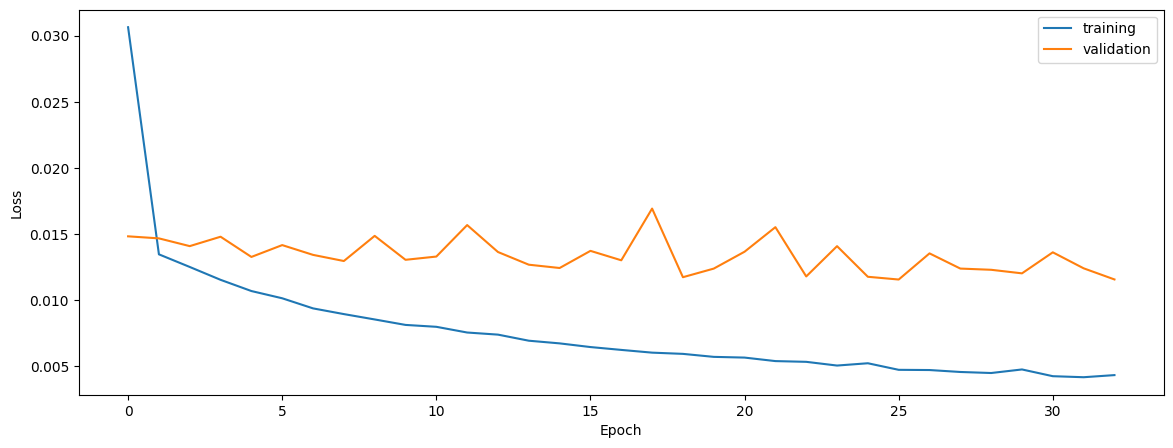

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.9649238430042413
0.8239446916640727
0.8364938347639713


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.7733527949110809
0.8010749568629768
0.7669593202739491


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.775642969286488
0.7990810846824091
0.7708428700889352


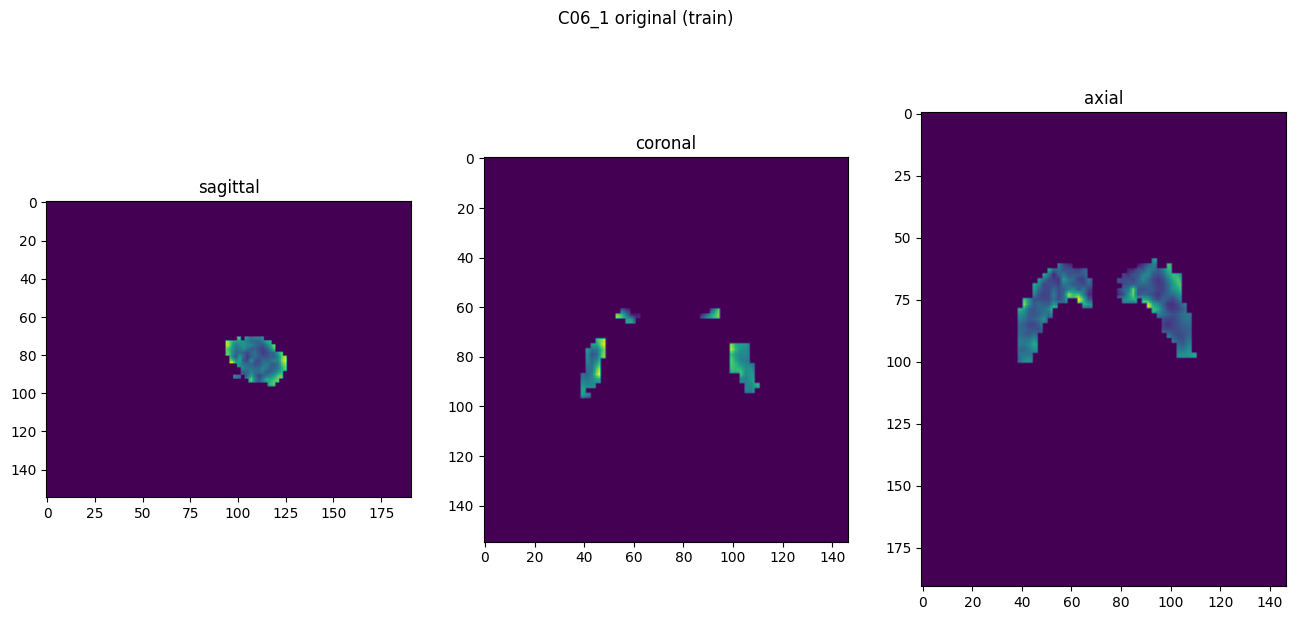

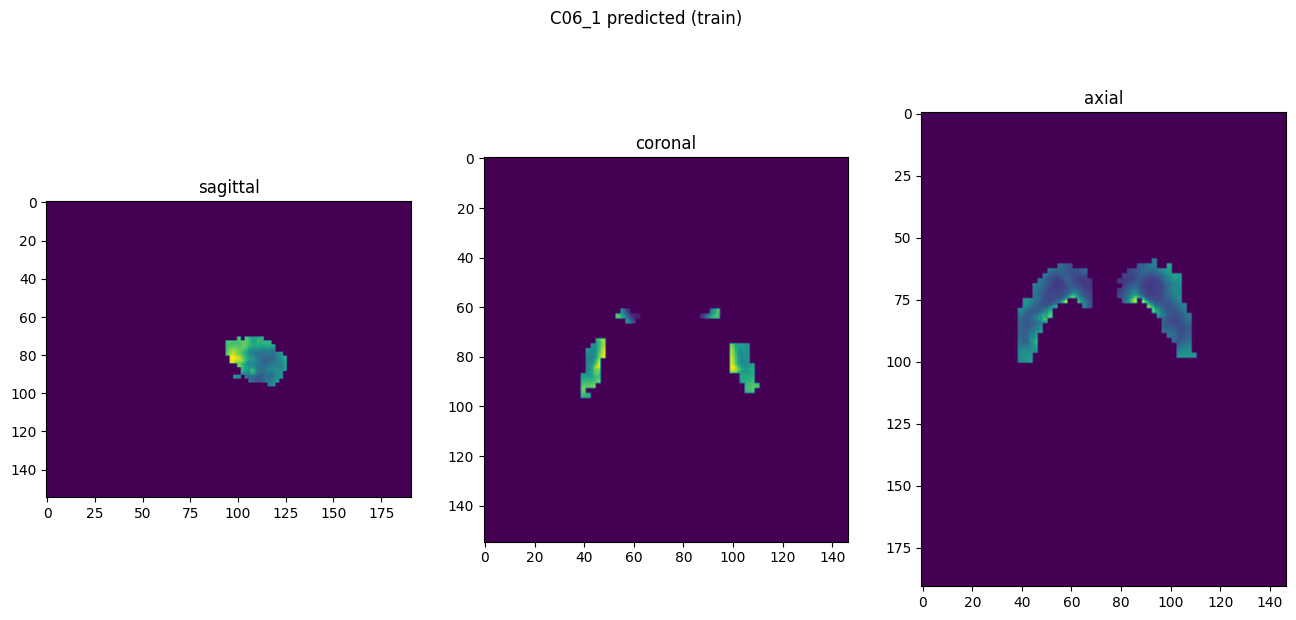

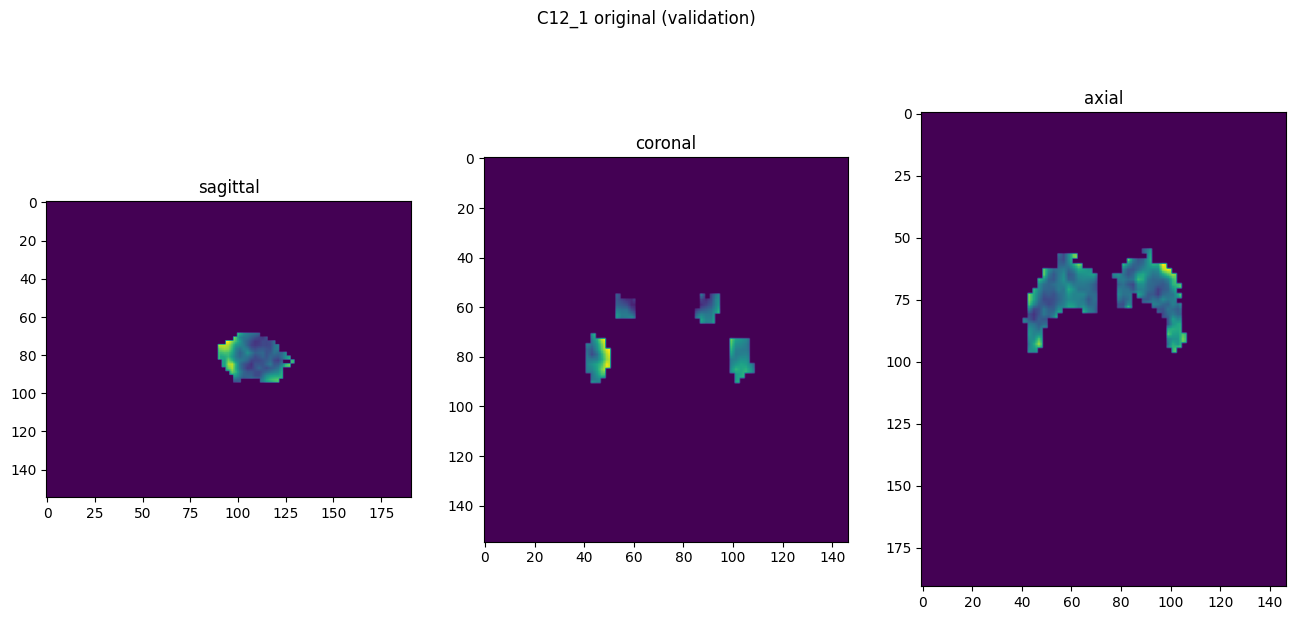

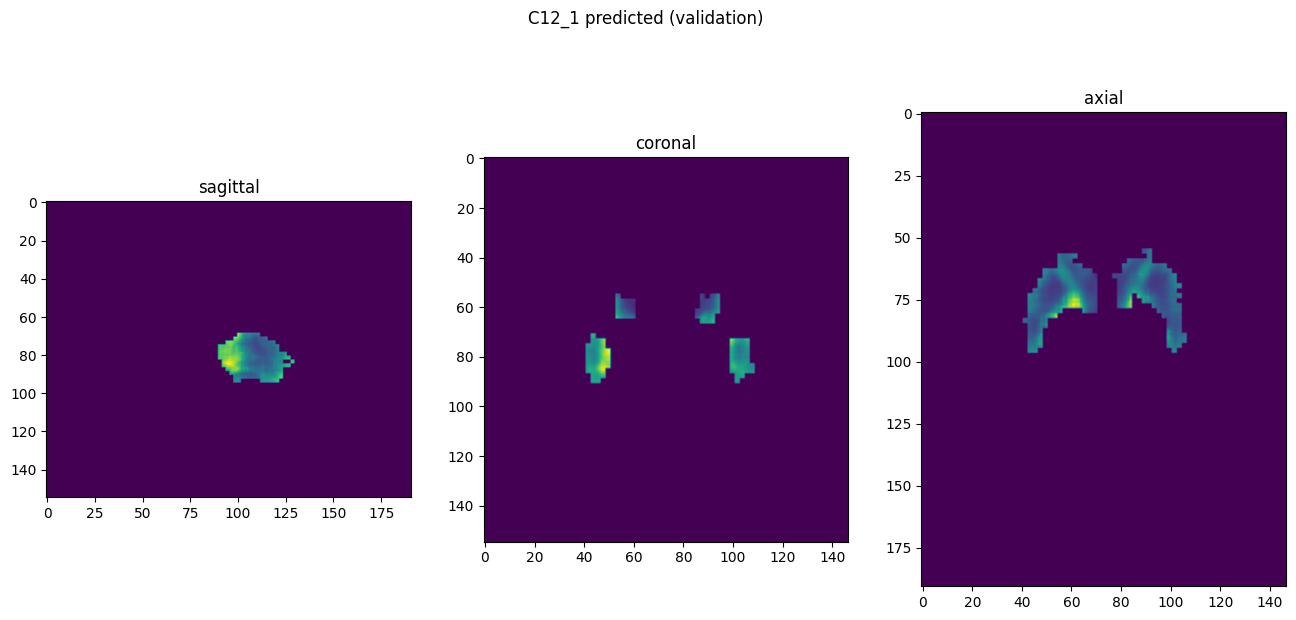

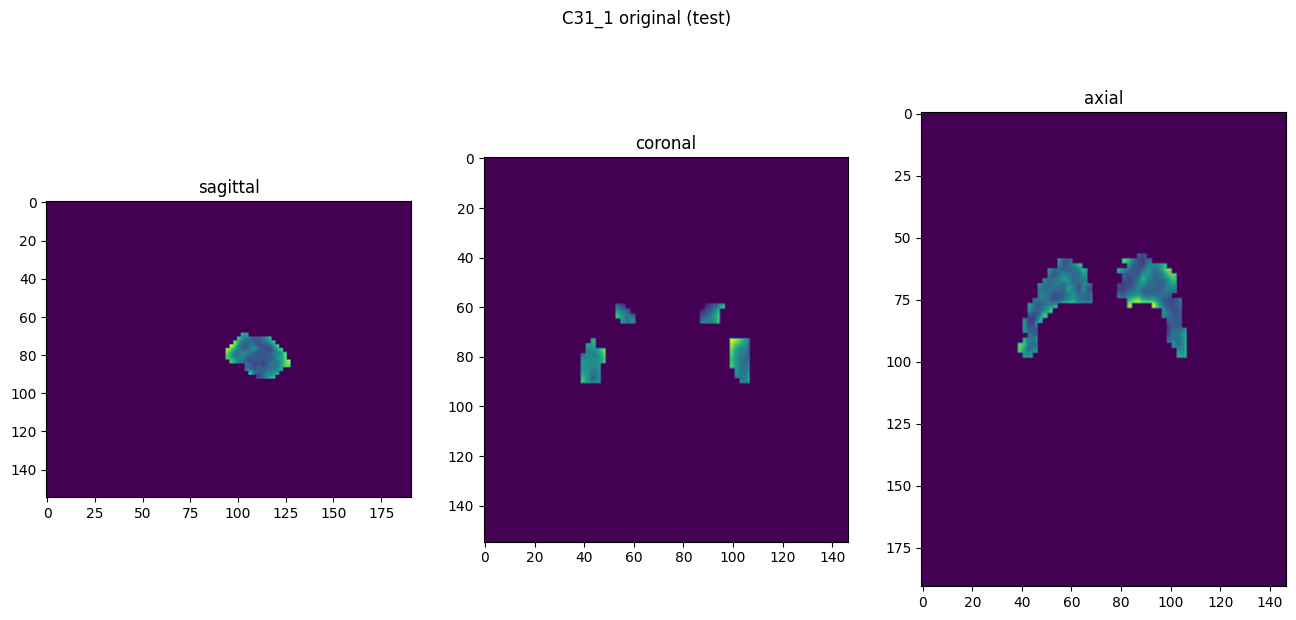

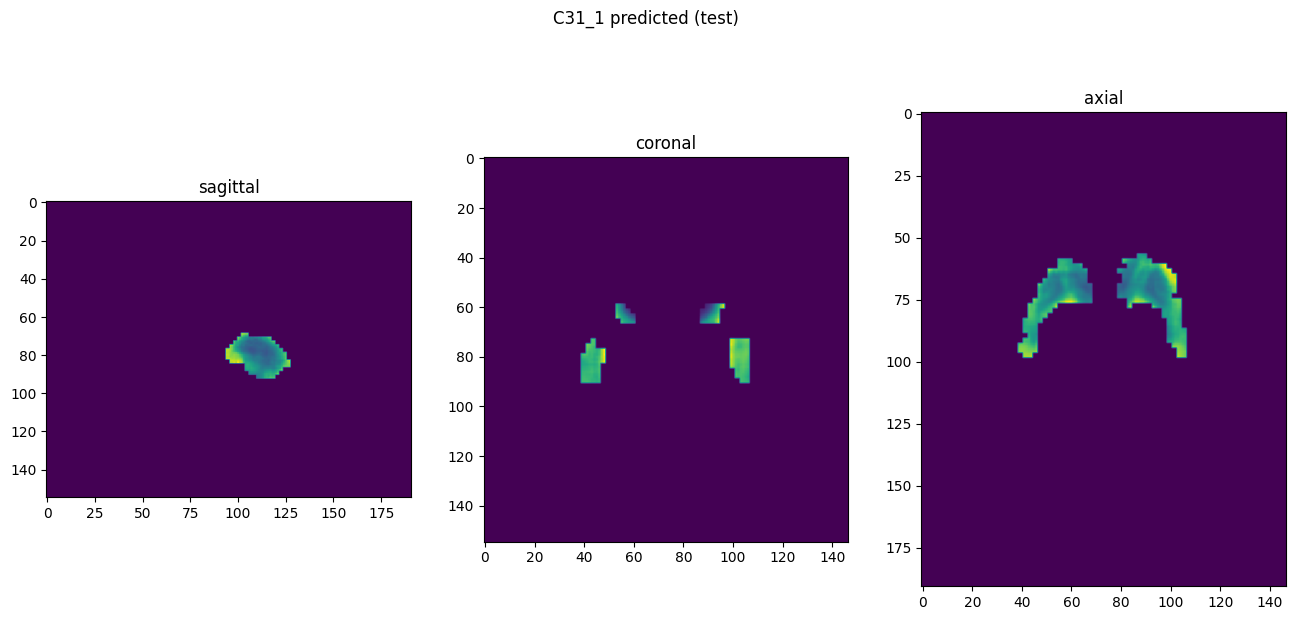

In [10]:
showResults(model, gen, threshold=None, background=False)